In [65]:
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [90]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from glob import glob
from tqdm import tqdm
from PIL import Image

# Constants
IMAGE_SIZE = (128, 128)
MASK_SUFFIX = "_mask.tif"

def load_data_csv(csv_path):
    df = pd.read_csv(csv_path)
    df['Patient'] = df['Patient'].astype(str).str.strip()
    df = df.dropna(subset=['RNASeqCluster'])

    label_map = {row['Patient']: int(row['RNASeqCluster']) - 1 for _, row in df.iterrows()}
    return label_map

def extract_patient_id(filename):
    parts = filename.split('_')
    return '_'.join(parts[:3])

def load_image(image_path):
    image = Image.open(image_path)
    image = np.array(image)

    if image.ndim == 2:
        image = np.stack([image] * 3, axis=-1)  # convert grayscale to RGB

    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image

def load_mask(mask_path):
    mask = Image.open(mask_path)
    mask = np.array(mask)
    mask = tf.image.resize(mask[..., np.newaxis], IMAGE_SIZE, method='nearest')
    mask = tf.cast(mask > 0, tf.float32)  # Binarize
    return mask

def create_dataset(data_dir, label_map):
    image_files = sorted(glob(os.path.join(data_dir, "**", "*.tif"), recursive=True))
    image_files = [f for f in image_files if not f.endswith(MASK_SUFFIX)]

    images, masks, labels = [], [], []

    for img_path in tqdm(image_files, desc="Loading images"):
        mask_path = img_path.replace('.tif', MASK_SUFFIX)

        if not os.path.exists(mask_path):
            continue

        try:
            image = load_image(img_path)
            mask = load_mask(mask_path)

            pid = extract_patient_id(os.path.basename(img_path))
            label = label_map.get(pid)

            if label is None:
                continue

            images.append(image)
            masks.append(mask)
            labels.append(label)

        except Exception as e:
            print(f"Skipping {img_path}: {e}")
            continue

    print(f"Loaded {len(images)} image-mask-label triplets.")
    return tf.data.Dataset.from_tensor_slices((images, masks, labels))


# ---- Augmentation logic (optional) ----
def augment(features, targets):
    img = features['input_image']
    mask = targets['segmentation']
    label = targets['classification']

    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)

    if tf.random.uniform(()) > 0.5:
        img = tf.image.random_brightness(img, max_delta=0.1)

    return {'input_image': img}, {
        'segmentation': mask,
        'classification': label
    }

def prepare_tf_dataset(ds, batch_size=8, shuffle=True, augment_data=False):
    def map_fn(img, mask, label):
        return {'input_image': img}, {
            'segmentation': mask,
            'classification': tf.cast(label, tf.int32)
        }

    ds = ds.map(map_fn, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(buffer_size=1000)

    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    if augment_data:
        ds = ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

    return ds


In [91]:
def split_dataset_efficient(ds, train_frac=0.7, val_frac=0.15, test_frac=0.15):
    total_count = 3180  # You already know this from print
    train_count = int(train_frac * total_count)
    val_count = int(val_frac * total_count)

    ds = ds.shuffle(total_count, seed=42)

    train_ds = ds.take(train_count)
    val_ds = ds.skip(train_count).take(val_count)
    test_ds = ds.skip(train_count + val_count)

    return train_ds, val_ds, test_ds


 Data Pipeline Code (with Augmentation + Output Dictionary)

In [68]:
import os
import glob
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image

# Constants
IMAGE_SIZE = (128, 128)

# Utility to extract patient ID
def extract_pid(path):
    return "_".join(os.path.basename(path).split('_')[:3])

# Load label map from CSV
def load_data_csv(csv_path):
    df = pd.read_csv(csv_path)
    df['Patient'] = df['Patient'].astype(str).str.strip()
    df = df.dropna(subset=['RNASeqCluster'])
    label_map = {row['Patient']: int(row['RNASeqCluster']) - 1 for _, row in df.iterrows()}
    return label_map

# Create list of (img_path, mask_path, label)
def get_paths_and_labels(image_dir, label_map):
    image_paths = sorted(glob.glob(os.path.join(image_dir, '**', '*.tif'), recursive=True))
    image_paths = [p for p in image_paths if not p.endswith('_mask.tif')]

    data = []
    for img_path in image_paths:
        mask_path = img_path.replace('.tif', '_mask.tif')
        pid = extract_pid(img_path)
        label = label_map.get(pid)
        if os.path.exists(mask_path) and label is not None:
            data.append((img_path, mask_path, label))
    return data


In [69]:
import tensorflow as tf
import numpy as np
from PIL import Image

IMAGE_SIZE = (240, 240)

# --- Image Loader ---
def _load_image(path):
    path = path.decode()  # Convert bytes to string
    img = Image.open(path).convert("RGB")
    img = img.resize(IMAGE_SIZE)
    img = np.array(img).astype(np.float32) / 255.0
    return img

def load_image_tf(path):
    img = tf.numpy_function(_load_image, [path], tf.float32)
    img.set_shape([*IMAGE_SIZE, 3])
    return img

# --- Mask Loader ---
def _load_mask(path):
    path = path.decode()
    mask = Image.open(path)
    mask = mask.resize(IMAGE_SIZE, resample=Image.NEAREST)
    mask = np.array(mask)
    mask = (mask > 0).astype(np.float32)  # binarize
    return mask[..., np.newaxis]

def load_mask_tf(path):
    mask = tf.numpy_function(_load_mask, [path], tf.float32)
    mask.set_shape([*IMAGE_SIZE, 1])
    return mask


In [70]:
def process_data(img_path, mask_path, label):
    img = load_image_tf(img_path)
    mask = load_mask_tf(mask_path)
    return {'input_image': img}, {
        'segmentation': mask,
        'classification': label
    }


In [71]:
def prepare_dataset(data, batch_size=8, shuffle=True):
    img_paths, mask_paths, labels = zip(*data)
    ds = tf.data.Dataset.from_tensor_slices((list(img_paths), list(mask_paths), list(labels)))

    if shuffle:
        ds = ds.shuffle(buffer_size=len(data))

    ds = ds.map(process_data, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds


In [92]:
import os
import random
from glob import glob

# Set seed for reproducibility
random.seed(42)

IMAGE_SUFFIX = ".tif"
MASK_SUFFIX = "_mask.tif"
IMAGE_SIZE = (128, 128)

def extract_patient_id(filename):
    parts = filename.split('_')
    return '_'.join(parts[:3])

def get_paths_and_labels(image_dir, label_map):
    image_files = sorted(glob(os.path.join(image_dir, "**", "*.tif"), recursive=True))
    image_files = [f for f in image_files if not f.endswith(MASK_SUFFIX)]

    data = []
    for img_path in image_files:
        mask_path = img_path.replace(IMAGE_SUFFIX, MASK_SUFFIX)
        if not os.path.exists(mask_path):
            continue

        patient_id = extract_patient_id(os.path.basename(img_path))
        label = label_map.get(patient_id)

        if label is not None:
            data.append((img_path, mask_path, label))

    return data


In [93]:
csv_path = 'C:/Users/DELL/Downloads/archive (5)/lgg-mri-segmentation/data.csv'
image_dir = 'C:/Users/DELL/Downloads/archive (5)/lgg-mri-segmentation/kaggle_3m'

label_map = load_data_csv(csv_path)
all_data = get_paths_and_labels(image_dir, label_map)

print("Original dataset size:", len(all_data))

# Take only 25% of the dataset
reduced_data = random.sample(all_data, k=len(all_data) // 4)

print("Reduced dataset size:", len(reduced_data))


Original dataset size: 3180
Reduced dataset size: 795


In [ ]:
# Optional: write the reduced set to a CSV
import pandas as pd

df_reduced = pd.DataFrame(reduced_data, columns=["image_path", "mask_path", "label"])
df_reduced.to_csv("reduced_dataset.csv", index=False)


In [94]:
# Split reduced data
from sklearn.model_selection import train_test_split

train_data, temp_data = train_test_split(reduced_data, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

print(f"Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")


Train: 556, Val: 119, Test: 120


In [95]:
train_ds = prepare_dataset(train_data, batch_size=8, shuffle=True)
val_ds = prepare_dataset(val_data, batch_size=8, shuffle=False)
test_ds = prepare_dataset(test_data, batch_size=8, shuffle=False)


In [96]:
for x, y in train_ds.take(1):
    print("Image shape:", x['input_image'].shape)
    print("Mask shape:", y['segmentation'].shape)
    print("Label:", y['classification'])


Image shape: (8, 128, 128, 3)
Mask shape: (8, 128, 128, 1)
Label: tf.Tensor([1 0 3 3 2 1 0 1], shape=(8,), dtype=int32)


In [76]:
def light_augment(x, y):
    img = x['input_image']
    mask = y['segmentation']

    img = tf.image.random_flip_left_right(img)
    mask = tf.image.random_flip_left_right(mask)

    return {'input_image': img}, {
        'segmentation': mask,
        'classification': y['classification']
    }

train_ds = train_ds.map(light_augment, num_parallel_calls=tf.data.AUTOTUNE)


Model Building

In [97]:
import tensorflow as tf
from tensorflow.keras import layers, Model, regularizers

# -----------------------------
# Attention Gate
# -----------------------------
def attention_gate(x, g, inter_channels):
    theta_x = layers.Conv2D(inter_channels, 1)(x)
    phi_g = layers.Conv2D(inter_channels, 1)(g)
    add = layers.Activation('relu')(layers.add([theta_x, phi_g]))
    psi = layers.Conv2D(1, 1)(add)
    psi = layers.BatchNormalization()(psi)
    psi = layers.Activation('sigmoid')(psi)
    return layers.Multiply()([x, psi])

# -----------------------------
# Conv Block: Conv → BN → ReLU [+ Dropout]
# -----------------------------
def conv_block(x, filters, dropout_rate=0.2):
    x = layers.Conv2D(filters, 3, padding='same', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, 3, padding='same', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)
    return x

# -----------------------------
# Encoder Block
# -----------------------------
def encoder_block(x, filters):
    c = conv_block(x, filters)
    p = layers.MaxPooling2D((2, 2))(c)
    return c, p

# -----------------------------
# Decoder Block with Attention
# -----------------------------
def decoder_block(x, skip, filters):
    up = layers.Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(x)
    g = layers.Conv2D(filters, 1)(up)
    attn = attention_gate(skip, g, filters)
    concat = layers.Concatenate()([up, attn])
    return conv_block(concat, filters)

# -----------------------------
# Build Multi-Task Attention U-Net
# -----------------------------
def build_multitask_unet(input_shape=(240, 240, 1), num_classes=4, base_filters=32):
    inputs = layers.Input(shape=input_shape, name='input_image')

    # Encoder
    c1, p1 = encoder_block(inputs, base_filters)           # 240 -> 120
    c2, p2 = encoder_block(p1, base_filters * 2)           # 120 -> 60
    c3, p3 = encoder_block(p2, base_filters * 4)           # 60 -> 30
    c4, p4 = encoder_block(p3, base_filters * 8)           # 30 -> 15

    # Bottleneck with residual path
    bn = conv_block(p4, base_filters * 16)
    bn = conv_block(bn, base_filters * 16)

    # Decoder for Segmentation
    d4 = decoder_block(bn, c4, base_filters * 8)
    d3 = decoder_block(d4, c3, base_filters * 4)
    d2 = decoder_block(d3, c2, base_filters * 2)
    d1 = decoder_block(d2, c1, base_filters)

    # Segmentation output
    seg_output = layers.Conv2D(1, 1, activation='sigmoid', name='segmentation')(d1)

    # Classification Head from bottleneck
    clf = layers.GlobalAveragePooling2D()(bn)
    clf = layers.BatchNormalization()(clf)
    clf = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(clf)
    clf = layers.Dropout(0.4)(clf)
    clf = layers.Dense(num_classes, activation='softmax', name='classification')(clf)

    # Final Model
    model = Model(inputs=inputs, outputs={
        'segmentation': seg_output,
        'classification': clf
    })

    return model


In [102]:
model = build_multitask_unet((128, 128, 3), num_classes=4)
model.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)      │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_310 (Conv2D)           │ (None, 128, 128, 32)      │             896 │ input_image[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_176       │ (None, 128, 128, 32)      │             128 │ conv2d_310[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_166 (ReLU)              │ (None, 128, 128, 32)      │               0 │ batch_normalization_176[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_311 (Conv2D)           │ (None, 128, 128, 32)      │           9,248 │ re_lu_166[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_177       │ (None, 128, 128, 32)      │             128 │ conv2d_311[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_167 (ReLU)              │ (None, 128, 128, 32)      │               0 │ batch_normalization_177[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_29 (Dropout)          │ (None, 128, 128, 32)      │               0 │ re_lu_167[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_36              │ (None, 64, 64, 32)        │               0 │ dropout_29[0][0]           │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_312 (Conv2D)           │ (None, 64, 64, 64)        │          18,496 │ max_pooling2d_36[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_178       │ (None, 64, 64, 64)        │             256 │ conv2d_312[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_168 (ReLU)              │ (None, 64, 64, 64)        │               0 │ batch_normalization_178[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_313 (Conv2D)           │ (None, 64, 64, 64)        │          36,928 │ re_lu_168[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_179       │ (None, 64, 64, 64)        │             256 │ conv2d_313[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_169 (ReLU)              │ (None, 64, 64, 64)        │               

 Total params: 12,826,873 (48.93 MB)

 Trainable params: 12,817,905 (48.90 MB)

 Non-trainable params: 8,968 (35.03 KB)

 Loss Functions & Compilation

Training Script

In [103]:
import os
import numpy as np
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import backend as K

# -----------------------------
# 1. Segmentation Loss - BCE + Dice (Optional Upgrade)
# -----------------------------
def binary_segmentation_loss():
    bce = tf.keras.losses.BinaryCrossentropy()

    def dice_loss(y_true, y_pred, smooth=1e-6):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    def combined_loss(y_true, y_pred):
        return bce(y_true, y_pred) + dice_loss(y_true, y_pred)

    return combined_loss  # or just return bce for original

# -----------------------------
# 2. Classification Loss - Focal Loss
# -----------------------------
def focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        y_true = tf.cast(tf.reshape(y_true, [-1]), tf.int32)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)

        num_classes = tf.shape(y_pred)[-1]
        y_true_onehot = tf.one_hot(y_true, depth=num_classes)

        cross_entropy = -y_true_onehot * tf.math.log(y_pred)
        weight = alpha * tf.math.pow(1 - y_pred, gamma)
        focal = weight * cross_entropy

        return tf.reduce_mean(tf.reduce_sum(focal, axis=-1))
    return loss

# -----------------------------
# 3. Metrics for Segmentation
# -----------------------------
def dice_score(y_true, y_pred, smooth=1e-6):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_score(y_true, y_pred, smooth=1e-6):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

# -----------------------------
# 4. Compile the Multi-Task Model
# -----------------------------
def compile_multitask_model(model, λ1=2.0, λ2=1.0, lr=1e-4):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss={
            'segmentation': lambda y_true, y_pred: λ1 * binary_segmentation_loss()(y_true, y_pred),
            'classification': lambda y_true, y_pred: λ2 * focal_loss()(y_true, y_pred)
        },
        metrics={
            'segmentation': [dice_score, iou_score],
            'classification': ['accuracy']
        }
    )
    return model


In [104]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

# -----------------------------
# Training Function
# -----------------------------
def train_multitask_model(model, train_ds, val_ds, output_dir, epochs=50, initial_epoch=0):
    os.makedirs(output_dir, exist_ok=True)

    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        ModelCheckpoint(
            filepath=os.path.join(output_dir, 'best_model.keras'),
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            verbose=1
        ),
        CSVLogger(os.path.join(output_dir, 'training_log.csv'))
    ]

    # Save model architecture as JSON for reproducibility
    with open(os.path.join(output_dir, 'model_architecture.json'), 'w') as f:
        f.write(model.to_json(indent=2))

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=callbacks,
        initial_epoch=initial_epoch,
        verbose=1
    )
    return history


In [105]:
# 1. Build your model
model = build_multitask_unet(input_shape=(128, 128, 3), num_classes=4)

# 2. Compile with BinaryCrossentropy + Focal Loss
model = compile_multitask_model(model, λ1=2.0, λ2=1.0)

# 3. Train the model
output_dir = '/content/drive/MyDrive/lgg-mri-segmentation/model_output'
history = train_multitask_model(model, train_ds, val_ds, output_dir=output_dir, epochs=50)


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - classification_accuracy: 0.2858 - classification_loss: 0.3954 - loss: 5.0346 - segmentation_dice_score: 0.0222 - segmentation_iou_score: 0.0113 - segmentation_loss: 4.2407
Epoch 1: val_loss improved from inf to 4.03103, saving model to /content/drive/MyDrive/lgg-mri-segmentation/model_output\best_model.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - classification_accuracy: 0.2858 - classification_loss: 0.3949 - loss: 5.0286 - segmentation_dice_score: 0.0224 - segmentation_iou_score: 0.0114 - segmentation_loss: 4.2351 - val_classification_accuracy: 0.2941 - val_classification_loss: 0.1795 - val_loss: 4.0310 - val_segmentation_dice_score: 0.0153 - val_segmentation_iou_score: 0.0077 - val_segmentation_loss: 3.4542 - learning_rate: 1.0000e-04
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - classification_accuracy: 0.3042 - classification_loss: 0.2738 - loss: 3.6845 - segmentation_dice_score: 0.0677 - segmentation_iou_score: 0.0357 - se

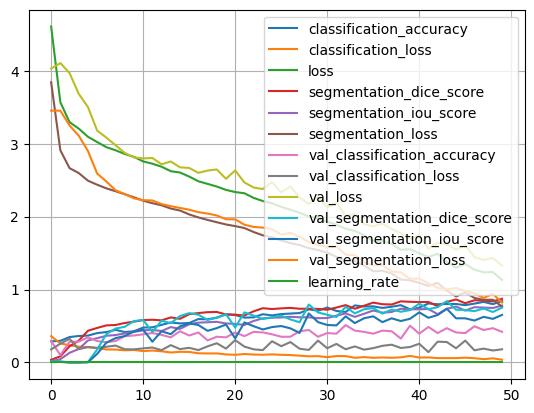

In [106]:
import matplotlib.pyplot as plt

def plot_history(history):
    for key in history.history:
        plt.plot(history.history[key], label=key)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_history(history)


In [ ]:
#A. Segmentation Evaluation

In [107]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score

# --- Dice Score ---
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

# --- IoU Score ---
def iou_score_np(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

# --- Visual Overlay ---
def plot_segmentation_result(image, ground_truth, prediction):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Input Image")

    plt.subplot(1, 3, 2)
    plt.imshow(ground_truth[..., 0], cmap='gray')
    plt.title("Ground Truth")

    plt.subplot(1, 3, 3)
    plt.imshow(prediction[..., 0], cmap='gray')
    plt.title("Predicted Mask")

    plt.show()

# --- Evaluate Segmentation Dataset ---
def evaluate_segmentation(model, dataset, threshold=0.5, num_samples=10):
    dice_scores = []
    iou_scores = []

    for i, (inputs, outputs) in enumerate(dataset.take(num_samples)):
        image = inputs['input_image']
        true_mask = outputs['segmentation']

        pred_mask = model.predict(tf.expand_dims(image, 0))['segmentation'][0]
        pred_mask_bin = (pred_mask > threshold).astype(np.float32)

        dice = dice_coef(true_mask.numpy(), pred_mask_bin)
        iou = iou_score_np(true_mask.numpy(), pred_mask_bin)

        dice_scores.append(dice)
        iou_scores.append(iou)

        plot_segmentation_result(image.numpy(), true_mask.numpy(), pred_mask_bin)

    print(f"\nAverage Dice Score: {np.mean(dice_scores):.4f}")
    print(f"Average IoU Score: {np.mean(iou_scores):.4f}")


In [108]:
# B. Classification Evaluation

In [111]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
import seaborn as sns

def evaluate_classification(model, dataset):
    y_true = []
    y_pred = []

    for inputs, outputs in dataset:
        true_label = outputs['classification'].numpy()

        # Expand batch dimension for prediction (shape: (1, H, W, C))
        input_batch = {k: tf.expand_dims(v, axis=0) for k, v in inputs.items()}
        pred_probs = model.predict(input_batch, verbose=0)['classification']
        pred_label = np.argmax(pred_probs, axis=-1)

        y_true.extend([true_label])
        y_pred.extend(pred_label)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)

    print(f"\nClassification Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    print("\nClassification Report:\n", classification_report(y_true, y_pred))



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


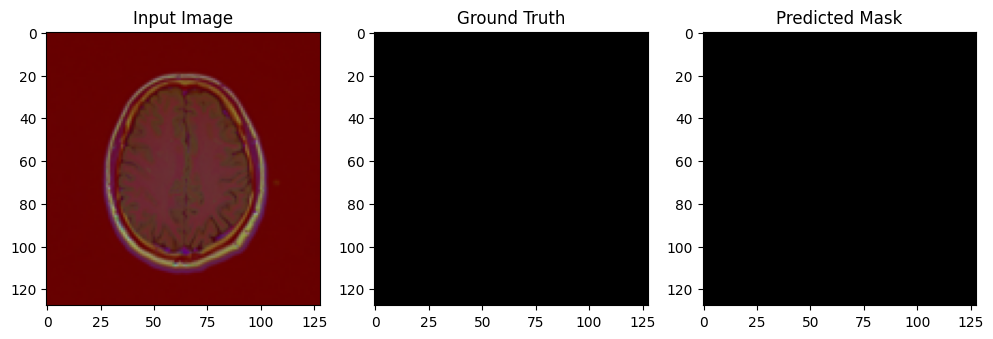

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


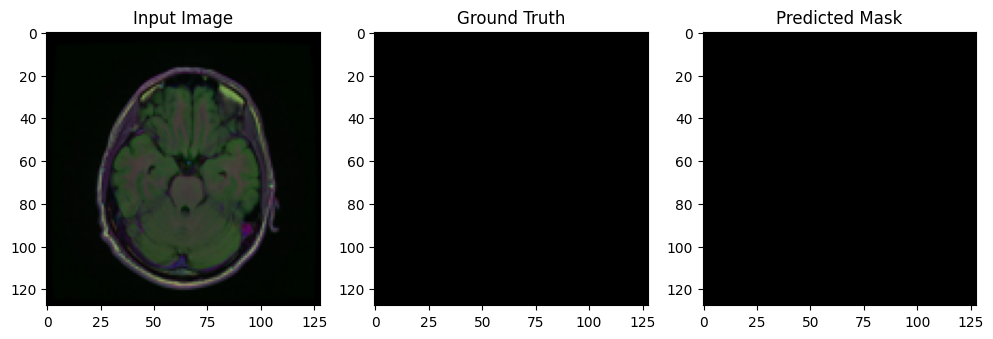

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


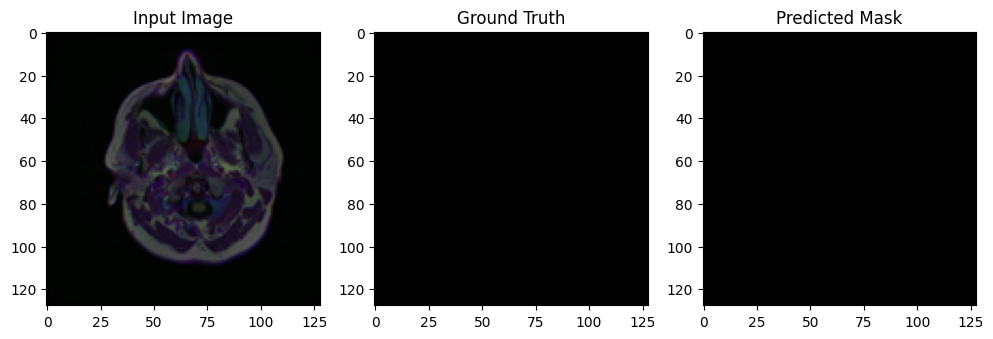

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


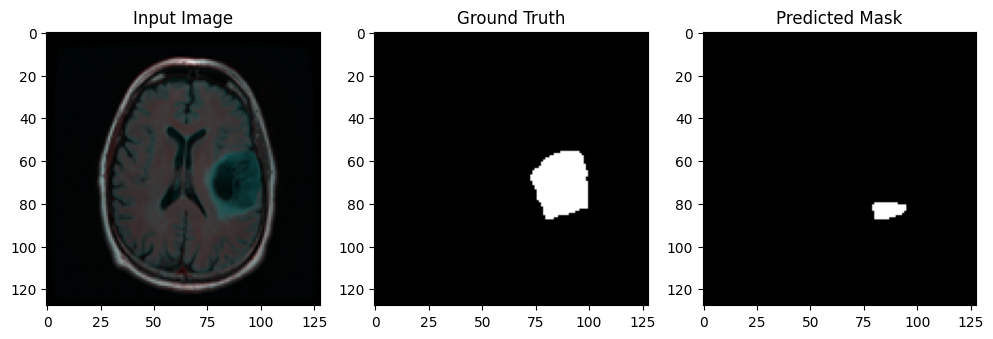

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


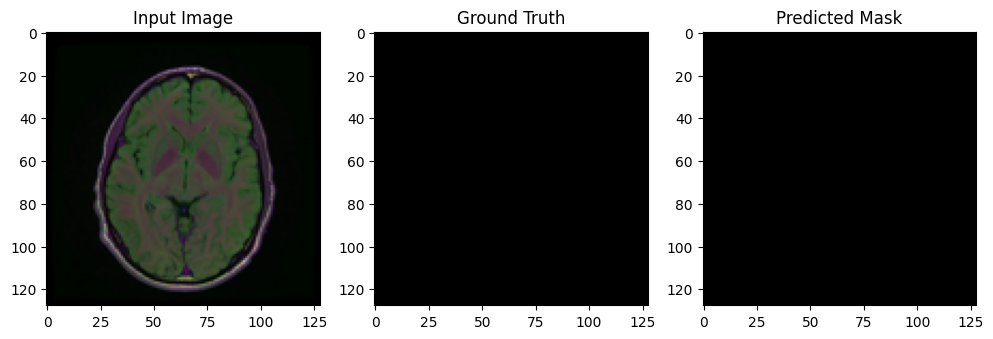

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


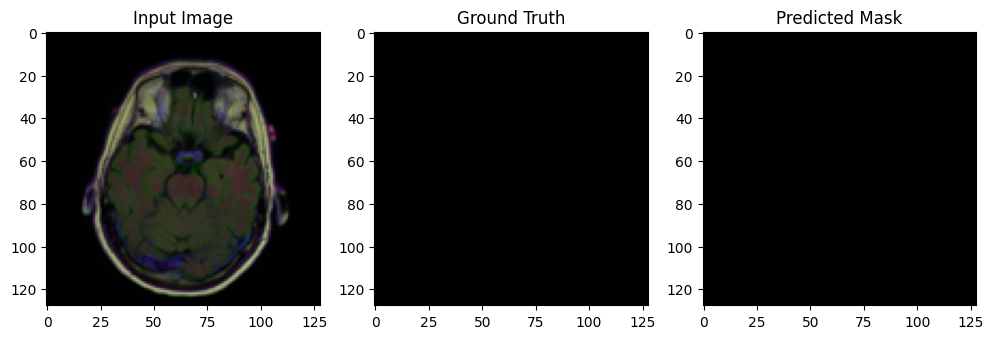

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


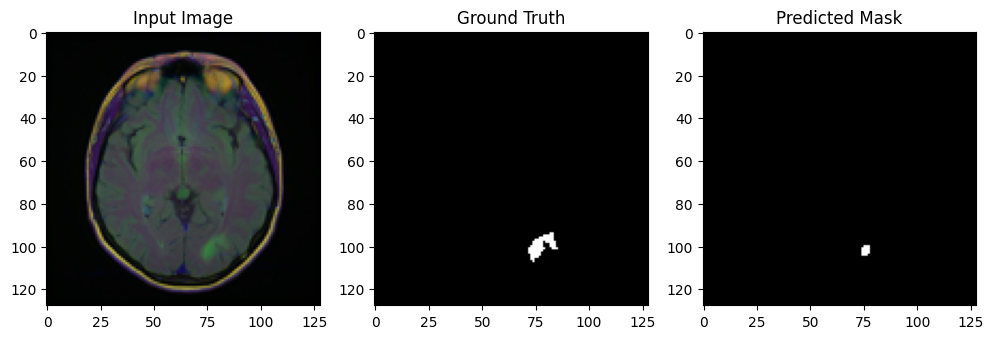

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


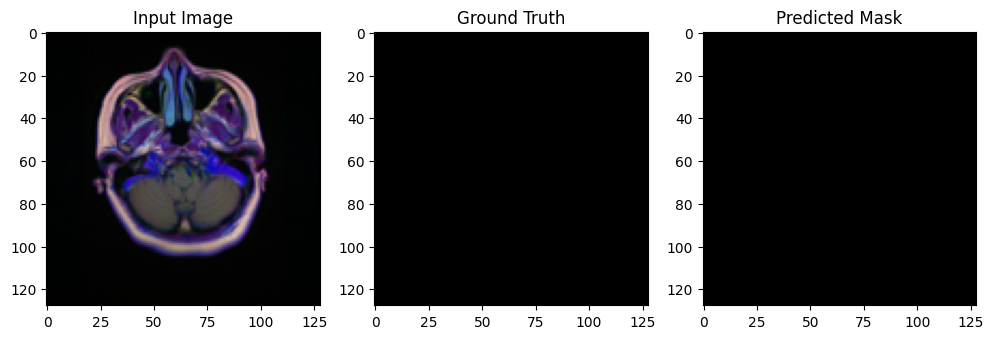

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


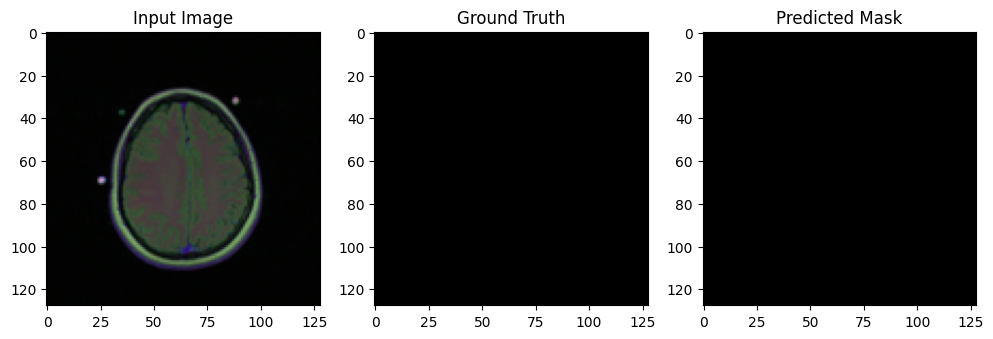

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


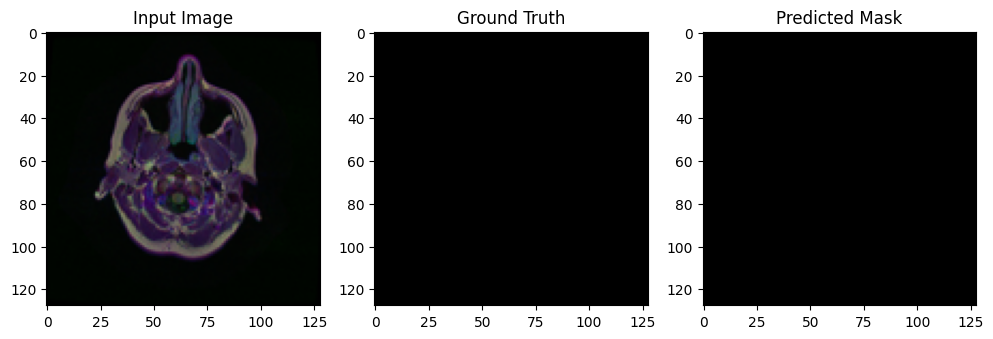


Average Dice Score: 0.8594
Average IoU Score: 0.8350

Classification Accuracy: 0.4500
Precision: 0.6250
Recall: 0.4500


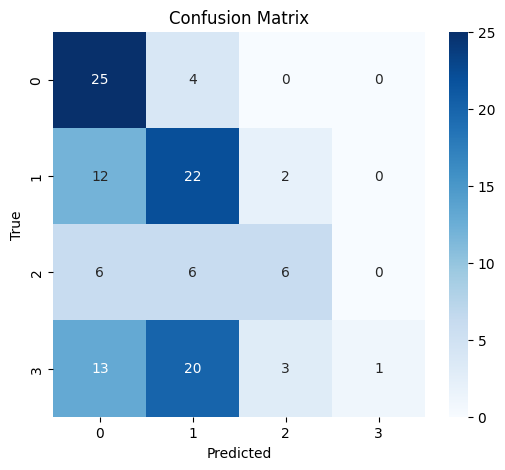


Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.86      0.59        29
           1       0.42      0.61      0.50        36
           2       0.55      0.33      0.41        18
           3       1.00      0.03      0.05        37

    accuracy                           0.45       120
   macro avg       0.60      0.46      0.39       120
weighted avg       0.62      0.45      0.37       120



In [112]:
# Unbatch the test dataset for evaluation (1 sample at a time)
test_unbatched = test_ds.unbatch()

# Segmentation Evaluation
evaluate_segmentation(model, test_unbatched, threshold=0.5, num_samples=10)

# Classification Evaluation
evaluate_classification(model, test_unbatched)


In [113]:
import tensorflow as tf
import numpy as np
from PIL import Image
import os

# --------------------------------------------
# Config
# --------------------------------------------
IMAGE_SIZE = (240, 240)  # Same as training
CLASS_NAMES = ['Class_0', 'Class_1', 'Class_2', 'Class_3']  # Update based on your labels

# --------------------------------------------
# 1. Load & Preprocess Image (same as training)
# --------------------------------------------
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = image.resize(IMAGE_SIZE)
    image = np.array(image, dtype=np.float32) / 255.0
    image = tf.convert_to_tensor(image)
    image = tf.expand_dims(image, axis=0)  # (1, H, W, C)
    return image

# --------------------------------------------
# 2. Post-process predicted mask
# --------------------------------------------
def postprocess_mask(mask_pred, threshold=0.5, original_size=(512, 512)):
    mask = (mask_pred > threshold).astype(np.uint8)
    mask_img = Image.fromarray(mask.squeeze() * 255)
    mask_img = mask_img.resize(original_size, resample=Image.NEAREST)
    return mask_img

# --------------------------------------------
# 3. Run Inference
# --------------------------------------------
def run_inference(model, image_path, original_size=(512, 512)):
    input_image = preprocess_image(image_path)

    preds = model.predict(input_image)
    seg_pred = preds['segmentation'][0]
    clf_pred = preds['classification'][0]

    # Segmentation mask (post-processed)
    mask_img = postprocess_mask(seg_pred, original_size=original_size)

    # Classification label
    class_idx = np.argmax(clf_pred)
    class_label = CLASS_NAMES[class_idx]
    class_prob = clf_pred[class_idx]

    return mask_img, class_label, class_prob


In [127]:
# Load your trained model (ensure it's compiled or load weights)
model_path = '/content/drive/MyDrive/lgg-mri-segmentation/model_output/best_model.keras'
model = tf.keras.models.load_model(model_path, compile=False)

IMAGE_SIZE = (128, 128)

import glob
import random

image_path = 'C:/Users/DELL/Downloads/archive (5)/lgg-mri-segmentation/kaggle_3m'
import random

# Pick one sample (image path, mask path, label)
image_path, _, _ = random.choice(all_data)
print("Selected image:", image_path)

# Run inference
mask_image, predicted_class, class_prob = run_inference(model, image_path, original_size=(512, 512))

# Save or display result
mask_image.save("predicted_mask.png")
print("Predicted Class:", predicted_class)
print("Confidence:", round(class_prob * 100, 2), "%")





Selected image: C:/Users/DELL/Downloads/archive (5)/lgg-mri-segmentation/kaggle_3m\TCGA_CS_6290_20000917\TCGA_CS_6290_20000917_20.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Class: Class_1
Confidence: 43.24 %


In [128]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# --- Overlay mask on image ---
def overlay_mask_on_image(image_path, predicted_mask, alpha=0.4):
    """
    Overlay the predicted segmentation mask on the original image.
    - image_path: original image path
    - predicted_mask: 2D numpy array (binary mask)
    """
    # Load original image
    original = Image.open(image_path).convert("RGB").resize(predicted_mask.shape[::-1])
    original_np = np.array(original)

    # Create red mask
    red_mask = np.zeros_like(original_np)
    red_mask[..., 0] = 255  # Red channel only

    # Blend original with mask
    overlay = np.where(predicted_mask[..., None] > 0.5,  # Threshold
                       alpha * red_mask + (1 - alpha) * original_np,
                       original_np).astype(np.uint8)

    return overlay

# --- Display function ---
def visualize_prediction(image_path, predicted_mask, predicted_class, class_prob):
    overlay = overlay_mask_on_image(image_path, predicted_mask)

    plt.figure(figsize=(10, 5))

    # Original + Mask Overlay
    plt.subplot(1, 2, 1)
    plt.imshow(overlay)
    plt.title("Overlay: Segmentation Mask")
    plt.axis("off")

    # Classification Info
    plt.subplot(1, 2, 2)
    plt.text(0.1, 0.6, f"Predicted Class:\n\n{predicted_class}", fontsize=16)
    plt.text(0.1, 0.4, f"Confidence: {class_prob * 100:.2f}%", fontsize=14)
    plt.axis("off")

    plt.tight_layout()
    plt.show()


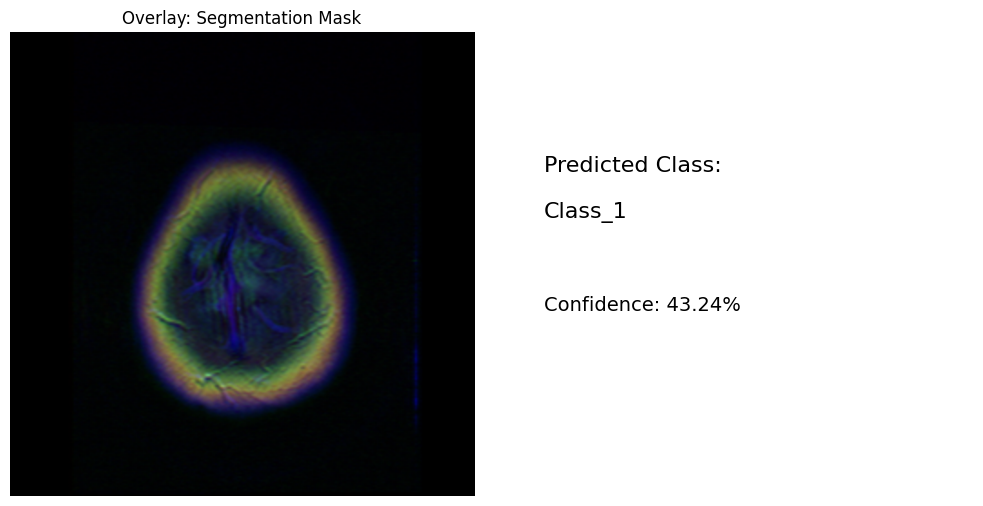

In [129]:
predicted_mask_np = np.array(mask_image) / 255.0
visualize_prediction(image_path, predicted_mask_np, predicted_class, class_prob)


In [130]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

# Create output folders
output_dir = "prediction_outputs"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(os.path.join(output_dir, "visualizations"), exist_ok=True)

results = []

# --- Overlay function ---
def overlay_mask_on_image(image_path, predicted_mask, alpha=0.4):
    original = Image.open(image_path).convert("RGB").resize(predicted_mask.shape[::-1])
    original_np = np.array(original)

    red_mask = np.zeros_like(original_np)
    red_mask[..., 0] = 255  # Red

    overlay = np.where(predicted_mask[..., None] > 0.5,
                       alpha * red_mask + (1 - alpha) * original_np,
                       original_np).astype(np.uint8)

    return overlay

# --- Visualization function ---
def save_visualization(image_path, predicted_mask, predicted_class, class_prob, output_path):
    overlay = overlay_mask_on_image(image_path, predicted_mask)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(overlay)
    plt.title("Segmentation Overlay")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.text(0.1, 0.6, f"Predicted Class:\n\n{predicted_class}", fontsize=14)
    plt.text(0.1, 0.4, f"Confidence: {class_prob*100:.2f}%", fontsize=12)
    plt.axis("off")

    plt.tight_layout()
    plt.savefig(output_path)
    plt.close()

# --- Main loop ---
for img_path, _, _ in tqdm(all_data, desc="Running Inference"):
    try:
        mask_image, predicted_class, class_prob = run_inference(model, img_path, original_size=(512, 512))
        predicted_mask_np = np.array(mask_image) / 255.0

        # Unique filename
        fname = os.path.basename(img_path).replace('.tif', '')
        vis_path = os.path.join(output_dir, "visualizations", f"{fname}_vis.png")

        # Save overlay
        save_visualization(img_path, predicted_mask_np, predicted_class, class_prob, vis_path)

        # Log result
        results.append({
            "image": fname,
            "class": predicted_class,
            "probability": round(class_prob, 4)
        })

    except Exception as e:
        print(f"Error processing {img_path}: {e}")

# Save CSV
df = pd.DataFrame(results)
df.to_csv(os.path.join(output_dir, "classification_results.csv"), index=False)

print(f"✅ All done! Visualizations saved to '{output_dir}/visualizations'")
print(f"📄 Classification results saved to: {output_dir}/classification_results.csv")


Running Inference:   0%|                                                                                                             | 0/3180 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


Running Inference:   0%|                                                                                                     | 1/3180 [00:01<58:27,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Running Inference:   0%|                                                                                                     | 2/3180 [00:01<46:59,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Running Inference:   0%|                                                                                                     | 3/3180 [00:02<38:24,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Running Inference:   0%|▏                                                                                                    | 4/3180 [00:02<34:30,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Running Inference:   0%|▏                                                                                                    | 5/3180 [00:03<35:52,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


Running Inference:   0%|▏                                                                                                    | 6/3180 [00:04<39:18,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Running Inference:   0%|▏                                                                                                    | 7/3180 [00:05<36:59,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Running Inference:   0%|▎                                                                                                    | 8/3180 [00:05<37:13,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


Running Inference:   0%|▎                                                                                                    | 9/3180 [00:06<38:19,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


Running Inference:   0%|▎                                                                                                   | 10/3180 [00:07<39:18,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Running Inference:   0%|▎                                                                                                   | 11/3180 [00:08<37:11,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


Running Inference:   0%|▍                                                                                                   | 12/3180 [00:08<39:05,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Running Inference:   0%|▍                                                                                                   | 13/3180 [00:09<39:46,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Running Inference:   0%|▍                                                                                                   | 14/3180 [00:10<38:20,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Running Inference:   0%|▍                                                                                                   | 15/3180 [00:11<39:09,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


Running Inference:   1%|▌                                                                                                   | 16/3180 [00:11<40:13,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Running Inference:   1%|▌                                                                                                   | 17/3180 [00:12<38:00,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Running Inference:   1%|▌                                                                                                   | 18/3180 [00:13<35:13,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Running Inference:   1%|▌                                                                                                   | 19/3180 [00:13<34:12,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Running Inference:   1%|▋                                                                                                   | 20/3180 [00:14<35:00,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Running Inference:   1%|▋                                                                                                   | 21/3180 [00:15<36:16,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Running Inference:   1%|▋                                                                                                   | 22/3180 [00:15<36:11,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Running Inference:   1%|▋                                                                                                   | 23/3180 [00:16<34:15,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Running Inference:   1%|▊                                                                                                   | 24/3180 [00:16<32:49,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Running Inference:   1%|▊                                                                                                   | 25/3180 [00:17<34:09,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Running Inference:   1%|▊                                                                                                   | 26/3180 [00:18<34:14,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Running Inference:   1%|▊                                                                                                   | 27/3180 [00:18<33:48,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Running Inference:   1%|▉                                                                                                   | 28/3180 [00:19<34:49,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Running Inference:   1%|▉                                                                                                   | 29/3180 [00:20<32:51,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Running Inference:   1%|▉                                                                                                   | 30/3180 [00:20<35:45,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Running Inference:   1%|▉                                                                                                   | 31/3180 [00:21<41:07,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


Running Inference:   1%|█                                                                                                   | 32/3180 [00:22<41:26,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Running Inference:   1%|█                                                                                                   | 33/3180 [00:23<38:49,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Running Inference:   1%|█                                                                                                   | 34/3180 [00:24<37:22,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Running Inference:   1%|█                                                                                                   | 35/3180 [00:24<36:33,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Running Inference:   1%|█▏                                                                                                  | 36/3180 [00:25<35:04,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Running Inference:   1%|█▏                                                                                                  | 37/3180 [00:25<35:05,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Running Inference:   1%|█▏                                                                                                  | 38/3180 [00:26<34:46,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Running Inference:   1%|█▏                                                                                                  | 39/3180 [00:27<32:37,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Running Inference:   1%|█▎                                                                                                  | 40/3180 [00:27<31:29,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Running Inference:   1%|█▎                                                                                                  | 41/3180 [00:28<32:27,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Running Inference:   1%|█▎                                                                                                  | 42/3180 [00:29<34:19,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Running Inference:   1%|█▎                                                                                                  | 43/3180 [00:29<34:59,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Running Inference:   1%|█▍                                                                                                  | 44/3180 [00:30<35:12,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Running Inference:   1%|█▍                                                                                                  | 45/3180 [00:31<36:05,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Running Inference:   1%|█▍                                                                                                  | 46/3180 [00:32<37:29,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Running Inference:   1%|█▍                                                                                                  | 47/3180 [00:32<37:37,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Running Inference:   2%|█▌                                                                                                  | 48/3180 [00:33<35:46,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Running Inference:   2%|█▌                                                                                                  | 49/3180 [00:34<35:30,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Running Inference:   2%|█▌                                                                                                  | 50/3180 [00:34<34:47,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Running Inference:   2%|█▌                                                                                                  | 51/3180 [00:35<35:06,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Running Inference:   2%|█▋                                                                                                  | 52/3180 [00:35<34:17,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Running Inference:   2%|█▋                                                                                                  | 53/3180 [00:37<50:48,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Running Inference:   2%|█▋                                                                                                  | 54/3180 [00:38<45:59,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Running Inference:   2%|█▋                                                                                                  | 55/3180 [00:39<43:03,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Running Inference:   2%|█▊                                                                                                  | 56/3180 [00:39<39:42,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:   2%|█▊                                                                                                  | 57/3180 [00:40<36:28,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Running Inference:   2%|█▊                                                                                                  | 58/3180 [00:40<33:35,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Running Inference:   2%|█▊                                                                                                  | 59/3180 [00:41<32:49,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Running Inference:   2%|█▉                                                                                                  | 60/3180 [00:41<32:06,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Running Inference:   2%|█▉                                                                                                  | 61/3180 [00:42<30:45,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Running Inference:   2%|█▉                                                                                                  | 62/3180 [00:43<32:28,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Running Inference:   2%|█▉                                                                                                  | 63/3180 [00:43<30:32,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Running Inference:   2%|██                                                                                                  | 64/3180 [00:44<31:28,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Running Inference:   2%|██                                                                                                  | 65/3180 [00:44<32:36,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Running Inference:   2%|██                                                                                                  | 66/3180 [00:45<31:37,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Running Inference:   2%|██                                                                                                  | 67/3180 [00:46<31:33,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


Running Inference:   2%|██▏                                                                                                 | 68/3180 [00:47<36:15,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Running Inference:   2%|██▏                                                                                                 | 69/3180 [00:47<34:41,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Running Inference:   2%|██▏                                                                                                 | 70/3180 [00:48<32:12,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Running Inference:   2%|██▏                                                                                                 | 71/3180 [00:48<33:05,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Running Inference:   2%|██▎                                                                                                 | 72/3180 [00:49<32:11,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Running Inference:   2%|██▎                                                                                                 | 73/3180 [00:49<30:50,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Running Inference:   2%|██▎                                                                                                 | 74/3180 [00:50<31:13,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Running Inference:   2%|██▎                                                                                                 | 75/3180 [00:51<31:01,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Running Inference:   2%|██▍                                                                                                 | 76/3180 [00:51<30:20,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Running Inference:   2%|██▍                                                                                                 | 77/3180 [00:52<31:17,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Running Inference:   2%|██▍                                                                                                 | 78/3180 [00:53<32:13,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Running Inference:   2%|██▍                                                                                                 | 79/3180 [00:53<32:52,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Running Inference:   3%|██▌                                                                                                 | 80/3180 [00:54<32:46,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Running Inference:   3%|██▌                                                                                                 | 81/3180 [00:55<33:35,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Running Inference:   3%|██▌                                                                                                 | 82/3180 [00:55<33:05,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Running Inference:   3%|██▌                                                                                                 | 83/3180 [00:56<30:34,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Running Inference:   3%|██▋                                                                                                 | 84/3180 [00:56<29:26,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Running Inference:   3%|██▋                                                                                                 | 85/3180 [00:57<31:25,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Running Inference:   3%|██▋                                                                                                 | 86/3180 [00:57<31:39,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Running Inference:   3%|██▋                                                                                                 | 87/3180 [00:58<32:04,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Running Inference:   3%|██▊                                                                                                 | 88/3180 [00:59<32:37,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Running Inference:   3%|██▊                                                                                                 | 89/3180 [00:59<33:57,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Running Inference:   3%|██▊                                                                                                 | 90/3180 [01:00<34:13,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Running Inference:   3%|██▊                                                                                                 | 91/3180 [01:01<35:18,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Running Inference:   3%|██▉                                                                                                 | 92/3180 [01:01<33:04,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Running Inference:   3%|██▉                                                                                                 | 93/3180 [01:02<31:46,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Running Inference:   3%|██▉                                                                                                 | 94/3180 [01:03<31:23,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Running Inference:   3%|██▉                                                                                                 | 95/3180 [01:03<31:20,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Running Inference:   3%|███                                                                                                 | 96/3180 [01:04<33:08,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Running Inference:   3%|███                                                                                                 | 97/3180 [01:05<35:03,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Running Inference:   3%|███                                                                                                 | 98/3180 [01:05<34:10,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Running Inference:   3%|███                                                                                                 | 99/3180 [01:06<32:49,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Running Inference:   3%|███                                                                                                | 100/3180 [01:06<32:02,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Running Inference:   3%|███▏                                                                                               | 101/3180 [01:07<33:45,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Running Inference:   3%|███▏                                                                                               | 102/3180 [01:08<31:19,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Running Inference:   3%|███▏                                                                                               | 103/3180 [01:08<29:45,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Running Inference:   3%|███▏                                                                                               | 104/3180 [01:09<28:54,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Running Inference:   3%|███▎                                                                                               | 105/3180 [01:09<31:17,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Running Inference:   3%|███▎                                                                                               | 106/3180 [01:10<30:52,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Running Inference:   3%|███▎                                                                                               | 107/3180 [01:11<29:51,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Running Inference:   3%|███▎                                                                                               | 108/3180 [01:11<30:56,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Running Inference:   3%|███▍                                                                                               | 109/3180 [01:12<30:20,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Running Inference:   3%|███▍                                                                                               | 110/3180 [01:12<29:42,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Running Inference:   3%|███▍                                                                                               | 111/3180 [01:13<29:26,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Running Inference:   4%|███▍                                                                                               | 112/3180 [01:14<30:20,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Running Inference:   4%|███▌                                                                                               | 113/3180 [01:14<31:26,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Running Inference:   4%|███▌                                                                                               | 114/3180 [01:15<31:11,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Running Inference:   4%|███▌                                                                                               | 115/3180 [01:16<32:44,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Running Inference:   4%|███▌                                                                                               | 116/3180 [01:16<32:22,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Running Inference:   4%|███▋                                                                                               | 117/3180 [01:17<33:27,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Running Inference:   4%|███▋                                                                                               | 118/3180 [01:17<31:34,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Running Inference:   4%|███▋                                                                                               | 119/3180 [01:18<31:11,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Running Inference:   4%|███▋                                                                                               | 120/3180 [01:19<30:26,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Running Inference:   4%|███▊                                                                                               | 121/3180 [01:19<31:01,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Running Inference:   4%|███▊                                                                                               | 122/3180 [01:20<31:31,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Running Inference:   4%|███▊                                                                                               | 123/3180 [01:20<31:21,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Running Inference:   4%|███▊                                                                                               | 124/3180 [01:21<32:27,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Running Inference:   4%|███▉                                                                                               | 125/3180 [01:22<30:36,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Running Inference:   4%|███▉                                                                                               | 126/3180 [01:22<30:17,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Running Inference:   4%|███▉                                                                                               | 127/3180 [01:23<30:18,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Running Inference:   4%|███▉                                                                                               | 128/3180 [01:23<29:46,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Running Inference:   4%|████                                                                                               | 129/3180 [01:24<30:07,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Running Inference:   4%|████                                                                                               | 130/3180 [01:25<30:15,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Running Inference:   4%|████                                                                                               | 131/3180 [01:25<29:33,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Running Inference:   4%|████                                                                                               | 132/3180 [01:26<31:18,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Running Inference:   4%|████▏                                                                                              | 133/3180 [01:26<29:39,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Running Inference:   4%|████▏                                                                                              | 134/3180 [01:27<30:20,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Running Inference:   4%|████▏                                                                                              | 135/3180 [01:28<29:19,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Running Inference:   4%|████▏                                                                                              | 136/3180 [01:28<28:24,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Running Inference:   4%|████▎                                                                                              | 137/3180 [01:29<29:24,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Running Inference:   4%|████▎                                                                                              | 138/3180 [01:29<29:53,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Running Inference:   4%|████▎                                                                                              | 139/3180 [01:30<30:29,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Running Inference:   4%|████▎                                                                                              | 140/3180 [01:31<30:37,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Running Inference:   4%|████▍                                                                                              | 141/3180 [01:31<30:28,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Running Inference:   4%|████▍                                                                                              | 142/3180 [01:32<32:03,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Running Inference:   4%|████▍                                                                                              | 143/3180 [01:32<30:57,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Running Inference:   5%|████▍                                                                                              | 144/3180 [01:33<30:06,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Running Inference:   5%|████▌                                                                                              | 145/3180 [01:34<32:04,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Running Inference:   5%|████▌                                                                                              | 146/3180 [01:34<30:09,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Running Inference:   5%|████▌                                                                                              | 147/3180 [01:35<29:57,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Running Inference:   5%|████▌                                                                                              | 148/3180 [01:35<30:39,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Running Inference:   5%|████▋                                                                                              | 149/3180 [01:36<29:52,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Running Inference:   5%|████▋                                                                                              | 150/3180 [01:37<31:48,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Running Inference:   5%|████▋                                                                                              | 151/3180 [01:37<32:12,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Running Inference:   5%|████▋                                                                                              | 152/3180 [01:38<32:41,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Running Inference:   5%|████▊                                                                                              | 153/3180 [01:39<33:17,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Running Inference:   5%|████▊                                                                                              | 154/3180 [01:39<34:26,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Running Inference:   5%|████▊                                                                                              | 155/3180 [01:40<34:40,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Running Inference:   5%|████▊                                                                                              | 156/3180 [01:41<36:34,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Running Inference:   5%|████▉                                                                                              | 157/3180 [01:42<34:44,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Running Inference:   5%|████▉                                                                                              | 158/3180 [01:42<34:07,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Running Inference:   5%|████▉                                                                                              | 159/3180 [01:43<34:43,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Running Inference:   5%|████▉                                                                                              | 160/3180 [01:44<36:03,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Running Inference:   5%|█████                                                                                              | 161/3180 [01:44<33:46,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Running Inference:   5%|█████                                                                                              | 162/3180 [01:45<32:25,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


Running Inference:   5%|█████                                                                                              | 163/3180 [01:46<34:15,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Running Inference:   5%|█████                                                                                              | 164/3180 [01:46<35:02,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Running Inference:   5%|█████▏                                                                                             | 165/3180 [01:47<34:09,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Running Inference:   5%|█████▏                                                                                             | 166/3180 [01:48<33:41,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Running Inference:   5%|█████▏                                                                                             | 167/3180 [01:48<32:37,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Running Inference:   5%|█████▏                                                                                             | 168/3180 [01:49<32:56,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Running Inference:   5%|█████▎                                                                                             | 169/3180 [01:49<31:29,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


Running Inference:   5%|█████▎                                                                                             | 170/3180 [01:50<33:34,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Running Inference:   5%|█████▎                                                                                             | 171/3180 [01:51<34:01,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Running Inference:   5%|█████▎                                                                                             | 172/3180 [01:52<33:00,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Running Inference:   5%|█████▍                                                                                             | 173/3180 [01:52<34:56,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Running Inference:   5%|█████▍                                                                                             | 174/3180 [01:53<33:07,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Running Inference:   6%|█████▍                                                                                             | 175/3180 [01:54<32:18,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Running Inference:   6%|█████▍                                                                                             | 176/3180 [01:54<32:15,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Running Inference:   6%|█████▌                                                                                             | 177/3180 [01:55<34:54,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Running Inference:   6%|█████▌                                                                                             | 178/3180 [01:56<37:29,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Running Inference:   6%|█████▌                                                                                             | 179/3180 [01:57<37:39,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


Running Inference:   6%|█████▌                                                                                             | 180/3180 [01:59<57:23,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Running Inference:   6%|█████▋                                                                                             | 181/3180 [01:59<52:01,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


Running Inference:   6%|█████▋                                                                                             | 182/3180 [02:00<48:46,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Running Inference:   6%|█████▋                                                                                             | 183/3180 [02:01<44:22,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


Running Inference:   6%|█████▋                                                                                             | 184/3180 [02:02<44:21,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Running Inference:   6%|█████▊                                                                                             | 185/3180 [02:03<42:22,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


Running Inference:   6%|█████▊                                                                                             | 186/3180 [02:04<44:32,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


Running Inference:   6%|█████▊                                                                                             | 187/3180 [02:05<48:47,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:   6%|█████▊                                                                                             | 188/3180 [02:05<43:47,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


Running Inference:   6%|█████▉                                                                                             | 189/3180 [02:06<43:34,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


Running Inference:   6%|█████▉                                                                                             | 190/3180 [02:07<41:55,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Running Inference:   6%|█████▉                                                                                             | 191/3180 [02:08<41:08,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


Running Inference:   6%|█████▉                                                                                             | 192/3180 [02:09<43:26,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


Running Inference:   6%|██████                                                                                             | 193/3180 [02:10<48:14,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


Running Inference:   6%|██████                                                                                             | 194/3180 [02:11<48:47,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


Running Inference:   6%|██████                                                                                             | 195/3180 [02:12<49:12,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


Running Inference:   6%|██████                                                                                             | 196/3180 [02:13<49:38,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


Running Inference:   6%|██████▏                                                                                            | 197/3180 [02:14<48:25,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


Running Inference:   6%|██████▏                                                                                            | 198/3180 [02:15<47:35,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


Running Inference:   6%|██████▏                                                                                            | 199/3180 [02:16<43:52,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Running Inference:   6%|██████▏                                                                                            | 200/3180 [02:16<40:59,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Running Inference:   6%|██████▎                                                                                            | 201/3180 [02:17<40:44,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Running Inference:   6%|██████▎                                                                                            | 202/3180 [02:18<38:24,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


Running Inference:   6%|██████▎                                                                                            | 203/3180 [02:19<39:23,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Running Inference:   6%|██████▎                                                                                            | 204/3180 [02:19<36:52,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Running Inference:   6%|██████▍                                                                                            | 205/3180 [02:20<35:06,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Running Inference:   6%|██████▍                                                                                            | 206/3180 [02:21<34:34,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Running Inference:   7%|██████▍                                                                                            | 207/3180 [02:21<33:52,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Running Inference:   7%|██████▍                                                                                            | 208/3180 [02:22<33:41,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Running Inference:   7%|██████▌                                                                                            | 209/3180 [02:23<33:08,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


Running Inference:   7%|██████▌                                                                                            | 210/3180 [02:23<34:58,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


Running Inference:   7%|██████▌                                                                                            | 211/3180 [02:24<37:00,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


Running Inference:   7%|██████▌                                                                                            | 212/3180 [02:25<36:36,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Running Inference:   7%|██████▋                                                                                            | 213/3180 [02:26<35:04,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Running Inference:   7%|██████▋                                                                                            | 214/3180 [02:26<31:33,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Running Inference:   7%|██████▋                                                                                            | 215/3180 [02:27<32:09,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Running Inference:   7%|██████▋                                                                                            | 216/3180 [02:27<30:53,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Running Inference:   7%|██████▊                                                                                            | 217/3180 [02:28<29:54,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Running Inference:   7%|██████▊                                                                                            | 218/3180 [02:28<28:18,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Running Inference:   7%|██████▊                                                                                            | 219/3180 [02:29<29:33,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Running Inference:   7%|██████▊                                                                                            | 220/3180 [02:30<29:03,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Running Inference:   7%|██████▉                                                                                            | 221/3180 [02:30<29:10,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Running Inference:   7%|██████▉                                                                                            | 222/3180 [02:31<28:23,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Running Inference:   7%|██████▉                                                                                            | 223/3180 [02:31<29:41,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Running Inference:   7%|██████▉                                                                                            | 224/3180 [02:32<30:08,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Running Inference:   7%|███████                                                                                            | 225/3180 [02:32<28:02,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Running Inference:   7%|███████                                                                                            | 226/3180 [02:33<28:23,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Running Inference:   7%|███████                                                                                            | 227/3180 [02:34<28:24,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Running Inference:   7%|███████                                                                                            | 228/3180 [02:34<28:01,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Running Inference:   7%|███████▏                                                                                           | 229/3180 [02:35<28:25,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Running Inference:   7%|███████▏                                                                                           | 230/3180 [02:35<29:35,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Running Inference:   7%|███████▏                                                                                           | 231/3180 [02:36<30:22,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Running Inference:   7%|███████▏                                                                                           | 232/3180 [02:37<29:46,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


Running Inference:   7%|███████▎                                                                                           | 233/3180 [02:37<33:26,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


Running Inference:   7%|███████▎                                                                                           | 234/3180 [02:38<34:55,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Running Inference:   7%|███████▎                                                                                           | 235/3180 [02:39<33:04,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Running Inference:   7%|███████▎                                                                                           | 236/3180 [02:39<30:53,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Running Inference:   7%|███████▍                                                                                           | 237/3180 [02:40<31:48,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


Running Inference:   7%|███████▍                                                                                           | 238/3180 [02:41<35:08,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


Running Inference:   8%|███████▍                                                                                           | 239/3180 [02:42<36:44,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Running Inference:   8%|███████▍                                                                                           | 240/3180 [02:42<35:46,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Running Inference:   8%|███████▌                                                                                           | 241/3180 [02:43<35:32,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Running Inference:   8%|███████▌                                                                                           | 242/3180 [02:44<35:19,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Running Inference:   8%|███████▌                                                                                           | 243/3180 [02:44<32:13,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Running Inference:   8%|███████▌                                                                                           | 244/3180 [02:45<32:53,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Running Inference:   8%|███████▋                                                                                           | 245/3180 [02:46<31:28,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Running Inference:   8%|███████▋                                                                                           | 246/3180 [02:46<32:12,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Running Inference:   8%|███████▋                                                                                           | 247/3180 [02:47<30:39,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Running Inference:   8%|███████▋                                                                                           | 248/3180 [02:48<30:04,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Running Inference:   8%|███████▊                                                                                           | 249/3180 [02:48<29:20,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Running Inference:   8%|███████▊                                                                                           | 250/3180 [02:49<31:09,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


Running Inference:   8%|███████▊                                                                                           | 251/3180 [02:50<36:39,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


Running Inference:   8%|███████▊                                                                                           | 252/3180 [02:51<41:15,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


Running Inference:   8%|███████▉                                                                                           | 253/3180 [02:52<47:27,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


Running Inference:   8%|███████▉                                                                                           | 254/3180 [02:53<44:49,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Running Inference:   8%|███████▉                                                                                           | 255/3180 [02:54<39:46,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Running Inference:   8%|███████▉                                                                                           | 256/3180 [02:54<36:16,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Running Inference:   8%|████████                                                                                           | 257/3180 [02:55<34:44,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Running Inference:   8%|████████                                                                                           | 258/3180 [02:55<31:45,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Running Inference:   8%|████████                                                                                           | 259/3180 [02:56<31:42,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:   8%|████████                                                                                           | 260/3180 [02:56<30:39,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Running Inference:   8%|████████▏                                                                                          | 261/3180 [02:57<31:10,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:   8%|████████▏                                                                                          | 262/3180 [02:58<30:12,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Running Inference:   8%|████████▏                                                                                          | 263/3180 [02:58<32:12,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Running Inference:   8%|████████▏                                                                                          | 264/3180 [02:59<35:20,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Running Inference:   8%|████████▎                                                                                          | 265/3180 [03:00<39:05,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


Running Inference:   8%|████████▎                                                                                          | 266/3180 [03:01<43:53,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


Running Inference:   8%|████████▎                                                                                          | 267/3180 [03:03<48:22,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


Running Inference:   8%|████████▎                                                                                          | 268/3180 [03:04<48:17,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


Running Inference:   8%|████████▎                                                                                          | 269/3180 [03:05<49:02,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


Running Inference:   8%|████████▍                                                                                          | 270/3180 [03:06<50:23,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


Running Inference:   9%|████████▍                                                                                          | 271/3180 [03:07<49:50,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Running Inference:   9%|████████▍                                                                                          | 272/3180 [03:08<46:43,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


Running Inference:   9%|████████▍                                                                                          | 273/3180 [03:08<45:03,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Running Inference:   9%|████████▌                                                                                          | 274/3180 [03:09<39:09,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Running Inference:   9%|████████▌                                                                                          | 275/3180 [03:10<35:39,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:   9%|████████▌                                                                                          | 276/3180 [03:10<32:47,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Running Inference:   9%|████████▌                                                                                          | 277/3180 [03:11<31:10,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Running Inference:   9%|████████▋                                                                                          | 278/3180 [03:11<30:48,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Running Inference:   9%|████████▋                                                                                          | 279/3180 [03:12<31:47,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Running Inference:   9%|████████▋                                                                                          | 280/3180 [03:13<31:03,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Running Inference:   9%|████████▋                                                                                          | 281/3180 [03:13<31:10,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Running Inference:   9%|████████▊                                                                                          | 282/3180 [03:14<29:57,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Running Inference:   9%|████████▊                                                                                          | 283/3180 [03:14<28:50,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Running Inference:   9%|████████▊                                                                                          | 284/3180 [03:15<29:40,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Running Inference:   9%|████████▊                                                                                          | 285/3180 [03:16<29:59,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Running Inference:   9%|████████▉                                                                                          | 286/3180 [03:16<29:16,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Running Inference:   9%|████████▉                                                                                          | 287/3180 [03:17<29:41,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Running Inference:   9%|████████▉                                                                                          | 288/3180 [03:18<30:41,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Running Inference:   9%|████████▉                                                                                          | 289/3180 [03:18<30:36,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Running Inference:   9%|█████████                                                                                          | 290/3180 [03:19<28:54,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Running Inference:   9%|█████████                                                                                          | 291/3180 [03:19<28:47,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Running Inference:   9%|█████████                                                                                          | 292/3180 [03:20<29:31,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Running Inference:   9%|█████████                                                                                          | 293/3180 [03:21<29:13,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Running Inference:   9%|█████████▏                                                                                         | 294/3180 [03:21<28:38,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Running Inference:   9%|█████████▏                                                                                         | 295/3180 [03:22<28:17,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Running Inference:   9%|█████████▏                                                                                         | 296/3180 [03:22<28:40,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Running Inference:   9%|█████████▏                                                                                         | 297/3180 [03:23<27:31,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Running Inference:   9%|█████████▎                                                                                         | 298/3180 [03:23<27:25,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Running Inference:   9%|█████████▎                                                                                         | 299/3180 [03:24<26:11,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Running Inference:   9%|█████████▎                                                                                         | 300/3180 [03:24<26:24,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Running Inference:   9%|█████████▎                                                                                         | 301/3180 [03:25<27:51,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Running Inference:   9%|█████████▍                                                                                         | 302/3180 [03:26<27:12,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Running Inference:  10%|█████████▍                                                                                         | 303/3180 [03:26<27:25,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Running Inference:  10%|█████████▍                                                                                         | 304/3180 [03:27<28:14,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Running Inference:  10%|█████████▍                                                                                         | 305/3180 [03:27<28:22,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Running Inference:  10%|█████████▌                                                                                         | 306/3180 [03:28<27:07,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Running Inference:  10%|█████████▌                                                                                         | 307/3180 [03:29<27:03,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Running Inference:  10%|█████████▌                                                                                         | 308/3180 [03:29<27:17,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Running Inference:  10%|█████████▌                                                                                         | 309/3180 [03:30<27:51,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Running Inference:  10%|█████████▋                                                                                         | 310/3180 [03:30<28:42,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Running Inference:  10%|█████████▋                                                                                         | 311/3180 [03:31<29:05,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Running Inference:  10%|█████████▋                                                                                         | 312/3180 [03:32<28:53,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Running Inference:  10%|█████████▋                                                                                         | 313/3180 [03:32<28:43,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Running Inference:  10%|█████████▊                                                                                         | 314/3180 [03:33<28:24,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Running Inference:  10%|█████████▊                                                                                         | 315/3180 [03:33<28:18,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Running Inference:  10%|█████████▊                                                                                         | 316/3180 [03:34<28:28,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Running Inference:  10%|█████████▊                                                                                         | 317/3180 [03:35<29:35,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Running Inference:  10%|█████████▉                                                                                         | 318/3180 [03:35<29:16,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Running Inference:  10%|█████████▉                                                                                         | 319/3180 [03:36<29:28,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Running Inference:  10%|█████████▉                                                                                         | 320/3180 [03:36<29:09,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Running Inference:  10%|█████████▉                                                                                         | 321/3180 [03:37<28:42,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Running Inference:  10%|██████████                                                                                         | 322/3180 [03:38<27:34,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Running Inference:  10%|██████████                                                                                         | 323/3180 [03:38<28:24,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Running Inference:  10%|██████████                                                                                         | 324/3180 [03:39<28:23,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Running Inference:  10%|██████████                                                                                         | 325/3180 [03:39<26:52,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Running Inference:  10%|██████████▏                                                                                        | 326/3180 [03:40<27:42,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Running Inference:  10%|██████████▏                                                                                        | 327/3180 [03:40<27:08,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


Running Inference:  10%|██████████▏                                                                                        | 328/3180 [03:41<29:06,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Running Inference:  10%|██████████▏                                                                                        | 329/3180 [03:42<28:55,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Running Inference:  10%|██████████▎                                                                                        | 330/3180 [03:42<30:42,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Running Inference:  10%|██████████▎                                                                                        | 331/3180 [03:43<31:00,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Running Inference:  10%|██████████▎                                                                                        | 332/3180 [03:44<31:04,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:  10%|██████████▎                                                                                        | 333/3180 [03:44<29:43,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Running Inference:  11%|██████████▍                                                                                        | 334/3180 [03:45<28:55,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Running Inference:  11%|██████████▍                                                                                        | 335/3180 [03:46<31:13,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Running Inference:  11%|██████████▍                                                                                        | 336/3180 [03:46<31:58,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Running Inference:  11%|██████████▍                                                                                        | 337/3180 [03:47<30:19,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Running Inference:  11%|██████████▌                                                                                        | 338/3180 [03:48<28:51,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Running Inference:  11%|██████████▌                                                                                        | 339/3180 [03:48<28:41,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Running Inference:  11%|██████████▌                                                                                        | 340/3180 [03:49<29:05,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Running Inference:  11%|██████████▌                                                                                        | 341/3180 [03:51<48:53,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Running Inference:  11%|██████████▋                                                                                        | 342/3180 [03:51<43:13,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Running Inference:  11%|██████████▋                                                                                        | 343/3180 [03:52<39:15,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Running Inference:  11%|██████████▋                                                                                        | 344/3180 [03:53<37:45,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Running Inference:  11%|██████████▋                                                                                        | 345/3180 [03:53<34:34,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Running Inference:  11%|██████████▊                                                                                        | 346/3180 [03:54<32:29,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:  11%|██████████▊                                                                                        | 347/3180 [03:55<31:04,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Running Inference:  11%|██████████▊                                                                                        | 348/3180 [03:55<29:13,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Running Inference:  11%|██████████▊                                                                                        | 349/3180 [03:56<28:42,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Running Inference:  11%|██████████▉                                                                                        | 350/3180 [03:56<28:40,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Running Inference:  11%|██████████▉                                                                                        | 351/3180 [03:57<27:58,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Running Inference:  11%|██████████▉                                                                                        | 352/3180 [03:57<27:48,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Running Inference:  11%|██████████▉                                                                                        | 353/3180 [03:58<28:26,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Running Inference:  11%|███████████                                                                                        | 354/3180 [03:59<28:47,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Running Inference:  11%|███████████                                                                                        | 355/3180 [03:59<29:06,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Running Inference:  11%|███████████                                                                                        | 356/3180 [04:00<29:32,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Running Inference:  11%|███████████                                                                                        | 357/3180 [04:01<29:29,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Running Inference:  11%|███████████▏                                                                                       | 358/3180 [04:01<29:19,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Running Inference:  11%|███████████▏                                                                                       | 359/3180 [04:02<29:24,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Running Inference:  11%|███████████▏                                                                                       | 360/3180 [04:02<28:50,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Running Inference:  11%|███████████▏                                                                                       | 361/3180 [04:03<27:29,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Running Inference:  11%|███████████▎                                                                                       | 362/3180 [04:03<26:54,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Running Inference:  11%|███████████▎                                                                                       | 363/3180 [04:04<27:59,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Running Inference:  11%|███████████▎                                                                                       | 364/3180 [04:05<28:23,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Running Inference:  11%|███████████▎                                                                                       | 365/3180 [04:05<28:10,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Running Inference:  12%|███████████▍                                                                                       | 366/3180 [04:06<27:58,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Running Inference:  12%|███████████▍                                                                                       | 367/3180 [04:07<28:25,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Running Inference:  12%|███████████▍                                                                                       | 368/3180 [04:07<29:08,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Running Inference:  12%|███████████▍                                                                                       | 369/3180 [04:08<27:36,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Running Inference:  12%|███████████▌                                                                                       | 370/3180 [04:08<27:28,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


Running Inference:  12%|███████████▌                                                                                       | 371/3180 [04:09<31:00,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


Running Inference:  12%|███████████▌                                                                                       | 372/3180 [04:10<33:12,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Running Inference:  12%|███████████▌                                                                                       | 373/3180 [04:11<35:15,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


Running Inference:  12%|███████████▋                                                                                       | 374/3180 [04:12<35:57,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


Running Inference:  12%|███████████▋                                                                                       | 375/3180 [04:13<38:55,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Running Inference:  12%|███████████▋                                                                                       | 376/3180 [04:14<40:42,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


Running Inference:  12%|███████████▋                                                                                       | 377/3180 [04:14<40:09,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


Running Inference:  12%|███████████▊                                                                                       | 378/3180 [04:15<38:24,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Running Inference:  12%|███████████▊                                                                                       | 379/3180 [04:16<34:43,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Running Inference:  12%|███████████▊                                                                                       | 380/3180 [04:16<31:55,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Running Inference:  12%|███████████▊                                                                                       | 381/3180 [04:17<30:16,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Running Inference:  12%|███████████▉                                                                                       | 382/3180 [04:17<27:51,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Running Inference:  12%|███████████▉                                                                                       | 383/3180 [04:18<27:16,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Running Inference:  12%|███████████▉                                                                                       | 384/3180 [04:18<26:53,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Running Inference:  12%|███████████▉                                                                                       | 385/3180 [04:19<27:35,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Running Inference:  12%|████████████                                                                                       | 386/3180 [04:20<27:58,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Running Inference:  12%|████████████                                                                                       | 387/3180 [04:20<27:02,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Running Inference:  12%|████████████                                                                                       | 388/3180 [04:21<26:48,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Running Inference:  12%|████████████                                                                                       | 389/3180 [04:21<26:56,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Running Inference:  12%|████████████▏                                                                                      | 390/3180 [04:22<25:42,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Running Inference:  12%|████████████▏                                                                                      | 391/3180 [04:22<25:04,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Running Inference:  12%|████████████▏                                                                                      | 392/3180 [04:23<24:38,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Running Inference:  12%|████████████▏                                                                                      | 393/3180 [04:23<24:05,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Running Inference:  12%|████████████▎                                                                                      | 394/3180 [04:24<23:56,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Running Inference:  12%|████████████▎                                                                                      | 395/3180 [04:24<25:21,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Running Inference:  12%|████████████▎                                                                                      | 396/3180 [04:25<26:37,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Running Inference:  12%|████████████▎                                                                                      | 397/3180 [04:26<26:43,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Running Inference:  13%|████████████▍                                                                                      | 398/3180 [04:26<26:30,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Running Inference:  13%|████████████▍                                                                                      | 399/3180 [04:27<26:01,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Running Inference:  13%|████████████▍                                                                                      | 400/3180 [04:27<26:07,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Running Inference:  13%|████████████▍                                                                                      | 401/3180 [04:28<26:39,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Running Inference:  13%|████████████▌                                                                                      | 402/3180 [04:29<27:44,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Running Inference:  13%|████████████▌                                                                                      | 403/3180 [04:29<27:17,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Running Inference:  13%|████████████▌                                                                                      | 404/3180 [04:30<26:28,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Running Inference:  13%|████████████▌                                                                                      | 405/3180 [04:30<27:37,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Running Inference:  13%|████████████▋                                                                                      | 406/3180 [04:31<27:58,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Running Inference:  13%|████████████▋                                                                                      | 407/3180 [04:31<26:45,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Running Inference:  13%|████████████▋                                                                                      | 408/3180 [04:32<26:44,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Running Inference:  13%|████████████▋                                                                                      | 409/3180 [04:33<26:00,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Running Inference:  13%|████████████▊                                                                                      | 410/3180 [04:33<25:54,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Running Inference:  13%|████████████▊                                                                                      | 411/3180 [04:34<26:07,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Running Inference:  13%|████████████▊                                                                                      | 412/3180 [04:34<27:47,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Running Inference:  13%|████████████▊                                                                                      | 413/3180 [04:35<27:55,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:  13%|████████████▉                                                                                      | 414/3180 [04:36<27:22,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Running Inference:  13%|████████████▉                                                                                      | 415/3180 [04:36<26:51,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:  13%|████████████▉                                                                                      | 416/3180 [04:37<27:04,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Running Inference:  13%|████████████▉                                                                                      | 417/3180 [04:37<26:33,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Running Inference:  13%|█████████████                                                                                      | 418/3180 [04:38<27:09,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Running Inference:  13%|█████████████                                                                                      | 419/3180 [04:38<26:47,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Running Inference:  13%|█████████████                                                                                      | 420/3180 [04:39<25:53,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Running Inference:  13%|█████████████                                                                                      | 421/3180 [04:40<26:56,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Running Inference:  13%|█████████████▏                                                                                     | 422/3180 [04:40<25:52,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Running Inference:  13%|█████████████▏                                                                                     | 423/3180 [04:41<26:55,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Running Inference:  13%|█████████████▏                                                                                     | 424/3180 [04:41<27:06,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Running Inference:  13%|█████████████▏                                                                                     | 425/3180 [04:42<27:54,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Running Inference:  13%|█████████████▎                                                                                     | 426/3180 [04:43<28:09,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Running Inference:  13%|█████████████▎                                                                                     | 427/3180 [04:43<28:59,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Running Inference:  13%|█████████████▎                                                                                     | 428/3180 [04:44<28:43,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Running Inference:  13%|█████████████▎                                                                                     | 429/3180 [04:45<28:27,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Running Inference:  14%|█████████████▍                                                                                     | 430/3180 [04:45<27:31,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Running Inference:  14%|█████████████▍                                                                                     | 431/3180 [04:46<26:13,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Running Inference:  14%|█████████████▍                                                                                     | 432/3180 [04:46<25:36,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Running Inference:  14%|█████████████▍                                                                                     | 433/3180 [04:47<26:54,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Running Inference:  14%|█████████████▌                                                                                     | 434/3180 [04:47<26:31,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Running Inference:  14%|█████████████▌                                                                                     | 435/3180 [04:48<26:20,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Running Inference:  14%|█████████████▌                                                                                     | 436/3180 [04:49<27:04,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Running Inference:  14%|█████████████▌                                                                                     | 437/3180 [04:49<27:40,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Running Inference:  14%|█████████████▋                                                                                     | 438/3180 [04:50<26:35,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Running Inference:  14%|█████████████▋                                                                                     | 439/3180 [04:50<26:03,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Running Inference:  14%|█████████████▋                                                                                     | 440/3180 [04:51<26:51,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Running Inference:  14%|█████████████▋                                                                                     | 441/3180 [04:51<26:45,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Running Inference:  14%|█████████████▊                                                                                     | 442/3180 [04:52<26:44,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Running Inference:  14%|█████████████▊                                                                                     | 443/3180 [04:53<25:34,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Running Inference:  14%|█████████████▊                                                                                     | 444/3180 [04:53<25:25,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Running Inference:  14%|█████████████▊                                                                                     | 445/3180 [04:54<26:10,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Running Inference:  14%|█████████████▉                                                                                     | 446/3180 [04:54<27:25,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Running Inference:  14%|█████████████▉                                                                                     | 447/3180 [04:55<26:30,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Running Inference:  14%|█████████████▉                                                                                     | 448/3180 [04:55<25:49,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Running Inference:  14%|█████████████▉                                                                                     | 449/3180 [04:56<26:23,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Running Inference:  14%|██████████████                                                                                     | 450/3180 [04:57<27:35,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Running Inference:  14%|██████████████                                                                                     | 451/3180 [04:57<28:08,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Running Inference:  14%|██████████████                                                                                     | 452/3180 [04:58<28:06,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Running Inference:  14%|██████████████                                                                                     | 453/3180 [04:59<28:02,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Running Inference:  14%|██████████████▏                                                                                    | 454/3180 [04:59<27:32,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Running Inference:  14%|██████████████▏                                                                                    | 455/3180 [05:00<27:58,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Running Inference:  14%|██████████████▏                                                                                    | 456/3180 [05:00<28:42,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Running Inference:  14%|██████████████▏                                                                                    | 457/3180 [05:01<28:40,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Running Inference:  14%|██████████████▎                                                                                    | 458/3180 [05:02<27:27,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Running Inference:  14%|██████████████▎                                                                                    | 459/3180 [05:02<26:18,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


Running Inference:  14%|██████████████▎                                                                                    | 460/3180 [05:03<27:40,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Running Inference:  14%|██████████████▎                                                                                    | 461/3180 [05:03<26:49,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Running Inference:  15%|██████████████▍                                                                                    | 462/3180 [05:04<27:25,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Running Inference:  15%|██████████████▍                                                                                    | 463/3180 [05:05<27:10,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Running Inference:  15%|██████████████▍                                                                                    | 464/3180 [05:05<27:26,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Running Inference:  15%|██████████████▍                                                                                    | 465/3180 [05:06<27:38,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Running Inference:  15%|██████████████▌                                                                                    | 466/3180 [05:07<28:35,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Running Inference:  15%|██████████████▌                                                                                    | 467/3180 [05:07<28:14,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Running Inference:  15%|██████████████▌                                                                                    | 468/3180 [05:08<28:05,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Running Inference:  15%|██████████████▌                                                                                    | 469/3180 [05:08<27:32,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Running Inference:  15%|██████████████▋                                                                                    | 470/3180 [05:09<26:31,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Running Inference:  15%|██████████████▋                                                                                    | 471/3180 [05:10<28:18,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Running Inference:  15%|██████████████▋                                                                                    | 472/3180 [05:10<28:30,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Running Inference:  15%|██████████████▋                                                                                    | 473/3180 [05:11<26:33,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Running Inference:  15%|██████████████▊                                                                                    | 474/3180 [05:11<26:52,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Running Inference:  15%|██████████████▊                                                                                    | 475/3180 [05:12<27:05,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Running Inference:  15%|██████████████▊                                                                                    | 476/3180 [05:13<27:54,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Running Inference:  15%|██████████████▊                                                                                    | 477/3180 [05:13<27:05,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Running Inference:  15%|██████████████▉                                                                                    | 478/3180 [05:14<27:29,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Running Inference:  15%|██████████████▉                                                                                    | 479/3180 [05:14<27:07,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Running Inference:  15%|██████████████▉                                                                                    | 480/3180 [05:15<27:14,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Running Inference:  15%|██████████████▉                                                                                    | 481/3180 [05:16<26:55,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Running Inference:  15%|███████████████                                                                                    | 482/3180 [05:16<26:04,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Running Inference:  15%|███████████████                                                                                    | 483/3180 [05:17<26:18,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Running Inference:  15%|███████████████                                                                                    | 484/3180 [05:17<27:29,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Running Inference:  15%|███████████████                                                                                    | 485/3180 [05:18<26:20,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Running Inference:  15%|███████████████▏                                                                                   | 486/3180 [05:18<25:38,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Running Inference:  15%|███████████████▏                                                                                   | 487/3180 [05:19<25:31,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Running Inference:  15%|███████████████▏                                                                                   | 488/3180 [05:20<25:20,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Running Inference:  15%|███████████████▏                                                                                   | 489/3180 [05:20<25:33,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Running Inference:  15%|███████████████▎                                                                                   | 490/3180 [05:21<26:23,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Running Inference:  15%|███████████████▎                                                                                   | 491/3180 [05:21<27:23,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Running Inference:  15%|███████████████▎                                                                                   | 492/3180 [05:22<27:18,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Running Inference:  16%|███████████████▎                                                                                   | 493/3180 [05:23<27:39,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Running Inference:  16%|███████████████▍                                                                                   | 494/3180 [05:23<26:02,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Running Inference:  16%|███████████████▍                                                                                   | 495/3180 [05:24<25:21,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Running Inference:  16%|███████████████▍                                                                                   | 496/3180 [05:24<25:19,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Running Inference:  16%|███████████████▍                                                                                   | 497/3180 [05:25<25:58,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Running Inference:  16%|███████████████▌                                                                                   | 498/3180 [05:25<24:43,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Running Inference:  16%|███████████████▌                                                                                   | 499/3180 [05:26<26:14,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Running Inference:  16%|███████████████▌                                                                                   | 500/3180 [05:27<26:09,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Running Inference:  16%|███████████████▌                                                                                   | 501/3180 [05:27<26:21,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Running Inference:  16%|███████████████▋                                                                                   | 502/3180 [05:28<27:07,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Running Inference:  16%|███████████████▋                                                                                   | 503/3180 [05:29<26:56,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Running Inference:  16%|███████████████▋                                                                                   | 504/3180 [05:29<26:40,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Running Inference:  16%|███████████████▋                                                                                   | 505/3180 [05:30<27:10,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Running Inference:  16%|███████████████▊                                                                                   | 506/3180 [05:30<26:34,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Running Inference:  16%|███████████████▊                                                                                   | 507/3180 [05:31<26:45,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Running Inference:  16%|███████████████▊                                                                                   | 508/3180 [05:32<27:02,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Running Inference:  16%|███████████████▊                                                                                   | 509/3180 [05:32<26:44,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Running Inference:  16%|███████████████▉                                                                                   | 510/3180 [05:33<25:42,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Running Inference:  16%|███████████████▉                                                                                   | 511/3180 [05:33<25:50,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Running Inference:  16%|███████████████▉                                                                                   | 512/3180 [05:34<26:19,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Running Inference:  16%|███████████████▉                                                                                   | 513/3180 [05:34<25:20,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Running Inference:  16%|████████████████                                                                                   | 514/3180 [05:35<24:50,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Running Inference:  16%|████████████████                                                                                   | 515/3180 [05:35<24:15,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Running Inference:  16%|████████████████                                                                                   | 516/3180 [05:36<25:25,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Running Inference:  16%|████████████████                                                                                   | 517/3180 [05:37<25:25,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Running Inference:  16%|████████████████▏                                                                                  | 518/3180 [05:37<26:32,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Running Inference:  16%|████████████████▏                                                                                  | 519/3180 [05:38<25:59,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Running Inference:  16%|████████████████▏                                                                                  | 520/3180 [05:38<25:52,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Running Inference:  16%|████████████████▏                                                                                  | 521/3180 [05:39<27:10,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Running Inference:  16%|████████████████▎                                                                                  | 522/3180 [05:40<27:01,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Running Inference:  16%|████████████████▎                                                                                  | 523/3180 [05:40<25:43,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Running Inference:  16%|████████████████▎                                                                                  | 524/3180 [05:41<25:31,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Running Inference:  17%|████████████████▎                                                                                  | 525/3180 [05:41<26:52,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Running Inference:  17%|████████████████▍                                                                                  | 526/3180 [05:42<27:19,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Running Inference:  17%|████████████████▍                                                                                  | 527/3180 [05:43<27:07,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Running Inference:  17%|████████████████▍                                                                                  | 528/3180 [05:43<27:01,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Running Inference:  17%|████████████████▍                                                                                  | 529/3180 [05:44<26:52,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:  17%|████████████████▌                                                                                  | 530/3180 [05:44<26:17,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Running Inference:  17%|████████████████▌                                                                                  | 531/3180 [05:45<27:25,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Running Inference:  17%|████████████████▌                                                                                  | 532/3180 [05:46<27:26,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Running Inference:  17%|████████████████▌                                                                                  | 533/3180 [05:46<25:48,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Running Inference:  17%|████████████████▌                                                                                  | 534/3180 [05:47<25:19,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Running Inference:  17%|████████████████▋                                                                                  | 535/3180 [05:47<26:14,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Running Inference:  17%|████████████████▋                                                                                  | 536/3180 [05:48<25:11,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Running Inference:  17%|████████████████▋                                                                                  | 537/3180 [05:49<25:11,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Running Inference:  17%|████████████████▋                                                                                  | 538/3180 [05:49<24:39,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Running Inference:  17%|████████████████▊                                                                                  | 539/3180 [05:51<45:02,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:  17%|████████████████▊                                                                                  | 540/3180 [05:52<38:58,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Running Inference:  17%|████████████████▊                                                                                  | 541/3180 [05:52<34:06,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Running Inference:  17%|████████████████▊                                                                                  | 542/3180 [05:53<31:59,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Running Inference:  17%|████████████████▉                                                                                  | 543/3180 [05:54<30:54,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Running Inference:  17%|████████████████▉                                                                                  | 544/3180 [05:54<30:09,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Running Inference:  17%|████████████████▉                                                                                  | 545/3180 [05:55<30:05,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Running Inference:  17%|████████████████▉                                                                                  | 546/3180 [05:55<28:32,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Running Inference:  17%|█████████████████                                                                                  | 547/3180 [05:56<27:32,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Running Inference:  17%|█████████████████                                                                                  | 548/3180 [05:57<27:01,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Running Inference:  17%|█████████████████                                                                                  | 549/3180 [05:57<27:40,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Running Inference:  17%|█████████████████                                                                                  | 550/3180 [05:58<27:51,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Running Inference:  17%|█████████████████▏                                                                                 | 551/3180 [05:59<27:14,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Running Inference:  17%|█████████████████▏                                                                                 | 552/3180 [05:59<26:46,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Running Inference:  17%|█████████████████▏                                                                                 | 553/3180 [06:00<26:04,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Running Inference:  17%|█████████████████▏                                                                                 | 554/3180 [06:00<25:28,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Running Inference:  17%|█████████████████▎                                                                                 | 555/3180 [06:01<25:20,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Running Inference:  17%|█████████████████▎                                                                                 | 556/3180 [06:01<25:11,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Running Inference:  18%|█████████████████▎                                                                                 | 557/3180 [06:02<24:37,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Running Inference:  18%|█████████████████▎                                                                                 | 558/3180 [06:02<24:52,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Running Inference:  18%|█████████████████▍                                                                                 | 559/3180 [06:03<26:41,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Running Inference:  18%|█████████████████▍                                                                                 | 560/3180 [06:04<27:19,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Running Inference:  18%|█████████████████▍                                                                                 | 561/3180 [06:05<27:56,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Running Inference:  18%|█████████████████▍                                                                                 | 562/3180 [06:05<27:15,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Running Inference:  18%|█████████████████▌                                                                                 | 563/3180 [06:06<28:16,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Running Inference:  18%|█████████████████▌                                                                                 | 564/3180 [06:06<26:56,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Running Inference:  18%|█████████████████▌                                                                                 | 565/3180 [06:07<27:18,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Running Inference:  18%|█████████████████▌                                                                                 | 566/3180 [06:08<27:05,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Running Inference:  18%|█████████████████▋                                                                                 | 567/3180 [06:08<25:35,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Running Inference:  18%|█████████████████▋                                                                                 | 568/3180 [06:09<25:52,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Running Inference:  18%|█████████████████▋                                                                                 | 569/3180 [06:09<24:28,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Running Inference:  18%|█████████████████▋                                                                                 | 570/3180 [06:10<24:23,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Running Inference:  18%|█████████████████▊                                                                                 | 571/3180 [06:10<24:30,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Running Inference:  18%|█████████████████▊                                                                                 | 572/3180 [06:11<23:36,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Running Inference:  18%|█████████████████▊                                                                                 | 573/3180 [06:11<23:35,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Running Inference:  18%|█████████████████▊                                                                                 | 574/3180 [06:12<25:15,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Running Inference:  18%|█████████████████▉                                                                                 | 575/3180 [06:13<24:58,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Running Inference:  18%|█████████████████▉                                                                                 | 576/3180 [06:13<24:46,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Running Inference:  18%|█████████████████▉                                                                                 | 577/3180 [06:14<24:10,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Running Inference:  18%|█████████████████▉                                                                                 | 578/3180 [06:14<23:37,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Running Inference:  18%|██████████████████                                                                                 | 579/3180 [06:15<24:27,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Running Inference:  18%|██████████████████                                                                                 | 580/3180 [06:15<23:55,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Running Inference:  18%|██████████████████                                                                                 | 581/3180 [06:16<23:28,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Running Inference:  18%|██████████████████                                                                                 | 582/3180 [06:17<25:02,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Running Inference:  18%|██████████████████▏                                                                                | 583/3180 [06:17<24:43,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Running Inference:  18%|██████████████████▏                                                                                | 584/3180 [06:18<23:45,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:  18%|██████████████████▏                                                                                | 585/3180 [06:18<23:19,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Running Inference:  18%|██████████████████▏                                                                                | 586/3180 [06:19<25:27,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Running Inference:  18%|██████████████████▎                                                                                | 587/3180 [06:19<24:01,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Running Inference:  18%|██████████████████▎                                                                                | 588/3180 [06:20<23:23,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Running Inference:  19%|██████████████████▎                                                                                | 589/3180 [06:20<24:07,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Running Inference:  19%|██████████████████▎                                                                                | 590/3180 [06:21<24:51,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Running Inference:  19%|██████████████████▍                                                                                | 591/3180 [06:22<26:26,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Running Inference:  19%|██████████████████▍                                                                                | 592/3180 [06:22<27:44,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Running Inference:  19%|██████████████████▍                                                                                | 593/3180 [06:23<26:46,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Running Inference:  19%|██████████████████▍                                                                                | 594/3180 [06:24<26:36,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Running Inference:  19%|██████████████████▌                                                                                | 595/3180 [06:24<26:02,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Running Inference:  19%|██████████████████▌                                                                                | 596/3180 [06:25<26:21,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Running Inference:  19%|██████████████████▌                                                                                | 597/3180 [06:25<26:57,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Running Inference:  19%|██████████████████▌                                                                                | 598/3180 [06:26<26:49,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Running Inference:  19%|██████████████████▋                                                                                | 599/3180 [06:27<27:07,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Running Inference:  19%|██████████████████▋                                                                                | 600/3180 [06:27<28:31,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


Running Inference:  19%|██████████████████▋                                                                                | 601/3180 [06:28<31:15,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Running Inference:  19%|██████████████████▋                                                                                | 602/3180 [06:29<30:00,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Running Inference:  19%|██████████████████▊                                                                                | 603/3180 [06:30<28:16,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Running Inference:  19%|██████████████████▊                                                                                | 604/3180 [06:30<27:04,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Running Inference:  19%|██████████████████▊                                                                                | 605/3180 [06:31<27:10,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Running Inference:  19%|██████████████████▊                                                                                | 606/3180 [06:31<27:15,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Running Inference:  19%|██████████████████▉                                                                                | 607/3180 [06:32<27:28,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Running Inference:  19%|██████████████████▉                                                                                | 608/3180 [06:33<25:26,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Running Inference:  19%|██████████████████▉                                                                                | 609/3180 [06:33<25:54,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Running Inference:  19%|██████████████████▉                                                                                | 610/3180 [06:34<26:55,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Running Inference:  19%|███████████████████                                                                                | 611/3180 [06:34<26:48,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Running Inference:  19%|███████████████████                                                                                | 612/3180 [06:35<27:02,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Running Inference:  19%|███████████████████                                                                                | 613/3180 [06:36<25:43,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Running Inference:  19%|███████████████████                                                                                | 614/3180 [06:36<25:36,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Running Inference:  19%|███████████████████▏                                                                               | 615/3180 [06:37<26:01,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Running Inference:  19%|███████████████████▏                                                                               | 616/3180 [06:38<26:42,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Running Inference:  19%|███████████████████▏                                                                               | 617/3180 [06:38<26:35,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Running Inference:  19%|███████████████████▏                                                                               | 618/3180 [06:39<26:27,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Running Inference:  19%|███████████████████▎                                                                               | 619/3180 [06:39<26:54,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Running Inference:  19%|███████████████████▎                                                                               | 620/3180 [06:40<26:14,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Running Inference:  20%|███████████████████▎                                                                               | 621/3180 [06:41<26:35,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Running Inference:  20%|███████████████████▎                                                                               | 622/3180 [06:41<26:15,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Running Inference:  20%|███████████████████▍                                                                               | 623/3180 [06:42<27:20,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Running Inference:  20%|███████████████████▍                                                                               | 624/3180 [06:43<27:08,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Running Inference:  20%|███████████████████▍                                                                               | 625/3180 [06:43<25:28,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Running Inference:  20%|███████████████████▍                                                                               | 626/3180 [06:44<26:21,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Running Inference:  20%|███████████████████▌                                                                               | 627/3180 [06:44<25:07,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Running Inference:  20%|███████████████████▌                                                                               | 628/3180 [06:45<24:52,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Running Inference:  20%|███████████████████▌                                                                               | 629/3180 [06:45<24:36,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Running Inference:  20%|███████████████████▌                                                                               | 630/3180 [06:46<25:16,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Running Inference:  20%|███████████████████▋                                                                               | 631/3180 [06:47<24:16,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Running Inference:  20%|███████████████████▋                                                                               | 632/3180 [06:47<25:01,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Running Inference:  20%|███████████████████▋                                                                               | 633/3180 [06:48<25:01,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Running Inference:  20%|███████████████████▋                                                                               | 634/3180 [06:48<24:28,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Running Inference:  20%|███████████████████▊                                                                               | 635/3180 [06:49<24:36,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Running Inference:  20%|███████████████████▊                                                                               | 636/3180 [06:50<25:32,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Running Inference:  20%|███████████████████▊                                                                               | 637/3180 [06:50<25:12,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Running Inference:  20%|███████████████████▊                                                                               | 638/3180 [06:51<24:17,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Running Inference:  20%|███████████████████▉                                                                               | 639/3180 [06:51<23:57,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Running Inference:  20%|███████████████████▉                                                                               | 640/3180 [06:52<25:03,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Running Inference:  20%|███████████████████▉                                                                               | 641/3180 [06:52<24:35,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Running Inference:  20%|███████████████████▉                                                                               | 642/3180 [06:53<23:45,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Running Inference:  20%|████████████████████                                                                               | 643/3180 [06:53<24:01,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Running Inference:  20%|████████████████████                                                                               | 644/3180 [06:54<24:37,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Running Inference:  20%|████████████████████                                                                               | 645/3180 [06:55<25:27,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Running Inference:  20%|████████████████████                                                                               | 646/3180 [06:55<24:34,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Running Inference:  20%|████████████████████▏                                                                              | 647/3180 [06:56<23:58,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Running Inference:  20%|████████████████████▏                                                                              | 648/3180 [06:56<23:55,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Running Inference:  20%|████████████████████▏                                                                              | 649/3180 [06:57<24:21,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Running Inference:  20%|████████████████████▏                                                                              | 650/3180 [06:58<24:22,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Running Inference:  20%|████████████████████▎                                                                              | 651/3180 [06:58<25:04,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Running Inference:  21%|████████████████████▎                                                                              | 652/3180 [06:59<25:09,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Running Inference:  21%|████████████████████▎                                                                              | 653/3180 [06:59<25:43,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Running Inference:  21%|████████████████████▎                                                                              | 654/3180 [07:00<25:52,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Running Inference:  21%|████████████████████▍                                                                              | 655/3180 [07:01<27:14,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


Running Inference:  21%|████████████████████▍                                                                              | 656/3180 [07:01<26:57,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Running Inference:  21%|████████████████████▍                                                                              | 657/3180 [07:02<26:38,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Running Inference:  21%|████████████████████▍                                                                              | 658/3180 [07:03<26:05,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Running Inference:  21%|████████████████████▌                                                                              | 659/3180 [07:03<26:09,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Running Inference:  21%|████████████████████▌                                                                              | 660/3180 [07:04<27:26,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Running Inference:  21%|████████████████████▌                                                                              | 661/3180 [07:05<27:11,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Running Inference:  21%|████████████████████▌                                                                              | 662/3180 [07:05<25:56,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Running Inference:  21%|████████████████████▋                                                                              | 663/3180 [07:06<25:36,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Running Inference:  21%|████████████████████▋                                                                              | 664/3180 [07:06<26:22,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Running Inference:  21%|████████████████████▋                                                                              | 665/3180 [07:07<25:40,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Running Inference:  21%|████████████████████▋                                                                              | 666/3180 [07:08<26:14,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Running Inference:  21%|████████████████████▊                                                                              | 667/3180 [07:08<25:10,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Running Inference:  21%|████████████████████▊                                                                              | 668/3180 [07:09<24:09,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Running Inference:  21%|████████████████████▊                                                                              | 669/3180 [07:09<26:00,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Running Inference:  21%|████████████████████▊                                                                              | 670/3180 [07:10<26:35,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Running Inference:  21%|████████████████████▉                                                                              | 671/3180 [07:11<26:01,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Running Inference:  21%|████████████████████▉                                                                              | 672/3180 [07:11<25:47,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Running Inference:  21%|████████████████████▉                                                                              | 673/3180 [07:12<28:53,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Running Inference:  21%|████████████████████▉                                                                              | 674/3180 [07:13<33:42,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


Running Inference:  21%|█████████████████████                                                                              | 675/3180 [07:14<38:34,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


Running Inference:  21%|█████████████████████                                                                              | 676/3180 [07:16<44:39,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


Running Inference:  21%|█████████████████████                                                                              | 677/3180 [07:17<46:12,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Running Inference:  21%|█████████████████████                                                                              | 678/3180 [07:18<42:38,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Running Inference:  21%|█████████████████████▏                                                                             | 679/3180 [07:19<38:31,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Running Inference:  21%|█████████████████████▏                                                                             | 680/3180 [07:19<35:59,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Running Inference:  21%|█████████████████████▏                                                                             | 681/3180 [07:20<31:48,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Running Inference:  21%|█████████████████████▏                                                                             | 682/3180 [07:20<29:41,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Running Inference:  21%|█████████████████████▎                                                                             | 683/3180 [07:21<27:30,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Running Inference:  22%|█████████████████████▎                                                                             | 684/3180 [07:22<26:11,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Running Inference:  22%|█████████████████████▎                                                                             | 685/3180 [07:22<24:54,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Running Inference:  22%|█████████████████████▎                                                                             | 686/3180 [07:23<24:45,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Running Inference:  22%|█████████████████████▍                                                                             | 687/3180 [07:23<24:11,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Running Inference:  22%|█████████████████████▍                                                                             | 688/3180 [07:24<25:31,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Running Inference:  22%|█████████████████████▍                                                                             | 689/3180 [07:24<24:24,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Running Inference:  22%|█████████████████████▍                                                                             | 690/3180 [07:25<25:15,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Running Inference:  22%|█████████████████████▌                                                                             | 691/3180 [07:26<24:18,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Running Inference:  22%|█████████████████████▌                                                                             | 692/3180 [07:26<24:40,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Running Inference:  22%|█████████████████████▌                                                                             | 693/3180 [07:27<25:00,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Running Inference:  22%|█████████████████████▌                                                                             | 694/3180 [07:27<25:24,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Running Inference:  22%|█████████████████████▋                                                                             | 695/3180 [07:28<25:35,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Running Inference:  22%|█████████████████████▋                                                                             | 696/3180 [07:29<24:38,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Running Inference:  22%|█████████████████████▋                                                                             | 697/3180 [07:29<23:32,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Running Inference:  22%|█████████████████████▋                                                                             | 698/3180 [07:30<24:28,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Running Inference:  22%|█████████████████████▊                                                                             | 699/3180 [07:30<25:06,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Running Inference:  22%|█████████████████████▊                                                                             | 700/3180 [07:31<24:57,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Running Inference:  22%|█████████████████████▊                                                                             | 701/3180 [07:32<24:56,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:  22%|█████████████████████▊                                                                             | 702/3180 [07:32<25:01,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Running Inference:  22%|█████████████████████▉                                                                             | 703/3180 [07:33<26:01,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Running Inference:  22%|█████████████████████▉                                                                             | 704/3180 [07:34<26:08,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Running Inference:  22%|█████████████████████▉                                                                             | 705/3180 [07:34<24:58,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Running Inference:  22%|█████████████████████▉                                                                             | 706/3180 [07:35<25:17,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Running Inference:  22%|██████████████████████                                                                             | 707/3180 [07:35<25:32,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Running Inference:  22%|██████████████████████                                                                             | 708/3180 [07:36<25:33,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Running Inference:  22%|██████████████████████                                                                             | 709/3180 [07:37<26:04,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Running Inference:  22%|██████████████████████                                                                             | 710/3180 [07:37<25:20,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Running Inference:  22%|██████████████████████▏                                                                            | 711/3180 [07:38<25:49,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Running Inference:  22%|██████████████████████▏                                                                            | 712/3180 [07:38<25:19,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Running Inference:  22%|██████████████████████▏                                                                            | 713/3180 [07:39<23:57,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Running Inference:  22%|██████████████████████▏                                                                            | 714/3180 [07:40<24:32,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Running Inference:  22%|██████████████████████▎                                                                            | 715/3180 [07:40<23:56,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Running Inference:  23%|██████████████████████▎                                                                            | 716/3180 [07:41<25:15,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


Running Inference:  23%|██████████████████████▎                                                                            | 717/3180 [07:42<27:00,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Running Inference:  23%|██████████████████████▎                                                                            | 718/3180 [07:42<27:37,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Running Inference:  23%|██████████████████████▍                                                                            | 719/3180 [07:43<26:23,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:  23%|██████████████████████▍                                                                            | 720/3180 [07:43<25:15,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Running Inference:  23%|██████████████████████▍                                                                            | 721/3180 [07:44<24:52,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Running Inference:  23%|██████████████████████▍                                                                            | 722/3180 [07:45<26:15,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Running Inference:  23%|██████████████████████▌                                                                            | 723/3180 [07:45<25:25,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Running Inference:  23%|██████████████████████▌                                                                            | 724/3180 [07:46<25:22,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


Running Inference:  23%|██████████████████████▌                                                                            | 725/3180 [07:47<26:10,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Running Inference:  23%|██████████████████████▌                                                                            | 726/3180 [07:47<25:17,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Running Inference:  23%|██████████████████████▋                                                                            | 727/3180 [07:48<25:20,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Running Inference:  23%|██████████████████████▋                                                                            | 728/3180 [07:48<24:20,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Running Inference:  23%|██████████████████████▋                                                                            | 729/3180 [07:49<25:24,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Running Inference:  23%|██████████████████████▋                                                                            | 730/3180 [07:50<25:55,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Running Inference:  23%|██████████████████████▊                                                                            | 731/3180 [07:50<25:56,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Running Inference:  23%|██████████████████████▊                                                                            | 732/3180 [07:51<25:35,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Running Inference:  23%|██████████████████████▊                                                                            | 733/3180 [07:52<25:34,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Running Inference:  23%|██████████████████████▊                                                                            | 734/3180 [07:52<24:50,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Running Inference:  23%|██████████████████████▉                                                                            | 735/3180 [07:53<24:23,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Running Inference:  23%|██████████████████████▉                                                                            | 736/3180 [07:53<24:27,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Running Inference:  23%|██████████████████████▉                                                                            | 737/3180 [07:54<24:24,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Running Inference:  23%|██████████████████████▉                                                                            | 738/3180 [07:55<24:14,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Running Inference:  23%|███████████████████████                                                                            | 739/3180 [07:55<24:28,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Running Inference:  23%|███████████████████████                                                                            | 740/3180 [07:56<25:43,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Running Inference:  23%|███████████████████████                                                                            | 741/3180 [07:57<26:03,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Running Inference:  23%|███████████████████████                                                                            | 742/3180 [07:57<25:23,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Running Inference:  23%|███████████████████████▏                                                                           | 743/3180 [07:58<25:10,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Running Inference:  23%|███████████████████████▏                                                                           | 744/3180 [07:58<24:55,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Running Inference:  23%|███████████████████████▏                                                                           | 745/3180 [07:59<24:47,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Running Inference:  23%|███████████████████████▏                                                                           | 746/3180 [08:00<24:57,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Running Inference:  23%|███████████████████████▎                                                                           | 747/3180 [08:00<24:30,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Running Inference:  24%|███████████████████████▎                                                                           | 748/3180 [08:01<23:38,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Running Inference:  24%|███████████████████████▎                                                                           | 749/3180 [08:01<23:29,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Running Inference:  24%|███████████████████████▎                                                                           | 750/3180 [08:02<24:48,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Running Inference:  24%|███████████████████████▍                                                                           | 751/3180 [08:03<25:44,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Running Inference:  24%|███████████████████████▍                                                                           | 752/3180 [08:03<26:20,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Running Inference:  24%|███████████████████████▍                                                                           | 753/3180 [08:04<25:26,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Running Inference:  24%|███████████████████████▍                                                                           | 754/3180 [08:05<26:24,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Running Inference:  24%|███████████████████████▌                                                                           | 755/3180 [08:05<25:41,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Running Inference:  24%|███████████████████████▌                                                                           | 756/3180 [08:06<24:18,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Running Inference:  24%|███████████████████████▌                                                                           | 757/3180 [08:06<24:39,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Running Inference:  24%|███████████████████████▌                                                                           | 758/3180 [08:07<23:39,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Running Inference:  24%|███████████████████████▋                                                                           | 759/3180 [08:08<24:34,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Running Inference:  24%|███████████████████████▋                                                                           | 760/3180 [08:08<25:25,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Running Inference:  24%|███████████████████████▋                                                                           | 761/3180 [08:09<25:58,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Running Inference:  24%|███████████████████████▋                                                                           | 762/3180 [08:10<25:51,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Running Inference:  24%|███████████████████████▊                                                                           | 763/3180 [08:10<25:44,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Running Inference:  24%|███████████████████████▊                                                                           | 764/3180 [08:11<25:31,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Running Inference:  24%|███████████████████████▊                                                                           | 765/3180 [08:11<24:22,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Running Inference:  24%|███████████████████████▊                                                                           | 766/3180 [08:12<24:32,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Running Inference:  24%|███████████████████████▉                                                                           | 767/3180 [08:13<25:14,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Running Inference:  24%|███████████████████████▉                                                                           | 768/3180 [08:13<24:17,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Running Inference:  24%|███████████████████████▉                                                                           | 769/3180 [08:14<23:38,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Running Inference:  24%|███████████████████████▉                                                                           | 770/3180 [08:14<23:34,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Running Inference:  24%|████████████████████████                                                                           | 771/3180 [08:15<24:17,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Running Inference:  24%|████████████████████████                                                                           | 772/3180 [08:15<23:38,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Running Inference:  24%|████████████████████████                                                                           | 773/3180 [08:16<24:40,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Running Inference:  24%|████████████████████████                                                                           | 774/3180 [08:17<23:36,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Running Inference:  24%|████████████████████████▏                                                                          | 775/3180 [08:17<22:28,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Running Inference:  24%|████████████████████████▏                                                                          | 776/3180 [08:18<23:45,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Running Inference:  24%|████████████████████████▏                                                                          | 777/3180 [08:18<23:12,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Running Inference:  24%|████████████████████████▏                                                                          | 778/3180 [08:19<22:58,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Running Inference:  24%|████████████████████████▎                                                                          | 779/3180 [08:19<22:40,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Running Inference:  25%|████████████████████████▎                                                                          | 780/3180 [08:20<23:56,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Running Inference:  25%|████████████████████████▎                                                                          | 781/3180 [08:21<23:45,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Running Inference:  25%|████████████████████████▎                                                                          | 782/3180 [08:21<24:11,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Running Inference:  25%|████████████████████████▍                                                                          | 783/3180 [08:22<24:20,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Running Inference:  25%|████████████████████████▍                                                                          | 784/3180 [08:23<24:04,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Running Inference:  25%|████████████████████████▍                                                                          | 785/3180 [08:23<24:46,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Running Inference:  25%|████████████████████████▍                                                                          | 786/3180 [08:26<46:50,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Running Inference:  25%|████████████████████████▌                                                                          | 787/3180 [08:26<40:56,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Running Inference:  25%|████████████████████████▌                                                                          | 788/3180 [08:27<35:05,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Running Inference:  25%|████████████████████████▌                                                                          | 789/3180 [08:27<30:55,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Running Inference:  25%|████████████████████████▌                                                                          | 790/3180 [08:28<29:57,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Running Inference:  25%|████████████████████████▋                                                                          | 791/3180 [08:29<28:20,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Running Inference:  25%|████████████████████████▋                                                                          | 792/3180 [08:29<27:41,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Running Inference:  25%|████████████████████████▋                                                                          | 793/3180 [08:30<26:18,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Running Inference:  25%|████████████████████████▋                                                                          | 794/3180 [08:31<25:26,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Running Inference:  25%|████████████████████████▊                                                                          | 795/3180 [08:31<25:08,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Running Inference:  25%|████████████████████████▊                                                                          | 796/3180 [08:32<25:55,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Running Inference:  25%|████████████████████████▊                                                                          | 797/3180 [08:33<26:15,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Running Inference:  25%|████████████████████████▊                                                                          | 798/3180 [08:33<24:58,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Running Inference:  25%|████████████████████████▊                                                                          | 799/3180 [08:34<25:38,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Running Inference:  25%|████████████████████████▉                                                                          | 800/3180 [08:34<24:18,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Running Inference:  25%|████████████████████████▉                                                                          | 801/3180 [08:35<25:28,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Running Inference:  25%|████████████████████████▉                                                                          | 802/3180 [08:36<24:49,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Running Inference:  25%|████████████████████████▉                                                                          | 803/3180 [08:36<24:27,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Running Inference:  25%|█████████████████████████                                                                          | 804/3180 [08:37<23:30,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Running Inference:  25%|█████████████████████████                                                                          | 805/3180 [08:37<23:19,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


Running Inference:  25%|█████████████████████████                                                                          | 806/3180 [08:38<24:59,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Running Inference:  25%|█████████████████████████                                                                          | 807/3180 [08:39<25:18,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Running Inference:  25%|█████████████████████████▏                                                                         | 808/3180 [08:39<24:14,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Running Inference:  25%|█████████████████████████▏                                                                         | 809/3180 [08:40<23:42,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Running Inference:  25%|█████████████████████████▏                                                                         | 810/3180 [08:40<23:14,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Running Inference:  26%|█████████████████████████▏                                                                         | 811/3180 [08:41<23:08,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Running Inference:  26%|█████████████████████████▎                                                                         | 812/3180 [08:42<23:32,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Running Inference:  26%|█████████████████████████▎                                                                         | 813/3180 [08:42<24:29,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Running Inference:  26%|█████████████████████████▎                                                                         | 814/3180 [08:43<23:58,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Running Inference:  26%|█████████████████████████▎                                                                         | 815/3180 [08:44<24:32,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Running Inference:  26%|█████████████████████████▍                                                                         | 816/3180 [08:44<24:20,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Running Inference:  26%|█████████████████████████▍                                                                         | 817/3180 [08:45<24:37,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Running Inference:  26%|█████████████████████████▍                                                                         | 818/3180 [08:45<23:42,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Running Inference:  26%|█████████████████████████▍                                                                         | 819/3180 [08:46<22:31,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Running Inference:  26%|█████████████████████████▌                                                                         | 820/3180 [08:46<22:23,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Running Inference:  26%|█████████████████████████▌                                                                         | 821/3180 [08:47<21:54,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Running Inference:  26%|█████████████████████████▌                                                                         | 822/3180 [08:48<23:35,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Running Inference:  26%|█████████████████████████▌                                                                         | 823/3180 [08:48<23:30,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Running Inference:  26%|█████████████████████████▋                                                                         | 824/3180 [08:49<25:56,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


Running Inference:  26%|█████████████████████████▋                                                                         | 825/3180 [08:50<26:05,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Running Inference:  26%|█████████████████████████▋                                                                         | 826/3180 [08:50<24:31,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Running Inference:  26%|█████████████████████████▋                                                                         | 827/3180 [08:51<24:16,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Running Inference:  26%|█████████████████████████▊                                                                         | 828/3180 [08:52<24:49,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Running Inference:  26%|█████████████████████████▊                                                                         | 829/3180 [08:52<23:49,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Running Inference:  26%|█████████████████████████▊                                                                         | 830/3180 [08:53<24:07,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Running Inference:  26%|█████████████████████████▊                                                                         | 831/3180 [08:53<22:44,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Running Inference:  26%|█████████████████████████▉                                                                         | 832/3180 [08:54<24:20,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:  26%|█████████████████████████▉                                                                         | 833/3180 [08:55<23:38,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Running Inference:  26%|█████████████████████████▉                                                                         | 834/3180 [08:55<23:24,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Running Inference:  26%|█████████████████████████▉                                                                         | 835/3180 [08:56<24:22,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:  26%|██████████████████████████                                                                         | 836/3180 [08:56<23:17,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Running Inference:  26%|██████████████████████████                                                                         | 837/3180 [08:57<23:15,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Running Inference:  26%|██████████████████████████                                                                         | 838/3180 [08:58<24:19,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Running Inference:  26%|██████████████████████████                                                                         | 839/3180 [08:58<24:45,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Running Inference:  26%|██████████████████████████▏                                                                        | 840/3180 [08:59<25:10,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Running Inference:  26%|██████████████████████████▏                                                                        | 841/3180 [09:00<24:47,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Running Inference:  26%|██████████████████████████▏                                                                        | 842/3180 [09:00<24:16,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Running Inference:  27%|██████████████████████████▏                                                                        | 843/3180 [09:01<23:16,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Running Inference:  27%|██████████████████████████▎                                                                        | 844/3180 [09:01<24:03,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Running Inference:  27%|██████████████████████████▎                                                                        | 845/3180 [09:02<23:56,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Running Inference:  27%|██████████████████████████▎                                                                        | 846/3180 [09:03<23:45,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Running Inference:  27%|██████████████████████████▎                                                                        | 847/3180 [09:03<23:03,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Running Inference:  27%|██████████████████████████▍                                                                        | 848/3180 [09:04<21:42,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Running Inference:  27%|██████████████████████████▍                                                                        | 849/3180 [09:04<21:28,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Running Inference:  27%|██████████████████████████▍                                                                        | 850/3180 [09:05<22:10,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Running Inference:  27%|██████████████████████████▍                                                                        | 851/3180 [09:05<22:05,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Running Inference:  27%|██████████████████████████▌                                                                        | 852/3180 [09:06<22:59,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Running Inference:  27%|██████████████████████████▌                                                                        | 853/3180 [09:07<24:30,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Running Inference:  27%|██████████████████████████▌                                                                        | 854/3180 [09:07<24:07,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Running Inference:  27%|██████████████████████████▌                                                                        | 855/3180 [09:08<24:12,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Running Inference:  27%|██████████████████████████▋                                                                        | 856/3180 [09:08<23:32,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Running Inference:  27%|██████████████████████████▋                                                                        | 857/3180 [09:09<24:41,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Running Inference:  27%|██████████████████████████▋                                                                        | 858/3180 [09:10<25:27,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Running Inference:  27%|██████████████████████████▋                                                                        | 859/3180 [09:10<24:58,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Running Inference:  27%|██████████████████████████▊                                                                        | 860/3180 [09:11<23:43,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Running Inference:  27%|██████████████████████████▊                                                                        | 861/3180 [09:12<24:43,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Running Inference:  27%|██████████████████████████▊                                                                        | 862/3180 [09:12<24:37,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Running Inference:  27%|██████████████████████████▊                                                                        | 863/3180 [09:13<24:32,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Running Inference:  27%|██████████████████████████▉                                                                        | 864/3180 [09:14<25:06,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Running Inference:  27%|██████████████████████████▉                                                                        | 865/3180 [09:14<24:29,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Running Inference:  27%|██████████████████████████▉                                                                        | 866/3180 [09:15<24:37,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Running Inference:  27%|██████████████████████████▉                                                                        | 867/3180 [09:16<25:02,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Running Inference:  27%|███████████████████████████                                                                        | 868/3180 [09:16<24:10,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Running Inference:  27%|███████████████████████████                                                                        | 869/3180 [09:17<24:04,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Running Inference:  27%|███████████████████████████                                                                        | 870/3180 [09:17<24:08,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


Running Inference:  27%|███████████████████████████                                                                        | 871/3180 [09:18<25:12,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Running Inference:  27%|███████████████████████████▏                                                                       | 872/3180 [09:19<25:40,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Running Inference:  27%|███████████████████████████▏                                                                       | 873/3180 [09:19<25:07,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Running Inference:  27%|███████████████████████████▏                                                                       | 874/3180 [09:20<25:54,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Running Inference:  28%|███████████████████████████▏                                                                       | 875/3180 [09:21<25:22,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Running Inference:  28%|███████████████████████████▎                                                                       | 876/3180 [09:22<25:49,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Running Inference:  28%|███████████████████████████▎                                                                       | 877/3180 [09:22<26:03,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Running Inference:  28%|███████████████████████████▎                                                                       | 878/3180 [09:23<24:46,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Running Inference:  28%|███████████████████████████▎                                                                       | 879/3180 [09:23<24:37,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Running Inference:  28%|███████████████████████████▍                                                                       | 880/3180 [09:24<23:42,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Running Inference:  28%|███████████████████████████▍                                                                       | 881/3180 [09:25<23:45,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Running Inference:  28%|███████████████████████████▍                                                                       | 882/3180 [09:25<23:31,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Running Inference:  28%|███████████████████████████▍                                                                       | 883/3180 [09:26<24:01,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Running Inference:  28%|███████████████████████████▌                                                                       | 884/3180 [09:27<24:54,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Running Inference:  28%|███████████████████████████▌                                                                       | 885/3180 [09:27<24:21,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Running Inference:  28%|███████████████████████████▌                                                                       | 886/3180 [09:28<23:57,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Running Inference:  28%|███████████████████████████▌                                                                       | 887/3180 [09:28<24:28,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Running Inference:  28%|███████████████████████████▋                                                                       | 888/3180 [09:29<24:45,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Running Inference:  28%|███████████████████████████▋                                                                       | 889/3180 [09:30<24:54,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Running Inference:  28%|███████████████████████████▋                                                                       | 890/3180 [09:30<24:32,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Running Inference:  28%|███████████████████████████▋                                                                       | 891/3180 [09:31<25:06,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Running Inference:  28%|███████████████████████████▊                                                                       | 892/3180 [09:32<25:41,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Running Inference:  28%|███████████████████████████▊                                                                       | 893/3180 [09:32<24:46,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Running Inference:  28%|███████████████████████████▊                                                                       | 894/3180 [09:33<24:38,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Running Inference:  28%|███████████████████████████▊                                                                       | 895/3180 [09:34<25:15,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Running Inference:  28%|███████████████████████████▉                                                                       | 896/3180 [09:34<24:49,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Running Inference:  28%|███████████████████████████▉                                                                       | 897/3180 [09:35<24:52,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Running Inference:  28%|███████████████████████████▉                                                                       | 898/3180 [09:36<24:58,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Running Inference:  28%|███████████████████████████▉                                                                       | 899/3180 [09:36<24:04,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Running Inference:  28%|████████████████████████████                                                                       | 900/3180 [09:37<24:00,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Running Inference:  28%|████████████████████████████                                                                       | 901/3180 [09:37<23:06,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Running Inference:  28%|████████████████████████████                                                                       | 902/3180 [09:38<22:35,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Running Inference:  28%|████████████████████████████                                                                       | 903/3180 [09:39<22:37,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Running Inference:  28%|████████████████████████████▏                                                                      | 904/3180 [09:39<22:33,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Running Inference:  28%|████████████████████████████▏                                                                      | 905/3180 [09:40<23:19,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Running Inference:  28%|████████████████████████████▏                                                                      | 906/3180 [09:40<22:53,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Running Inference:  29%|████████████████████████████▏                                                                      | 907/3180 [09:41<23:27,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Running Inference:  29%|████████████████████████████▎                                                                      | 908/3180 [09:42<23:05,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Running Inference:  29%|████████████████████████████▎                                                                      | 909/3180 [09:42<23:40,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Running Inference:  29%|████████████████████████████▎                                                                      | 910/3180 [09:43<23:02,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Running Inference:  29%|████████████████████████████▎                                                                      | 911/3180 [09:43<22:07,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Running Inference:  29%|████████████████████████████▍                                                                      | 912/3180 [09:44<22:28,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Running Inference:  29%|████████████████████████████▍                                                                      | 913/3180 [09:45<22:34,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Running Inference:  29%|████████████████████████████▍                                                                      | 914/3180 [09:45<23:18,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Running Inference:  29%|████████████████████████████▍                                                                      | 915/3180 [09:46<22:51,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Running Inference:  29%|████████████████████████████▌                                                                      | 916/3180 [09:46<22:19,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Running Inference:  29%|████████████████████████████▌                                                                      | 917/3180 [09:47<23:47,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Running Inference:  29%|████████████████████████████▌                                                                      | 918/3180 [09:48<23:53,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Running Inference:  29%|████████████████████████████▌                                                                      | 919/3180 [09:48<23:29,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Running Inference:  29%|████████████████████████████▋                                                                      | 920/3180 [09:49<24:39,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Running Inference:  29%|████████████████████████████▋                                                                      | 921/3180 [09:50<25:26,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Running Inference:  29%|████████████████████████████▋                                                                      | 922/3180 [09:50<24:28,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Running Inference:  29%|████████████████████████████▋                                                                      | 923/3180 [09:51<24:05,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Running Inference:  29%|████████████████████████████▊                                                                      | 924/3180 [09:52<24:39,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Running Inference:  29%|████████████████████████████▊                                                                      | 925/3180 [09:52<24:10,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Running Inference:  29%|████████████████████████████▊                                                                      | 926/3180 [09:53<23:59,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Running Inference:  29%|████████████████████████████▊                                                                      | 927/3180 [09:54<22:40,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Running Inference:  29%|████████████████████████████▉                                                                      | 928/3180 [09:54<22:39,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Running Inference:  29%|████████████████████████████▉                                                                      | 929/3180 [09:55<22:39,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Running Inference:  29%|████████████████████████████▉                                                                      | 930/3180 [09:55<22:18,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Running Inference:  29%|████████████████████████████▉                                                                      | 931/3180 [09:56<23:29,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Running Inference:  29%|█████████████████████████████                                                                      | 932/3180 [09:57<23:07,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Running Inference:  29%|█████████████████████████████                                                                      | 933/3180 [09:57<23:00,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Running Inference:  29%|█████████████████████████████                                                                      | 934/3180 [09:58<24:14,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Running Inference:  29%|█████████████████████████████                                                                      | 935/3180 [09:59<23:20,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Running Inference:  29%|█████████████████████████████▏                                                                     | 936/3180 [09:59<22:34,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Running Inference:  29%|█████████████████████████████▏                                                                     | 937/3180 [10:00<22:39,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Running Inference:  29%|█████████████████████████████▏                                                                     | 938/3180 [10:00<22:03,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Running Inference:  30%|█████████████████████████████▏                                                                     | 939/3180 [10:01<21:53,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Running Inference:  30%|█████████████████████████████▎                                                                     | 940/3180 [10:02<22:59,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Running Inference:  30%|█████████████████████████████▎                                                                     | 941/3180 [10:02<23:58,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Running Inference:  30%|█████████████████████████████▎                                                                     | 942/3180 [10:03<23:09,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Running Inference:  30%|█████████████████████████████▎                                                                     | 943/3180 [10:03<23:25,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


Running Inference:  30%|█████████████████████████████▍                                                                     | 944/3180 [10:04<24:31,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Running Inference:  30%|█████████████████████████████▍                                                                     | 945/3180 [10:05<24:50,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Running Inference:  30%|█████████████████████████████▍                                                                     | 946/3180 [10:06<25:29,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Running Inference:  30%|█████████████████████████████▍                                                                     | 947/3180 [10:06<24:34,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Running Inference:  30%|█████████████████████████████▌                                                                     | 948/3180 [10:07<24:16,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Running Inference:  30%|█████████████████████████████▌                                                                     | 949/3180 [10:08<24:53,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Running Inference:  30%|█████████████████████████████▌                                                                     | 950/3180 [10:08<24:26,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:  30%|█████████████████████████████▌                                                                     | 951/3180 [10:09<22:55,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Running Inference:  30%|█████████████████████████████▋                                                                     | 952/3180 [10:09<23:05,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Running Inference:  30%|█████████████████████████████▋                                                                     | 953/3180 [10:10<22:23,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Running Inference:  30%|█████████████████████████████▋                                                                     | 954/3180 [10:10<22:14,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Running Inference:  30%|█████████████████████████████▋                                                                     | 955/3180 [10:11<22:18,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Running Inference:  30%|█████████████████████████████▊                                                                     | 956/3180 [10:12<22:45,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Running Inference:  30%|█████████████████████████████▊                                                                     | 957/3180 [10:12<23:03,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Running Inference:  30%|█████████████████████████████▊                                                                     | 958/3180 [10:13<23:53,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Running Inference:  30%|█████████████████████████████▊                                                                     | 959/3180 [10:14<23:42,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Running Inference:  30%|█████████████████████████████▉                                                                     | 960/3180 [10:14<24:43,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Running Inference:  30%|█████████████████████████████▉                                                                     | 961/3180 [10:15<23:50,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Running Inference:  30%|█████████████████████████████▉                                                                     | 962/3180 [10:16<24:09,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Running Inference:  30%|█████████████████████████████▉                                                                     | 963/3180 [10:16<24:58,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Running Inference:  30%|██████████████████████████████                                                                     | 964/3180 [10:17<23:55,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Running Inference:  30%|██████████████████████████████                                                                     | 965/3180 [10:18<23:24,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Running Inference:  30%|██████████████████████████████                                                                     | 966/3180 [10:18<24:15,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Running Inference:  30%|██████████████████████████████                                                                     | 967/3180 [10:19<24:41,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Running Inference:  30%|██████████████████████████████▏                                                                    | 968/3180 [10:20<23:19,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Running Inference:  30%|██████████████████████████████▏                                                                    | 969/3180 [10:20<25:38,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Running Inference:  31%|██████████████████████████████▏                                                                    | 970/3180 [10:21<27:23,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Running Inference:  31%|██████████████████████████████▏                                                                    | 971/3180 [10:22<28:18,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Running Inference:  31%|██████████████████████████████▎                                                                    | 972/3180 [10:23<27:56,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Running Inference:  31%|██████████████████████████████▎                                                                    | 973/3180 [10:24<27:50,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Running Inference:  31%|██████████████████████████████▎                                                                    | 974/3180 [10:24<27:35,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Running Inference:  31%|██████████████████████████████▎                                                                    | 975/3180 [10:25<27:17,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Running Inference:  31%|██████████████████████████████▍                                                                    | 976/3180 [10:26<26:43,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Running Inference:  31%|██████████████████████████████▍                                                                    | 977/3180 [10:26<25:16,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Running Inference:  31%|██████████████████████████████▍                                                                    | 978/3180 [10:27<24:32,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Running Inference:  31%|██████████████████████████████▍                                                                    | 979/3180 [10:28<24:53,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Running Inference:  31%|██████████████████████████████▌                                                                    | 980/3180 [10:28<23:35,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Running Inference:  31%|██████████████████████████████▌                                                                    | 981/3180 [10:29<22:07,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Running Inference:  31%|██████████████████████████████▌                                                                    | 982/3180 [10:29<22:49,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Running Inference:  31%|██████████████████████████████▌                                                                    | 983/3180 [10:30<21:54,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Running Inference:  31%|██████████████████████████████▋                                                                    | 984/3180 [10:30<21:31,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Running Inference:  31%|██████████████████████████████▋                                                                    | 985/3180 [10:31<22:25,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Running Inference:  31%|██████████████████████████████▋                                                                    | 986/3180 [10:32<23:23,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Running Inference:  31%|██████████████████████████████▋                                                                    | 987/3180 [10:33<23:44,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Running Inference:  31%|██████████████████████████████▊                                                                    | 988/3180 [10:33<22:24,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Running Inference:  31%|██████████████████████████████▊                                                                    | 989/3180 [10:34<21:47,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Running Inference:  31%|██████████████████████████████▊                                                                    | 990/3180 [10:34<21:38,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Running Inference:  31%|██████████████████████████████▊                                                                    | 991/3180 [10:35<22:31,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Running Inference:  31%|██████████████████████████████▉                                                                    | 992/3180 [10:36<23:34,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Running Inference:  31%|██████████████████████████████▉                                                                    | 993/3180 [10:36<23:20,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Running Inference:  31%|██████████████████████████████▉                                                                    | 994/3180 [10:37<23:44,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Running Inference:  31%|██████████████████████████████▉                                                                    | 995/3180 [10:38<23:42,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Running Inference:  31%|███████████████████████████████                                                                    | 996/3180 [10:38<24:04,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Running Inference:  31%|███████████████████████████████                                                                    | 997/3180 [10:39<23:28,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Running Inference:  31%|███████████████████████████████                                                                    | 998/3180 [10:39<22:22,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Running Inference:  31%|███████████████████████████████                                                                    | 999/3180 [10:40<23:15,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Running Inference:  31%|██████████████████████████████▊                                                                   | 1000/3180 [10:41<23:20,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Running Inference:  31%|██████████████████████████████▊                                                                   | 1001/3180 [10:41<22:53,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Running Inference:  32%|██████████████████████████████▉                                                                   | 1002/3180 [10:42<22:30,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Running Inference:  32%|██████████████████████████████▉                                                                   | 1003/3180 [10:43<23:16,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Running Inference:  32%|██████████████████████████████▉                                                                   | 1004/3180 [10:43<22:15,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Running Inference:  32%|██████████████████████████████▉                                                                   | 1005/3180 [10:44<21:37,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Running Inference:  32%|███████████████████████████████                                                                   | 1006/3180 [10:44<22:35,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Running Inference:  32%|███████████████████████████████                                                                   | 1007/3180 [10:45<23:53,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Running Inference:  32%|███████████████████████████████                                                                   | 1008/3180 [10:46<24:01,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Running Inference:  32%|███████████████████████████████                                                                   | 1009/3180 [10:46<23:22,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Running Inference:  32%|███████████████████████████████▏                                                                  | 1010/3180 [10:47<23:08,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Running Inference:  32%|███████████████████████████████▏                                                                  | 1011/3180 [10:48<22:47,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Running Inference:  32%|███████████████████████████████▏                                                                  | 1012/3180 [10:48<22:59,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Running Inference:  32%|███████████████████████████████▏                                                                  | 1013/3180 [10:49<23:01,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Running Inference:  32%|███████████████████████████████▏                                                                  | 1014/3180 [10:50<22:54,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Running Inference:  32%|███████████████████████████████▎                                                                  | 1015/3180 [10:50<22:28,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Running Inference:  32%|███████████████████████████████▎                                                                  | 1016/3180 [10:51<22:57,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Running Inference:  32%|███████████████████████████████▎                                                                  | 1017/3180 [10:51<23:04,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Running Inference:  32%|███████████████████████████████▎                                                                  | 1018/3180 [10:52<23:43,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Running Inference:  32%|███████████████████████████████▍                                                                  | 1019/3180 [10:53<23:22,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Running Inference:  32%|███████████████████████████████▍                                                                  | 1020/3180 [10:53<22:55,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Running Inference:  32%|███████████████████████████████▍                                                                  | 1021/3180 [10:54<23:00,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Running Inference:  32%|███████████████████████████████▍                                                                  | 1022/3180 [10:55<23:49,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Running Inference:  32%|███████████████████████████████▌                                                                  | 1023/3180 [10:55<23:44,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Running Inference:  32%|███████████████████████████████▌                                                                  | 1024/3180 [10:56<23:36,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Running Inference:  32%|███████████████████████████████▌                                                                  | 1025/3180 [10:57<23:05,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Running Inference:  32%|███████████████████████████████▌                                                                  | 1026/3180 [10:57<22:40,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Running Inference:  32%|███████████████████████████████▋                                                                  | 1027/3180 [10:58<22:03,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Running Inference:  32%|███████████████████████████████▋                                                                  | 1028/3180 [10:58<21:40,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Running Inference:  32%|███████████████████████████████▋                                                                  | 1029/3180 [10:59<22:18,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Running Inference:  32%|███████████████████████████████▋                                                                  | 1030/3180 [11:00<23:12,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Running Inference:  32%|███████████████████████████████▊                                                                  | 1031/3180 [11:00<22:03,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Running Inference:  32%|███████████████████████████████▊                                                                  | 1032/3180 [11:01<21:10,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Running Inference:  32%|███████████████████████████████▊                                                                  | 1033/3180 [11:01<20:53,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Running Inference:  33%|███████████████████████████████▊                                                                  | 1034/3180 [11:02<21:21,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Running Inference:  33%|███████████████████████████████▉                                                                  | 1035/3180 [11:03<21:12,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Running Inference:  33%|███████████████████████████████▉                                                                  | 1036/3180 [11:03<21:37,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Running Inference:  33%|███████████████████████████████▉                                                                  | 1037/3180 [11:04<21:53,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Running Inference:  33%|███████████████████████████████▉                                                                  | 1038/3180 [11:05<22:24,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:  33%|████████████████████████████████                                                                  | 1039/3180 [11:05<22:00,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Running Inference:  33%|████████████████████████████████                                                                  | 1040/3180 [11:06<22:06,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Running Inference:  33%|████████████████████████████████                                                                  | 1041/3180 [11:07<23:00,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Running Inference:  33%|████████████████████████████████                                                                  | 1042/3180 [11:07<22:38,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


Running Inference:  33%|████████████████████████████████▏                                                                 | 1043/3180 [11:08<23:38,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Running Inference:  33%|████████████████████████████████▏                                                                 | 1044/3180 [11:08<23:00,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Running Inference:  33%|████████████████████████████████▏                                                                 | 1045/3180 [11:09<23:04,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Running Inference:  33%|████████████████████████████████▏                                                                 | 1046/3180 [11:10<21:58,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Running Inference:  33%|████████████████████████████████▎                                                                 | 1047/3180 [11:10<21:49,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Running Inference:  33%|████████████████████████████████▎                                                                 | 1048/3180 [11:11<21:50,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Running Inference:  33%|████████████████████████████████▎                                                                 | 1049/3180 [11:12<22:22,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Running Inference:  33%|████████████████████████████████▎                                                                 | 1050/3180 [11:12<22:05,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Running Inference:  33%|████████████████████████████████▍                                                                 | 1051/3180 [11:13<22:57,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Running Inference:  33%|████████████████████████████████▍                                                                 | 1052/3180 [11:13<21:33,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Running Inference:  33%|████████████████████████████████▍                                                                 | 1053/3180 [11:14<22:24,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Running Inference:  33%|████████████████████████████████▍                                                                 | 1054/3180 [11:15<22:52,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Running Inference:  33%|████████████████████████████████▌                                                                 | 1055/3180 [11:15<22:18,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Running Inference:  33%|████████████████████████████████▌                                                                 | 1056/3180 [11:16<22:33,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


Running Inference:  33%|████████████████████████████████▌                                                                 | 1057/3180 [11:17<23:36,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Running Inference:  33%|████████████████████████████████▌                                                                 | 1058/3180 [11:17<24:14,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Running Inference:  33%|████████████████████████████████▋                                                                 | 1059/3180 [11:18<23:22,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Running Inference:  33%|████████████████████████████████▋                                                                 | 1060/3180 [11:19<22:29,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Running Inference:  33%|████████████████████████████████▋                                                                 | 1061/3180 [11:19<22:27,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Running Inference:  33%|████████████████████████████████▋                                                                 | 1062/3180 [11:20<21:44,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Running Inference:  33%|████████████████████████████████▊                                                                 | 1063/3180 [11:21<22:44,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Running Inference:  33%|████████████████████████████████▊                                                                 | 1064/3180 [11:21<21:57,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Running Inference:  33%|████████████████████████████████▊                                                                 | 1065/3180 [11:22<22:52,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Running Inference:  34%|████████████████████████████████▊                                                                 | 1066/3180 [11:22<22:33,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Running Inference:  34%|████████████████████████████████▉                                                                 | 1067/3180 [11:23<23:11,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Running Inference:  34%|████████████████████████████████▉                                                                 | 1068/3180 [11:24<24:02,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Running Inference:  34%|████████████████████████████████▉                                                                 | 1069/3180 [11:25<23:03,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Running Inference:  34%|████████████████████████████████▉                                                                 | 1070/3180 [11:25<23:30,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Running Inference:  34%|█████████████████████████████████                                                                 | 1071/3180 [11:26<23:07,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Running Inference:  34%|█████████████████████████████████                                                                 | 1072/3180 [11:27<23:34,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Running Inference:  34%|█████████████████████████████████                                                                 | 1073/3180 [11:27<22:18,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Running Inference:  34%|█████████████████████████████████                                                                 | 1074/3180 [11:28<22:18,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Running Inference:  34%|█████████████████████████████████▏                                                                | 1075/3180 [11:28<22:26,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Running Inference:  34%|█████████████████████████████████▏                                                                | 1076/3180 [11:29<21:36,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Running Inference:  34%|█████████████████████████████████▏                                                                | 1077/3180 [11:30<22:17,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Running Inference:  34%|█████████████████████████████████▏                                                                | 1078/3180 [11:30<21:16,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Running Inference:  34%|█████████████████████████████████▎                                                                | 1079/3180 [11:31<21:05,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Running Inference:  34%|█████████████████████████████████▎                                                                | 1080/3180 [11:31<21:41,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Running Inference:  34%|█████████████████████████████████▎                                                                | 1081/3180 [11:32<21:22,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Running Inference:  34%|█████████████████████████████████▎                                                                | 1082/3180 [11:33<21:04,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Running Inference:  34%|█████████████████████████████████▍                                                                | 1083/3180 [11:33<21:46,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Running Inference:  34%|█████████████████████████████████▍                                                                | 1084/3180 [11:34<20:53,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Running Inference:  34%|█████████████████████████████████▍                                                                | 1085/3180 [11:34<21:52,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Running Inference:  34%|█████████████████████████████████▍                                                                | 1086/3180 [11:35<21:13,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Running Inference:  34%|█████████████████████████████████▍                                                                | 1087/3180 [11:36<20:43,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Running Inference:  34%|█████████████████████████████████▌                                                                | 1088/3180 [11:36<21:43,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Running Inference:  34%|█████████████████████████████████▌                                                                | 1089/3180 [11:37<21:07,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Running Inference:  34%|█████████████████████████████████▌                                                                | 1090/3180 [11:40<43:33,  1.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Running Inference:  34%|█████████████████████████████████▌                                                                | 1091/3180 [11:40<37:54,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Running Inference:  34%|█████████████████████████████████▋                                                                | 1092/3180 [11:41<32:29,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Running Inference:  34%|█████████████████████████████████▋                                                                | 1093/3180 [11:42<29:16,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Running Inference:  34%|█████████████████████████████████▋                                                                | 1094/3180 [11:42<27:37,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Running Inference:  34%|█████████████████████████████████▋                                                                | 1095/3180 [11:43<26:09,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Running Inference:  34%|█████████████████████████████████▊                                                                | 1096/3180 [11:44<25:38,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Running Inference:  34%|█████████████████████████████████▊                                                                | 1097/3180 [11:44<24:59,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Running Inference:  35%|█████████████████████████████████▊                                                                | 1098/3180 [11:45<24:45,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Running Inference:  35%|█████████████████████████████████▊                                                                | 1099/3180 [11:46<24:09,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Running Inference:  35%|█████████████████████████████████▉                                                                | 1100/3180 [11:46<24:22,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Running Inference:  35%|█████████████████████████████████▉                                                                | 1101/3180 [11:47<24:44,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Running Inference:  35%|█████████████████████████████████▉                                                                | 1102/3180 [11:48<23:29,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Running Inference:  35%|█████████████████████████████████▉                                                                | 1103/3180 [11:48<22:50,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Running Inference:  35%|██████████████████████████████████                                                                | 1104/3180 [11:49<22:44,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Running Inference:  35%|██████████████████████████████████                                                                | 1105/3180 [11:50<22:31,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Running Inference:  35%|██████████████████████████████████                                                                | 1106/3180 [11:50<23:20,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Running Inference:  35%|██████████████████████████████████                                                                | 1107/3180 [11:51<23:37,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Running Inference:  35%|██████████████████████████████████▏                                                               | 1108/3180 [11:52<23:43,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Running Inference:  35%|██████████████████████████████████▏                                                               | 1109/3180 [11:52<23:29,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Running Inference:  35%|██████████████████████████████████▏                                                               | 1110/3180 [11:53<23:39,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Running Inference:  35%|██████████████████████████████████▏                                                               | 1111/3180 [11:54<23:05,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Running Inference:  35%|██████████████████████████████████▎                                                               | 1112/3180 [11:54<22:06,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Running Inference:  35%|██████████████████████████████████▎                                                               | 1113/3180 [11:55<21:47,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Running Inference:  35%|██████████████████████████████████▎                                                               | 1114/3180 [11:56<22:00,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Running Inference:  35%|██████████████████████████████████▎                                                               | 1115/3180 [11:56<22:46,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Running Inference:  35%|██████████████████████████████████▍                                                               | 1116/3180 [11:57<22:06,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Running Inference:  35%|██████████████████████████████████▍                                                               | 1117/3180 [11:57<21:08,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Running Inference:  35%|██████████████████████████████████▍                                                               | 1118/3180 [11:58<20:35,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Running Inference:  35%|██████████████████████████████████▍                                                               | 1119/3180 [11:59<20:07,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Running Inference:  35%|██████████████████████████████████▌                                                               | 1120/3180 [11:59<20:26,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Running Inference:  35%|██████████████████████████████████▌                                                               | 1121/3180 [12:00<20:05,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Running Inference:  35%|██████████████████████████████████▌                                                               | 1122/3180 [12:00<20:43,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Running Inference:  35%|██████████████████████████████████▌                                                               | 1123/3180 [12:01<21:05,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Running Inference:  35%|██████████████████████████████████▋                                                               | 1124/3180 [12:02<21:47,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Running Inference:  35%|██████████████████████████████████▋                                                               | 1125/3180 [12:02<22:45,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Running Inference:  35%|██████████████████████████████████▋                                                               | 1126/3180 [12:03<22:34,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


Running Inference:  35%|██████████████████████████████████▋                                                               | 1127/3180 [12:04<22:45,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Running Inference:  35%|██████████████████████████████████▊                                                               | 1128/3180 [12:04<23:06,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Running Inference:  36%|██████████████████████████████████▊                                                               | 1129/3180 [12:05<21:41,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Running Inference:  36%|██████████████████████████████████▊                                                               | 1130/3180 [12:05<20:32,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Running Inference:  36%|██████████████████████████████████▊                                                               | 1131/3180 [12:06<21:11,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Running Inference:  36%|██████████████████████████████████▉                                                               | 1132/3180 [12:07<20:39,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Running Inference:  36%|██████████████████████████████████▉                                                               | 1133/3180 [12:07<20:39,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Running Inference:  36%|██████████████████████████████████▉                                                               | 1134/3180 [12:08<20:38,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:  36%|██████████████████████████████████▉                                                               | 1135/3180 [12:09<20:20,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Running Inference:  36%|███████████████████████████████████                                                               | 1136/3180 [12:09<20:35,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Running Inference:  36%|███████████████████████████████████                                                               | 1137/3180 [12:10<20:16,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Running Inference:  36%|███████████████████████████████████                                                               | 1138/3180 [12:10<19:55,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Running Inference:  36%|███████████████████████████████████                                                               | 1139/3180 [12:11<19:43,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Running Inference:  36%|███████████████████████████████████▏                                                              | 1140/3180 [12:12<20:33,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Running Inference:  36%|███████████████████████████████████▏                                                              | 1141/3180 [12:12<21:39,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Running Inference:  36%|███████████████████████████████████▏                                                              | 1142/3180 [12:13<20:45,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Running Inference:  36%|███████████████████████████████████▏                                                              | 1143/3180 [12:13<21:15,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Running Inference:  36%|███████████████████████████████████▎                                                              | 1144/3180 [12:14<20:34,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Running Inference:  36%|███████████████████████████████████▎                                                              | 1145/3180 [12:15<20:01,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Running Inference:  36%|███████████████████████████████████▎                                                              | 1146/3180 [12:15<19:54,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Running Inference:  36%|███████████████████████████████████▎                                                              | 1147/3180 [12:16<19:08,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Running Inference:  36%|███████████████████████████████████▍                                                              | 1148/3180 [12:16<19:40,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Running Inference:  36%|███████████████████████████████████▍                                                              | 1149/3180 [12:17<20:41,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Running Inference:  36%|███████████████████████████████████▍                                                              | 1150/3180 [12:18<21:05,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Running Inference:  36%|███████████████████████████████████▍                                                              | 1151/3180 [12:18<21:48,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Running Inference:  36%|███████████████████████████████████▌                                                              | 1152/3180 [12:19<22:25,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Running Inference:  36%|███████████████████████████████████▌                                                              | 1153/3180 [12:20<22:12,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Running Inference:  36%|███████████████████████████████████▌                                                              | 1154/3180 [12:20<22:37,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Running Inference:  36%|███████████████████████████████████▌                                                              | 1155/3180 [12:21<22:39,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Running Inference:  36%|███████████████████████████████████▋                                                              | 1156/3180 [12:22<22:34,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Running Inference:  36%|███████████████████████████████████▋                                                              | 1157/3180 [12:22<22:13,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Running Inference:  36%|███████████████████████████████████▋                                                              | 1158/3180 [12:23<20:55,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Running Inference:  36%|███████████████████████████████████▋                                                              | 1159/3180 [12:23<20:16,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Running Inference:  36%|███████████████████████████████████▋                                                              | 1160/3180 [12:24<20:02,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Running Inference:  37%|███████████████████████████████████▊                                                              | 1161/3180 [12:25<20:48,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Running Inference:  37%|███████████████████████████████████▊                                                              | 1162/3180 [12:25<21:09,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Running Inference:  37%|███████████████████████████████████▊                                                              | 1163/3180 [12:26<21:22,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Running Inference:  37%|███████████████████████████████████▊                                                              | 1164/3180 [12:27<21:22,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Running Inference:  37%|███████████████████████████████████▉                                                              | 1165/3180 [12:27<21:25,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Running Inference:  37%|███████████████████████████████████▉                                                              | 1166/3180 [12:28<21:28,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Running Inference:  37%|███████████████████████████████████▉                                                              | 1167/3180 [12:28<21:13,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Running Inference:  37%|███████████████████████████████████▉                                                              | 1168/3180 [12:29<22:00,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:  37%|████████████████████████████████████                                                              | 1169/3180 [12:30<21:25,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Running Inference:  37%|████████████████████████████████████                                                              | 1170/3180 [12:30<20:45,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Running Inference:  37%|████████████████████████████████████                                                              | 1171/3180 [12:31<20:10,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Running Inference:  37%|████████████████████████████████████                                                              | 1172/3180 [12:32<20:25,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Running Inference:  37%|████████████████████████████████████▏                                                             | 1173/3180 [12:32<20:22,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Running Inference:  37%|████████████████████████████████████▏                                                             | 1174/3180 [12:33<21:04,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Running Inference:  37%|████████████████████████████████████▏                                                             | 1175/3180 [12:34<21:15,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


Running Inference:  37%|████████████████████████████████████▏                                                             | 1176/3180 [12:34<22:34,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Running Inference:  37%|████████████████████████████████████▎                                                             | 1177/3180 [12:35<22:21,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Running Inference:  37%|████████████████████████████████████▎                                                             | 1178/3180 [12:36<22:08,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Running Inference:  37%|████████████████████████████████████▎                                                             | 1179/3180 [12:36<20:44,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Running Inference:  37%|████████████████████████████████████▎                                                             | 1180/3180 [12:37<20:56,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Running Inference:  37%|████████████████████████████████████▍                                                             | 1181/3180 [12:37<21:02,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Running Inference:  37%|████████████████████████████████████▍                                                             | 1182/3180 [12:38<21:37,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Running Inference:  37%|████████████████████████████████████▍                                                             | 1183/3180 [12:39<20:42,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Running Inference:  37%|████████████████████████████████████▍                                                             | 1184/3180 [12:39<20:55,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Running Inference:  37%|████████████████████████████████████▌                                                             | 1185/3180 [12:40<21:43,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Running Inference:  37%|████████████████████████████████████▌                                                             | 1186/3180 [12:41<22:11,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Running Inference:  37%|████████████████████████████████████▌                                                             | 1187/3180 [12:41<21:11,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Running Inference:  37%|████████████████████████████████████▌                                                             | 1188/3180 [12:42<21:46,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Running Inference:  37%|████████████████████████████████████▋                                                             | 1189/3180 [12:43<21:22,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Running Inference:  37%|████████████████████████████████████▋                                                             | 1190/3180 [12:43<21:24,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Running Inference:  37%|████████████████████████████████████▋                                                             | 1191/3180 [12:44<20:41,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Running Inference:  37%|████████████████████████████████████▋                                                             | 1192/3180 [12:44<21:07,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Running Inference:  38%|████████████████████████████████████▊                                                             | 1193/3180 [12:45<21:11,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Running Inference:  38%|████████████████████████████████████▊                                                             | 1194/3180 [12:46<21:38,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Running Inference:  38%|████████████████████████████████████▊                                                             | 1195/3180 [12:47<22:20,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Running Inference:  38%|████████████████████████████████████▊                                                             | 1196/3180 [12:47<22:01,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Running Inference:  38%|████████████████████████████████████▉                                                             | 1197/3180 [12:48<21:56,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Running Inference:  38%|████████████████████████████████████▉                                                             | 1198/3180 [12:48<21:20,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Running Inference:  38%|████████████████████████████████████▉                                                             | 1199/3180 [12:49<20:52,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Running Inference:  38%|████████████████████████████████████▉                                                             | 1200/3180 [12:50<21:38,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Running Inference:  38%|█████████████████████████████████████                                                             | 1201/3180 [12:50<21:29,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Running Inference:  38%|█████████████████████████████████████                                                             | 1202/3180 [12:51<20:58,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Running Inference:  38%|█████████████████████████████████████                                                             | 1203/3180 [12:52<21:49,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Running Inference:  38%|█████████████████████████████████████                                                             | 1204/3180 [12:52<22:05,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Running Inference:  38%|█████████████████████████████████████▏                                                            | 1205/3180 [12:53<22:32,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Running Inference:  38%|█████████████████████████████████████▏                                                            | 1206/3180 [12:54<21:21,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Running Inference:  38%|█████████████████████████████████████▏                                                            | 1207/3180 [12:54<21:04,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Running Inference:  38%|█████████████████████████████████████▏                                                            | 1208/3180 [12:55<21:17,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Running Inference:  38%|█████████████████████████████████████▎                                                            | 1209/3180 [12:56<21:01,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Running Inference:  38%|█████████████████████████████████████▎                                                            | 1210/3180 [12:56<20:30,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Running Inference:  38%|█████████████████████████████████████▎                                                            | 1211/3180 [12:57<21:02,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Running Inference:  38%|█████████████████████████████████████▎                                                            | 1212/3180 [12:57<20:34,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Running Inference:  38%|█████████████████████████████████████▍                                                            | 1213/3180 [12:58<20:11,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Running Inference:  38%|█████████████████████████████████████▍                                                            | 1214/3180 [12:59<20:51,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:  38%|█████████████████████████████████████▍                                                            | 1215/3180 [12:59<20:37,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Running Inference:  38%|█████████████████████████████████████▍                                                            | 1216/3180 [13:00<20:34,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Running Inference:  38%|█████████████████████████████████████▌                                                            | 1217/3180 [13:01<20:39,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Running Inference:  38%|█████████████████████████████████████▌                                                            | 1218/3180 [13:01<21:41,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Running Inference:  38%|█████████████████████████████████████▌                                                            | 1219/3180 [13:02<21:29,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Running Inference:  38%|█████████████████████████████████████▌                                                            | 1220/3180 [13:03<21:29,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Running Inference:  38%|█████████████████████████████████████▋                                                            | 1221/3180 [13:03<20:45,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Running Inference:  38%|█████████████████████████████████████▋                                                            | 1222/3180 [13:04<20:21,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Running Inference:  38%|█████████████████████████████████████▋                                                            | 1223/3180 [13:04<20:05,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Running Inference:  38%|█████████████████████████████████████▋                                                            | 1224/3180 [13:05<20:23,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Running Inference:  39%|█████████████████████████████████████▊                                                            | 1225/3180 [13:06<21:09,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Running Inference:  39%|█████████████████████████████████████▊                                                            | 1226/3180 [13:06<20:43,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Running Inference:  39%|█████████████████████████████████████▊                                                            | 1227/3180 [13:07<20:30,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Running Inference:  39%|█████████████████████████████████████▊                                                            | 1228/3180 [13:08<19:56,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Running Inference:  39%|█████████████████████████████████████▊                                                            | 1229/3180 [13:08<20:13,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Running Inference:  39%|█████████████████████████████████████▉                                                            | 1230/3180 [13:09<19:28,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Running Inference:  39%|█████████████████████████████████████▉                                                            | 1231/3180 [13:09<20:19,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:  39%|█████████████████████████████████████▉                                                            | 1232/3180 [13:10<19:35,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Running Inference:  39%|█████████████████████████████████████▉                                                            | 1233/3180 [13:11<19:54,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Running Inference:  39%|██████████████████████████████████████                                                            | 1234/3180 [13:11<20:01,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:  39%|██████████████████████████████████████                                                            | 1235/3180 [13:12<19:22,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Running Inference:  39%|██████████████████████████████████████                                                            | 1236/3180 [13:12<18:56,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Running Inference:  39%|██████████████████████████████████████                                                            | 1237/3180 [13:13<18:30,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Running Inference:  39%|██████████████████████████████████████▏                                                           | 1238/3180 [13:14<19:05,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Running Inference:  39%|██████████████████████████████████████▏                                                           | 1239/3180 [13:14<19:06,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Running Inference:  39%|██████████████████████████████████████▏                                                           | 1240/3180 [13:15<20:55,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Running Inference:  39%|██████████████████████████████████████▏                                                           | 1241/3180 [13:16<20:40,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Running Inference:  39%|██████████████████████████████████████▎                                                           | 1242/3180 [13:16<20:07,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Running Inference:  39%|██████████████████████████████████████▎                                                           | 1243/3180 [13:17<20:33,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Running Inference:  39%|██████████████████████████████████████▎                                                           | 1244/3180 [13:17<20:08,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Running Inference:  39%|██████████████████████████████████████▎                                                           | 1245/3180 [13:18<20:33,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Running Inference:  39%|██████████████████████████████████████▍                                                           | 1246/3180 [13:19<21:22,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Running Inference:  39%|██████████████████████████████████████▍                                                           | 1247/3180 [13:19<21:15,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Running Inference:  39%|██████████████████████████████████████▍                                                           | 1248/3180 [13:20<22:04,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Running Inference:  39%|██████████████████████████████████████▍                                                           | 1249/3180 [13:21<22:13,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Running Inference:  39%|██████████████████████████████████████▌                                                           | 1250/3180 [13:22<21:48,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Running Inference:  39%|██████████████████████████████████████▌                                                           | 1251/3180 [13:22<21:19,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Running Inference:  39%|██████████████████████████████████████▌                                                           | 1252/3180 [13:23<20:17,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Running Inference:  39%|██████████████████████████████████████▌                                                           | 1253/3180 [13:23<21:08,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Running Inference:  39%|██████████████████████████████████████▋                                                           | 1254/3180 [13:24<20:14,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Running Inference:  39%|██████████████████████████████████████▋                                                           | 1255/3180 [13:25<19:45,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Running Inference:  39%|██████████████████████████████████████▋                                                           | 1256/3180 [13:25<20:20,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Running Inference:  40%|██████████████████████████████████████▋                                                           | 1257/3180 [13:26<20:53,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Running Inference:  40%|██████████████████████████████████████▊                                                           | 1258/3180 [13:27<21:13,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Running Inference:  40%|██████████████████████████████████████▊                                                           | 1259/3180 [13:27<20:33,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Running Inference:  40%|██████████████████████████████████████▊                                                           | 1260/3180 [13:28<19:34,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Running Inference:  40%|██████████████████████████████████████▊                                                           | 1261/3180 [13:28<19:52,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Running Inference:  40%|██████████████████████████████████████▉                                                           | 1262/3180 [13:29<19:56,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Running Inference:  40%|██████████████████████████████████████▉                                                           | 1263/3180 [13:30<18:58,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Running Inference:  40%|██████████████████████████████████████▉                                                           | 1264/3180 [13:30<18:12,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Running Inference:  40%|██████████████████████████████████████▉                                                           | 1265/3180 [13:31<17:52,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Running Inference:  40%|███████████████████████████████████████                                                           | 1266/3180 [13:31<17:45,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Running Inference:  40%|███████████████████████████████████████                                                           | 1267/3180 [13:32<18:36,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Running Inference:  40%|███████████████████████████████████████                                                           | 1268/3180 [13:32<18:36,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Running Inference:  40%|███████████████████████████████████████                                                           | 1269/3180 [13:33<19:13,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Running Inference:  40%|███████████████████████████████████████▏                                                          | 1270/3180 [13:34<19:11,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Running Inference:  40%|███████████████████████████████████████▏                                                          | 1271/3180 [13:34<19:50,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Running Inference:  40%|███████████████████████████████████████▏                                                          | 1272/3180 [13:35<19:37,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Running Inference:  40%|███████████████████████████████████████▏                                                          | 1273/3180 [13:36<19:36,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Running Inference:  40%|███████████████████████████████████████▎                                                          | 1274/3180 [13:36<19:21,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Running Inference:  40%|███████████████████████████████████████▎                                                          | 1275/3180 [13:37<19:27,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Running Inference:  40%|███████████████████████████████████████▎                                                          | 1276/3180 [13:37<18:39,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Running Inference:  40%|███████████████████████████████████████▎                                                          | 1277/3180 [13:38<18:50,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Running Inference:  40%|███████████████████████████████████████▍                                                          | 1278/3180 [13:38<18:33,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Running Inference:  40%|███████████████████████████████████████▍                                                          | 1279/3180 [13:39<18:36,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Running Inference:  40%|███████████████████████████████████████▍                                                          | 1280/3180 [13:40<18:24,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Running Inference:  40%|███████████████████████████████████████▍                                                          | 1281/3180 [13:40<18:47,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Running Inference:  40%|███████████████████████████████████████▌                                                          | 1282/3180 [13:41<18:40,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Running Inference:  40%|███████████████████████████████████████▌                                                          | 1283/3180 [13:41<19:04,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Running Inference:  40%|███████████████████████████████████████▌                                                          | 1284/3180 [13:42<21:03,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Running Inference:  40%|███████████████████████████████████████▌                                                          | 1285/3180 [13:43<21:30,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Running Inference:  40%|███████████████████████████████████████▋                                                          | 1286/3180 [13:44<22:18,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


Running Inference:  40%|███████████████████████████████████████▋                                                          | 1287/3180 [13:44<22:07,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Running Inference:  41%|███████████████████████████████████████▋                                                          | 1288/3180 [13:45<21:04,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:  41%|███████████████████████████████████████▋                                                          | 1289/3180 [13:46<20:24,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Running Inference:  41%|███████████████████████████████████████▊                                                          | 1290/3180 [13:46<20:33,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Running Inference:  41%|███████████████████████████████████████▊                                                          | 1291/3180 [13:47<20:09,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Running Inference:  41%|███████████████████████████████████████▊                                                          | 1292/3180 [13:48<19:54,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Running Inference:  41%|███████████████████████████████████████▊                                                          | 1293/3180 [13:48<20:19,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Running Inference:  41%|███████████████████████████████████████▉                                                          | 1294/3180 [13:49<20:40,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Running Inference:  41%|███████████████████████████████████████▉                                                          | 1295/3180 [13:50<20:38,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Running Inference:  41%|███████████████████████████████████████▉                                                          | 1296/3180 [13:50<20:40,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Running Inference:  41%|███████████████████████████████████████▉                                                          | 1297/3180 [13:51<20:54,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Running Inference:  41%|████████████████████████████████████████                                                          | 1298/3180 [13:52<20:29,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Running Inference:  41%|████████████████████████████████████████                                                          | 1299/3180 [13:52<20:44,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Running Inference:  41%|████████████████████████████████████████                                                          | 1300/3180 [13:53<20:08,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Running Inference:  41%|████████████████████████████████████████                                                          | 1301/3180 [13:53<19:11,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Running Inference:  41%|████████████████████████████████████████                                                          | 1302/3180 [13:54<19:09,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Running Inference:  41%|████████████████████████████████████████▏                                                         | 1303/3180 [13:55<19:00,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Running Inference:  41%|████████████████████████████████████████▏                                                         | 1304/3180 [13:55<20:00,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Running Inference:  41%|████████████████████████████████████████▏                                                         | 1305/3180 [13:56<19:49,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Running Inference:  41%|████████████████████████████████████████▏                                                         | 1306/3180 [13:56<18:50,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Running Inference:  41%|████████████████████████████████████████▎                                                         | 1307/3180 [13:57<18:53,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Running Inference:  41%|████████████████████████████████████████▎                                                         | 1308/3180 [13:58<18:13,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Running Inference:  41%|████████████████████████████████████████▎                                                         | 1309/3180 [13:58<17:48,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Running Inference:  41%|████████████████████████████████████████▎                                                         | 1310/3180 [13:59<19:21,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Running Inference:  41%|████████████████████████████████████████▍                                                         | 1311/3180 [14:00<20:11,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Running Inference:  41%|████████████████████████████████████████▍                                                         | 1312/3180 [14:00<20:28,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Running Inference:  41%|████████████████████████████████████████▍                                                         | 1313/3180 [14:01<20:33,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Running Inference:  41%|████████████████████████████████████████▍                                                         | 1314/3180 [14:02<20:11,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Running Inference:  41%|████████████████████████████████████████▌                                                         | 1315/3180 [14:02<19:58,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Running Inference:  41%|████████████████████████████████████████▌                                                         | 1316/3180 [14:03<19:52,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Running Inference:  41%|████████████████████████████████████████▌                                                         | 1317/3180 [14:03<20:05,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Running Inference:  41%|████████████████████████████████████████▌                                                         | 1318/3180 [14:04<20:35,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Running Inference:  41%|████████████████████████████████████████▋                                                         | 1319/3180 [14:05<20:16,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:  42%|████████████████████████████████████████▋                                                         | 1320/3180 [14:05<19:51,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Running Inference:  42%|████████████████████████████████████████▋                                                         | 1321/3180 [14:06<20:09,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Running Inference:  42%|████████████████████████████████████████▋                                                         | 1322/3180 [14:07<20:20,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Running Inference:  42%|████████████████████████████████████████▊                                                         | 1323/3180 [14:07<20:06,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Running Inference:  42%|████████████████████████████████████████▊                                                         | 1324/3180 [14:08<19:07,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Running Inference:  42%|████████████████████████████████████████▊                                                         | 1325/3180 [14:09<20:26,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


Running Inference:  42%|████████████████████████████████████████▊                                                         | 1326/3180 [14:09<21:58,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Running Inference:  42%|████████████████████████████████████████▉                                                         | 1327/3180 [14:10<20:37,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Running Inference:  42%|████████████████████████████████████████▉                                                         | 1328/3180 [14:11<19:28,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Running Inference:  42%|████████████████████████████████████████▉                                                         | 1329/3180 [14:11<18:48,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Running Inference:  42%|████████████████████████████████████████▉                                                         | 1330/3180 [14:12<18:56,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Running Inference:  42%|█████████████████████████████████████████                                                         | 1331/3180 [14:12<19:33,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Running Inference:  42%|█████████████████████████████████████████                                                         | 1332/3180 [14:13<19:14,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Running Inference:  42%|█████████████████████████████████████████                                                         | 1333/3180 [14:14<19:02,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Running Inference:  42%|█████████████████████████████████████████                                                         | 1334/3180 [14:14<19:05,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Running Inference:  42%|█████████████████████████████████████████▏                                                        | 1335/3180 [14:15<19:55,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Running Inference:  42%|█████████████████████████████████████████▏                                                        | 1336/3180 [14:16<19:37,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Running Inference:  42%|█████████████████████████████████████████▏                                                        | 1337/3180 [14:16<19:25,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Running Inference:  42%|█████████████████████████████████████████▏                                                        | 1338/3180 [14:17<19:10,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Running Inference:  42%|█████████████████████████████████████████▎                                                        | 1339/3180 [14:18<19:40,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Running Inference:  42%|█████████████████████████████████████████▎                                                        | 1340/3180 [14:18<19:00,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Running Inference:  42%|█████████████████████████████████████████▎                                                        | 1341/3180 [14:19<18:44,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Running Inference:  42%|█████████████████████████████████████████▎                                                        | 1342/3180 [14:19<19:25,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Running Inference:  42%|█████████████████████████████████████████▍                                                        | 1343/3180 [14:20<19:00,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Running Inference:  42%|█████████████████████████████████████████▍                                                        | 1344/3180 [14:21<18:17,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Running Inference:  42%|█████████████████████████████████████████▍                                                        | 1345/3180 [14:21<18:50,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Running Inference:  42%|█████████████████████████████████████████▍                                                        | 1346/3180 [14:22<18:21,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Running Inference:  42%|█████████████████████████████████████████▌                                                        | 1347/3180 [14:22<18:55,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Running Inference:  42%|█████████████████████████████████████████▌                                                        | 1348/3180 [14:23<19:02,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Running Inference:  42%|█████████████████████████████████████████▌                                                        | 1349/3180 [14:24<19:29,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Running Inference:  42%|█████████████████████████████████████████▌                                                        | 1350/3180 [14:24<20:06,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Running Inference:  42%|█████████████████████████████████████████▋                                                        | 1351/3180 [14:25<20:03,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Running Inference:  43%|█████████████████████████████████████████▋                                                        | 1352/3180 [14:26<20:22,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Running Inference:  43%|█████████████████████████████████████████▋                                                        | 1353/3180 [14:26<20:37,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Running Inference:  43%|█████████████████████████████████████████▋                                                        | 1354/3180 [14:27<20:15,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Running Inference:  43%|█████████████████████████████████████████▊                                                        | 1355/3180 [14:28<19:52,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Running Inference:  43%|█████████████████████████████████████████▊                                                        | 1356/3180 [14:28<19:27,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Running Inference:  43%|█████████████████████████████████████████▊                                                        | 1357/3180 [14:29<18:38,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Running Inference:  43%|█████████████████████████████████████████▊                                                        | 1358/3180 [14:30<19:14,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Running Inference:  43%|█████████████████████████████████████████▉                                                        | 1359/3180 [14:30<19:30,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Running Inference:  43%|█████████████████████████████████████████▉                                                        | 1360/3180 [14:31<18:45,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Running Inference:  43%|█████████████████████████████████████████▉                                                        | 1361/3180 [14:31<19:13,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Running Inference:  43%|█████████████████████████████████████████▉                                                        | 1362/3180 [14:32<19:17,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Running Inference:  43%|██████████████████████████████████████████                                                        | 1363/3180 [14:33<18:36,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Running Inference:  43%|██████████████████████████████████████████                                                        | 1364/3180 [14:33<19:24,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Running Inference:  43%|██████████████████████████████████████████                                                        | 1365/3180 [14:34<19:20,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Running Inference:  43%|██████████████████████████████████████████                                                        | 1366/3180 [14:35<18:53,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Running Inference:  43%|██████████████████████████████████████████▏                                                       | 1367/3180 [14:35<18:38,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Running Inference:  43%|██████████████████████████████████████████▏                                                       | 1368/3180 [14:36<18:46,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Running Inference:  43%|██████████████████████████████████████████▏                                                       | 1369/3180 [14:36<18:06,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Running Inference:  43%|██████████████████████████████████████████▏                                                       | 1370/3180 [14:37<18:14,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Running Inference:  43%|██████████████████████████████████████████▎                                                       | 1371/3180 [14:38<18:07,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Running Inference:  43%|██████████████████████████████████████████▎                                                       | 1372/3180 [14:38<18:01,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Running Inference:  43%|██████████████████████████████████████████▎                                                       | 1373/3180 [14:39<18:26,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Running Inference:  43%|██████████████████████████████████████████▎                                                       | 1374/3180 [14:39<18:34,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Running Inference:  43%|██████████████████████████████████████████▎                                                       | 1375/3180 [14:40<18:37,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Running Inference:  43%|██████████████████████████████████████████▍                                                       | 1376/3180 [14:41<19:26,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Running Inference:  43%|██████████████████████████████████████████▍                                                       | 1377/3180 [14:41<19:21,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Running Inference:  43%|██████████████████████████████████████████▍                                                       | 1378/3180 [14:42<19:13,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Running Inference:  43%|██████████████████████████████████████████▍                                                       | 1379/3180 [14:43<18:34,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Running Inference:  43%|██████████████████████████████████████████▌                                                       | 1380/3180 [14:43<18:27,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Running Inference:  43%|██████████████████████████████████████████▌                                                       | 1381/3180 [14:44<18:16,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Running Inference:  43%|██████████████████████████████████████████▌                                                       | 1382/3180 [14:44<17:53,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Running Inference:  43%|██████████████████████████████████████████▌                                                       | 1383/3180 [14:45<18:23,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Running Inference:  44%|██████████████████████████████████████████▋                                                       | 1384/3180 [14:46<18:50,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Running Inference:  44%|██████████████████████████████████████████▋                                                       | 1385/3180 [14:46<19:02,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Running Inference:  44%|██████████████████████████████████████████▋                                                       | 1386/3180 [14:47<18:41,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Running Inference:  44%|██████████████████████████████████████████▋                                                       | 1387/3180 [14:48<18:05,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Running Inference:  44%|██████████████████████████████████████████▊                                                       | 1388/3180 [14:48<18:06,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Running Inference:  44%|██████████████████████████████████████████▊                                                       | 1389/3180 [14:49<18:30,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Running Inference:  44%|██████████████████████████████████████████▊                                                       | 1390/3180 [14:49<17:31,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Running Inference:  44%|██████████████████████████████████████████▊                                                       | 1391/3180 [14:50<17:13,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


Running Inference:  44%|██████████████████████████████████████████▉                                                       | 1392/3180 [14:51<17:50,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Running Inference:  44%|██████████████████████████████████████████▉                                                       | 1393/3180 [14:51<17:08,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Running Inference:  44%|██████████████████████████████████████████▉                                                       | 1394/3180 [14:52<18:24,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Running Inference:  44%|██████████████████████████████████████████▉                                                       | 1395/3180 [14:52<19:17,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Running Inference:  44%|███████████████████████████████████████████                                                       | 1396/3180 [14:53<18:11,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Running Inference:  44%|███████████████████████████████████████████                                                       | 1397/3180 [14:54<18:53,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Running Inference:  44%|███████████████████████████████████████████                                                       | 1398/3180 [14:54<19:19,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Running Inference:  44%|███████████████████████████████████████████                                                       | 1399/3180 [14:55<18:45,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Running Inference:  44%|███████████████████████████████████████████▏                                                      | 1400/3180 [14:56<18:51,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Running Inference:  44%|███████████████████████████████████████████▏                                                      | 1401/3180 [14:56<19:07,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Running Inference:  44%|███████████████████████████████████████████▏                                                      | 1402/3180 [14:57<19:02,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Running Inference:  44%|███████████████████████████████████████████▏                                                      | 1403/3180 [14:58<18:50,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Running Inference:  44%|███████████████████████████████████████████▎                                                      | 1404/3180 [14:58<18:24,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Running Inference:  44%|███████████████████████████████████████████▎                                                      | 1405/3180 [14:59<18:54,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Running Inference:  44%|███████████████████████████████████████████▎                                                      | 1406/3180 [14:59<18:51,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Running Inference:  44%|███████████████████████████████████████████▎                                                      | 1407/3180 [15:00<19:26,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Running Inference:  44%|███████████████████████████████████████████▍                                                      | 1408/3180 [15:01<18:58,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


Running Inference:  44%|███████████████████████████████████████████▍                                                      | 1409/3180 [15:01<20:02,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Running Inference:  44%|███████████████████████████████████████████▍                                                      | 1410/3180 [15:02<20:12,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Running Inference:  44%|███████████████████████████████████████████▍                                                      | 1411/3180 [15:03<20:18,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Running Inference:  44%|███████████████████████████████████████████▌                                                      | 1412/3180 [15:03<19:24,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Running Inference:  44%|███████████████████████████████████████████▌                                                      | 1413/3180 [15:04<18:02,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Running Inference:  44%|███████████████████████████████████████████▌                                                      | 1414/3180 [15:05<18:02,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


Running Inference:  44%|███████████████████████████████████████████▌                                                      | 1415/3180 [15:05<19:55,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Running Inference:  45%|███████████████████████████████████████████▋                                                      | 1416/3180 [15:06<19:40,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Running Inference:  45%|███████████████████████████████████████████▋                                                      | 1417/3180 [15:07<19:41,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Running Inference:  45%|███████████████████████████████████████████▋                                                      | 1418/3180 [15:07<18:36,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Running Inference:  45%|███████████████████████████████████████████▋                                                      | 1419/3180 [15:08<18:14,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Running Inference:  45%|███████████████████████████████████████████▊                                                      | 1420/3180 [15:08<17:56,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Running Inference:  45%|███████████████████████████████████████████▊                                                      | 1421/3180 [15:09<18:40,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Running Inference:  45%|███████████████████████████████████████████▊                                                      | 1422/3180 [15:10<18:48,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Running Inference:  45%|███████████████████████████████████████████▊                                                      | 1423/3180 [15:10<18:34,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Running Inference:  45%|███████████████████████████████████████████▉                                                      | 1424/3180 [15:11<18:25,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Running Inference:  45%|███████████████████████████████████████████▉                                                      | 1425/3180 [15:12<18:39,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Running Inference:  45%|███████████████████████████████████████████▉                                                      | 1426/3180 [15:12<18:59,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:  45%|███████████████████████████████████████████▉                                                      | 1427/3180 [15:13<18:07,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Running Inference:  45%|████████████████████████████████████████████                                                      | 1428/3180 [15:14<17:36,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Running Inference:  45%|████████████████████████████████████████████                                                      | 1429/3180 [15:14<17:26,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Running Inference:  45%|████████████████████████████████████████████                                                      | 1430/3180 [15:15<18:04,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Running Inference:  45%|████████████████████████████████████████████                                                      | 1431/3180 [15:15<18:16,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:  45%|████████████████████████████████████████████▏                                                     | 1432/3180 [15:16<18:04,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Running Inference:  45%|████████████████████████████████████████████▏                                                     | 1433/3180 [15:17<18:38,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Running Inference:  45%|████████████████████████████████████████████▏                                                     | 1434/3180 [15:17<18:29,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Running Inference:  45%|████████████████████████████████████████████▏                                                     | 1435/3180 [15:18<18:00,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Running Inference:  45%|████████████████████████████████████████████▎                                                     | 1436/3180 [15:18<17:40,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Running Inference:  45%|████████████████████████████████████████████▎                                                     | 1437/3180 [15:19<18:20,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Running Inference:  45%|████████████████████████████████████████████▎                                                     | 1438/3180 [15:20<19:09,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Running Inference:  45%|████████████████████████████████████████████▎                                                     | 1439/3180 [15:21<18:58,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Running Inference:  45%|████████████████████████████████████████████▍                                                     | 1440/3180 [15:21<19:00,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Running Inference:  45%|████████████████████████████████████████████▍                                                     | 1441/3180 [15:22<19:08,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Running Inference:  45%|████████████████████████████████████████████▍                                                     | 1442/3180 [15:22<18:42,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Running Inference:  45%|████████████████████████████████████████████▍                                                     | 1443/3180 [15:23<17:42,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Running Inference:  45%|████████████████████████████████████████████▌                                                     | 1444/3180 [15:24<17:27,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Running Inference:  45%|████████████████████████████████████████████▌                                                     | 1445/3180 [15:24<17:16,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Running Inference:  45%|████████████████████████████████████████████▌                                                     | 1446/3180 [15:25<18:10,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Running Inference:  46%|████████████████████████████████████████████▌                                                     | 1447/3180 [15:25<17:49,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Running Inference:  46%|████████████████████████████████████████████▌                                                     | 1448/3180 [15:26<17:57,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Running Inference:  46%|████████████████████████████████████████████▋                                                     | 1449/3180 [15:27<18:43,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Running Inference:  46%|████████████████████████████████████████████▋                                                     | 1450/3180 [15:27<17:46,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Running Inference:  46%|████████████████████████████████████████████▋                                                     | 1451/3180 [15:28<17:28,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Running Inference:  46%|████████████████████████████████████████████▋                                                     | 1452/3180 [15:29<17:41,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Running Inference:  46%|████████████████████████████████████████████▊                                                     | 1453/3180 [15:29<17:51,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Running Inference:  46%|████████████████████████████████████████████▊                                                     | 1454/3180 [15:30<18:44,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Running Inference:  46%|████████████████████████████████████████████▊                                                     | 1455/3180 [15:30<17:29,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Running Inference:  46%|████████████████████████████████████████████▊                                                     | 1456/3180 [15:31<17:08,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Running Inference:  46%|████████████████████████████████████████████▉                                                     | 1457/3180 [15:32<17:09,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Running Inference:  46%|████████████████████████████████████████████▉                                                     | 1458/3180 [15:32<16:44,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Running Inference:  46%|████████████████████████████████████████████▉                                                     | 1459/3180 [15:33<17:49,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Running Inference:  46%|████████████████████████████████████████████▉                                                     | 1460/3180 [15:34<17:56,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:  46%|█████████████████████████████████████████████                                                     | 1461/3180 [15:34<17:20,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Running Inference:  46%|█████████████████████████████████████████████                                                     | 1462/3180 [15:35<17:38,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Running Inference:  46%|█████████████████████████████████████████████                                                     | 1463/3180 [15:35<17:56,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Running Inference:  46%|█████████████████████████████████████████████                                                     | 1464/3180 [15:36<17:41,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Running Inference:  46%|█████████████████████████████████████████████▏                                                    | 1465/3180 [15:37<18:19,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Running Inference:  46%|█████████████████████████████████████████████▏                                                    | 1466/3180 [15:37<18:17,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Running Inference:  46%|█████████████████████████████████████████████▏                                                    | 1467/3180 [15:38<17:40,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Running Inference:  46%|█████████████████████████████████████████████▏                                                    | 1468/3180 [15:39<18:09,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Running Inference:  46%|█████████████████████████████████████████████▎                                                    | 1469/3180 [15:42<40:17,  1.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Running Inference:  46%|█████████████████████████████████████████████▎                                                    | 1470/3180 [15:42<33:16,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Running Inference:  46%|█████████████████████████████████████████████▎                                                    | 1471/3180 [15:43<28:00,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Running Inference:  46%|█████████████████████████████████████████████▎                                                    | 1472/3180 [15:44<25:28,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:  46%|█████████████████████████████████████████████▍                                                    | 1473/3180 [15:44<22:28,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Running Inference:  46%|█████████████████████████████████████████████▍                                                    | 1474/3180 [15:45<20:32,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Running Inference:  46%|█████████████████████████████████████████████▍                                                    | 1475/3180 [15:45<19:27,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Running Inference:  46%|█████████████████████████████████████████████▍                                                    | 1476/3180 [15:46<18:43,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Running Inference:  46%|█████████████████████████████████████████████▌                                                    | 1477/3180 [15:47<18:50,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Running Inference:  46%|█████████████████████████████████████████████▌                                                    | 1478/3180 [15:47<17:46,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Running Inference:  47%|█████████████████████████████████████████████▌                                                    | 1479/3180 [15:48<18:15,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Running Inference:  47%|█████████████████████████████████████████████▌                                                    | 1480/3180 [15:48<18:28,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Running Inference:  47%|█████████████████████████████████████████████▋                                                    | 1481/3180 [15:49<18:01,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Running Inference:  47%|█████████████████████████████████████████████▋                                                    | 1482/3180 [15:50<18:07,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:  47%|█████████████████████████████████████████████▋                                                    | 1483/3180 [15:50<17:26,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Running Inference:  47%|█████████████████████████████████████████████▋                                                    | 1484/3180 [15:51<17:46,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:  47%|█████████████████████████████████████████████▊                                                    | 1485/3180 [15:51<17:02,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Running Inference:  47%|█████████████████████████████████████████████▊                                                    | 1486/3180 [15:52<16:41,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Running Inference:  47%|█████████████████████████████████████████████▊                                                    | 1487/3180 [15:53<18:27,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:  47%|█████████████████████████████████████████████▊                                                    | 1488/3180 [15:53<18:20,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Running Inference:  47%|█████████████████████████████████████████████▉                                                    | 1489/3180 [15:54<17:19,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Running Inference:  47%|█████████████████████████████████████████████▉                                                    | 1490/3180 [15:55<18:03,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Running Inference:  47%|█████████████████████████████████████████████▉                                                    | 1491/3180 [15:55<18:20,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Running Inference:  47%|█████████████████████████████████████████████▉                                                    | 1492/3180 [15:56<17:53,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Running Inference:  47%|██████████████████████████████████████████████                                                    | 1493/3180 [15:57<17:40,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Running Inference:  47%|██████████████████████████████████████████████                                                    | 1494/3180 [15:57<17:43,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Running Inference:  47%|██████████████████████████████████████████████                                                    | 1495/3180 [15:58<17:48,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Running Inference:  47%|██████████████████████████████████████████████                                                    | 1496/3180 [15:59<17:45,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Running Inference:  47%|██████████████████████████████████████████████▏                                                   | 1497/3180 [15:59<17:10,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Running Inference:  47%|██████████████████████████████████████████████▏                                                   | 1498/3180 [16:00<17:46,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Running Inference:  47%|██████████████████████████████████████████████▏                                                   | 1499/3180 [16:00<18:16,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Running Inference:  47%|██████████████████████████████████████████████▏                                                   | 1500/3180 [16:01<17:55,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Running Inference:  47%|██████████████████████████████████████████████▎                                                   | 1501/3180 [16:02<18:22,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Running Inference:  47%|██████████████████████████████████████████████▎                                                   | 1502/3180 [16:02<17:55,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Running Inference:  47%|██████████████████████████████████████████████▎                                                   | 1503/3180 [16:03<17:08,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Running Inference:  47%|██████████████████████████████████████████████▎                                                   | 1504/3180 [16:04<17:45,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Running Inference:  47%|██████████████████████████████████████████████▍                                                   | 1505/3180 [16:04<17:03,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Running Inference:  47%|██████████████████████████████████████████████▍                                                   | 1506/3180 [16:05<17:25,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Running Inference:  47%|██████████████████████████████████████████████▍                                                   | 1507/3180 [16:05<16:24,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Running Inference:  47%|██████████████████████████████████████████████▍                                                   | 1508/3180 [16:06<16:35,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Running Inference:  47%|██████████████████████████████████████████████▌                                                   | 1509/3180 [16:06<16:04,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Running Inference:  47%|██████████████████████████████████████████████▌                                                   | 1510/3180 [16:07<16:56,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Running Inference:  48%|██████████████████████████████████████████████▌                                                   | 1511/3180 [16:08<17:48,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Running Inference:  48%|██████████████████████████████████████████████▌                                                   | 1512/3180 [16:09<17:45,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Running Inference:  48%|██████████████████████████████████████████████▋                                                   | 1513/3180 [16:09<17:32,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Running Inference:  48%|██████████████████████████████████████████████▋                                                   | 1514/3180 [16:10<16:43,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Running Inference:  48%|██████████████████████████████████████████████▋                                                   | 1515/3180 [16:10<17:04,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Running Inference:  48%|██████████████████████████████████████████████▋                                                   | 1516/3180 [16:11<16:46,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Running Inference:  48%|██████████████████████████████████████████████▊                                                   | 1517/3180 [16:11<16:24,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Running Inference:  48%|██████████████████████████████████████████████▊                                                   | 1518/3180 [16:12<15:53,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Running Inference:  48%|██████████████████████████████████████████████▊                                                   | 1519/3180 [16:12<15:25,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


Running Inference:  48%|██████████████████████████████████████████████▊                                                   | 1520/3180 [16:13<16:34,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Running Inference:  48%|██████████████████████████████████████████████▊                                                   | 1521/3180 [16:14<16:43,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Running Inference:  48%|██████████████████████████████████████████████▉                                                   | 1522/3180 [16:14<16:23,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Running Inference:  48%|██████████████████████████████████████████████▉                                                   | 1523/3180 [16:15<16:50,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Running Inference:  48%|██████████████████████████████████████████████▉                                                   | 1524/3180 [16:16<16:27,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Running Inference:  48%|██████████████████████████████████████████████▉                                                   | 1525/3180 [16:16<17:02,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Running Inference:  48%|███████████████████████████████████████████████                                                   | 1526/3180 [16:17<16:29,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Running Inference:  48%|███████████████████████████████████████████████                                                   | 1527/3180 [16:17<16:47,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


Running Inference:  48%|███████████████████████████████████████████████                                                   | 1528/3180 [16:18<17:15,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Running Inference:  48%|███████████████████████████████████████████████                                                   | 1529/3180 [16:19<16:23,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Running Inference:  48%|███████████████████████████████████████████████▏                                                  | 1530/3180 [16:19<15:40,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Running Inference:  48%|███████████████████████████████████████████████▏                                                  | 1531/3180 [16:20<15:39,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Running Inference:  48%|███████████████████████████████████████████████▏                                                  | 1532/3180 [16:20<15:09,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Running Inference:  48%|███████████████████████████████████████████████▏                                                  | 1533/3180 [16:21<15:22,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Running Inference:  48%|███████████████████████████████████████████████▎                                                  | 1534/3180 [16:21<15:55,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Running Inference:  48%|███████████████████████████████████████████████▎                                                  | 1535/3180 [16:22<15:56,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Running Inference:  48%|███████████████████████████████████████████████▎                                                  | 1536/3180 [16:23<15:29,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Running Inference:  48%|███████████████████████████████████████████████▎                                                  | 1537/3180 [16:23<16:17,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Running Inference:  48%|███████████████████████████████████████████████▍                                                  | 1538/3180 [16:24<16:43,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Running Inference:  48%|███████████████████████████████████████████████▍                                                  | 1539/3180 [16:25<17:02,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Running Inference:  48%|███████████████████████████████████████████████▍                                                  | 1540/3180 [16:25<16:42,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Running Inference:  48%|███████████████████████████████████████████████▍                                                  | 1541/3180 [16:26<17:04,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Running Inference:  48%|███████████████████████████████████████████████▌                                                  | 1542/3180 [16:26<17:03,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Running Inference:  49%|███████████████████████████████████████████████▌                                                  | 1543/3180 [16:27<16:59,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Running Inference:  49%|███████████████████████████████████████████████▌                                                  | 1544/3180 [16:28<16:33,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Running Inference:  49%|███████████████████████████████████████████████▌                                                  | 1545/3180 [16:28<16:11,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Running Inference:  49%|███████████████████████████████████████████████▋                                                  | 1546/3180 [16:29<17:06,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:  49%|███████████████████████████████████████████████▋                                                  | 1547/3180 [16:29<16:36,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Running Inference:  49%|███████████████████████████████████████████████▋                                                  | 1548/3180 [16:30<16:58,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Running Inference:  49%|███████████████████████████████████████████████▋                                                  | 1549/3180 [16:31<16:57,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Running Inference:  49%|███████████████████████████████████████████████▊                                                  | 1550/3180 [16:31<17:23,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:  49%|███████████████████████████████████████████████▊                                                  | 1551/3180 [16:32<17:14,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Running Inference:  49%|███████████████████████████████████████████████▊                                                  | 1552/3180 [16:33<17:45,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Running Inference:  49%|███████████████████████████████████████████████▊                                                  | 1553/3180 [16:33<17:37,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Running Inference:  49%|███████████████████████████████████████████████▉                                                  | 1554/3180 [16:34<16:49,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Running Inference:  49%|███████████████████████████████████████████████▉                                                  | 1555/3180 [16:34<16:31,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Running Inference:  49%|███████████████████████████████████████████████▉                                                  | 1556/3180 [16:35<16:07,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Running Inference:  49%|███████████████████████████████████████████████▉                                                  | 1557/3180 [16:36<16:04,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Running Inference:  49%|████████████████████████████████████████████████                                                  | 1558/3180 [16:36<16:55,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Running Inference:  49%|████████████████████████████████████████████████                                                  | 1559/3180 [16:37<16:06,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Running Inference:  49%|████████████████████████████████████████████████                                                  | 1560/3180 [16:37<15:51,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Running Inference:  49%|████████████████████████████████████████████████                                                  | 1561/3180 [16:38<15:56,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Running Inference:  49%|████████████████████████████████████████████████▏                                                 | 1562/3180 [16:39<15:52,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Running Inference:  49%|████████████████████████████████████████████████▏                                                 | 1563/3180 [16:39<15:48,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Running Inference:  49%|████████████████████████████████████████████████▏                                                 | 1564/3180 [16:40<15:16,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Running Inference:  49%|████████████████████████████████████████████████▏                                                 | 1565/3180 [16:40<15:29,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Running Inference:  49%|████████████████████████████████████████████████▎                                                 | 1566/3180 [16:41<16:05,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


Running Inference:  49%|████████████████████████████████████████████████▎                                                 | 1567/3180 [16:42<17:58,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Running Inference:  49%|████████████████████████████████████████████████▎                                                 | 1568/3180 [16:42<17:42,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Running Inference:  49%|████████████████████████████████████████████████▎                                                 | 1569/3180 [16:43<16:49,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


Running Inference:  49%|████████████████████████████████████████████████▍                                                 | 1570/3180 [16:44<17:35,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Running Inference:  49%|████████████████████████████████████████████████▍                                                 | 1571/3180 [16:44<17:27,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Running Inference:  49%|████████████████████████████████████████████████▍                                                 | 1572/3180 [16:45<16:45,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Running Inference:  49%|████████████████████████████████████████████████▍                                                 | 1573/3180 [16:45<16:34,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Running Inference:  49%|████████████████████████████████████████████████▌                                                 | 1574/3180 [16:46<16:59,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Running Inference:  50%|████████████████████████████████████████████████▌                                                 | 1575/3180 [16:47<16:24,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Running Inference:  50%|████████████████████████████████████████████████▌                                                 | 1576/3180 [16:47<16:16,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Running Inference:  50%|████████████████████████████████████████████████▌                                                 | 1577/3180 [16:48<16:04,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Running Inference:  50%|████████████████████████████████████████████████▋                                                 | 1578/3180 [16:49<16:26,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Running Inference:  50%|████████████████████████████████████████████████▋                                                 | 1579/3180 [16:49<16:25,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Running Inference:  50%|████████████████████████████████████████████████▋                                                 | 1580/3180 [16:50<16:19,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Running Inference:  50%|████████████████████████████████████████████████▋                                                 | 1581/3180 [16:50<17:06,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Running Inference:  50%|████████████████████████████████████████████████▊                                                 | 1582/3180 [16:51<17:22,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Running Inference:  50%|████████████████████████████████████████████████▊                                                 | 1583/3180 [16:52<17:40,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Running Inference:  50%|████████████████████████████████████████████████▊                                                 | 1584/3180 [16:53<17:47,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Running Inference:  50%|████████████████████████████████████████████████▊                                                 | 1585/3180 [16:53<17:25,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Running Inference:  50%|████████████████████████████████████████████████▉                                                 | 1586/3180 [16:54<17:29,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Running Inference:  50%|████████████████████████████████████████████████▉                                                 | 1587/3180 [16:54<17:14,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Running Inference:  50%|████████████████████████████████████████████████▉                                                 | 1588/3180 [16:55<16:25,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Running Inference:  50%|████████████████████████████████████████████████▉                                                 | 1589/3180 [16:56<16:20,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Running Inference:  50%|█████████████████████████████████████████████████                                                 | 1590/3180 [16:56<16:29,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Running Inference:  50%|█████████████████████████████████████████████████                                                 | 1591/3180 [16:57<16:36,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Running Inference:  50%|█████████████████████████████████████████████████                                                 | 1592/3180 [16:58<16:31,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Running Inference:  50%|█████████████████████████████████████████████████                                                 | 1593/3180 [16:58<15:49,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Running Inference:  50%|█████████████████████████████████████████████████                                                 | 1594/3180 [16:59<15:23,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Running Inference:  50%|█████████████████████████████████████████████████▏                                                | 1595/3180 [16:59<16:07,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Running Inference:  50%|█████████████████████████████████████████████████▏                                                | 1596/3180 [17:00<16:21,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Running Inference:  50%|█████████████████████████████████████████████████▏                                                | 1597/3180 [17:01<16:41,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Running Inference:  50%|█████████████████████████████████████████████████▏                                                | 1598/3180 [17:01<16:34,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Running Inference:  50%|█████████████████████████████████████████████████▎                                                | 1599/3180 [17:02<16:04,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Running Inference:  50%|█████████████████████████████████████████████████▎                                                | 1600/3180 [17:02<16:41,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Running Inference:  50%|█████████████████████████████████████████████████▎                                                | 1601/3180 [17:03<16:31,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Running Inference:  50%|█████████████████████████████████████████████████▎                                                | 1602/3180 [17:04<16:12,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Running Inference:  50%|█████████████████████████████████████████████████▍                                                | 1603/3180 [17:04<16:13,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Running Inference:  50%|█████████████████████████████████████████████████▍                                                | 1604/3180 [17:05<15:59,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Running Inference:  50%|█████████████████████████████████████████████████▍                                                | 1605/3180 [17:05<15:07,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:  51%|█████████████████████████████████████████████████▍                                                | 1606/3180 [17:06<14:35,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Running Inference:  51%|█████████████████████████████████████████████████▌                                                | 1607/3180 [17:06<14:51,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Running Inference:  51%|█████████████████████████████████████████████████▌                                                | 1608/3180 [17:07<15:30,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Running Inference:  51%|█████████████████████████████████████████████████▌                                                | 1609/3180 [17:08<16:02,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Running Inference:  51%|█████████████████████████████████████████████████▌                                                | 1610/3180 [17:08<16:12,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Running Inference:  51%|█████████████████████████████████████████████████▋                                                | 1611/3180 [17:09<15:27,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Running Inference:  51%|█████████████████████████████████████████████████▋                                                | 1612/3180 [17:10<15:27,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Running Inference:  51%|█████████████████████████████████████████████████▋                                                | 1613/3180 [17:10<15:16,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Running Inference:  51%|█████████████████████████████████████████████████▋                                                | 1614/3180 [17:11<15:54,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Running Inference:  51%|█████████████████████████████████████████████████▊                                                | 1615/3180 [17:11<16:43,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Running Inference:  51%|█████████████████████████████████████████████████▊                                                | 1616/3180 [17:12<16:18,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:  51%|█████████████████████████████████████████████████▊                                                | 1617/3180 [17:13<15:37,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Running Inference:  51%|█████████████████████████████████████████████████▊                                                | 1618/3180 [17:13<15:55,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Running Inference:  51%|█████████████████████████████████████████████████▉                                                | 1619/3180 [17:14<16:51,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


Running Inference:  51%|█████████████████████████████████████████████████▉                                                | 1620/3180 [17:15<17:39,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Running Inference:  51%|█████████████████████████████████████████████████▉                                                | 1621/3180 [17:15<18:00,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Running Inference:  51%|█████████████████████████████████████████████████▉                                                | 1622/3180 [17:16<17:18,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Running Inference:  51%|██████████████████████████████████████████████████                                                | 1623/3180 [17:17<17:26,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Running Inference:  51%|██████████████████████████████████████████████████                                                | 1624/3180 [17:17<16:30,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Running Inference:  51%|██████████████████████████████████████████████████                                                | 1625/3180 [17:18<16:05,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Running Inference:  51%|██████████████████████████████████████████████████                                                | 1626/3180 [17:19<16:30,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Running Inference:  51%|██████████████████████████████████████████████████▏                                               | 1627/3180 [17:19<16:38,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Running Inference:  51%|██████████████████████████████████████████████████▏                                               | 1628/3180 [17:20<16:59,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Running Inference:  51%|██████████████████████████████████████████████████▏                                               | 1629/3180 [17:21<16:43,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Running Inference:  51%|██████████████████████████████████████████████████▏                                               | 1630/3180 [17:21<16:49,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Running Inference:  51%|██████████████████████████████████████████████████▎                                               | 1631/3180 [17:22<17:26,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Running Inference:  51%|██████████████████████████████████████████████████▎                                               | 1632/3180 [17:23<17:16,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Running Inference:  51%|██████████████████████████████████████████████████▎                                               | 1633/3180 [17:23<17:19,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


Running Inference:  51%|██████████████████████████████████████████████████▎                                               | 1634/3180 [17:24<18:25,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


Running Inference:  51%|██████████████████████████████████████████████████▍                                               | 1635/3180 [17:25<21:23,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


Running Inference:  51%|██████████████████████████████████████████████████▍                                               | 1636/3180 [17:26<22:39,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Running Inference:  51%|██████████████████████████████████████████████████▍                                               | 1637/3180 [17:27<21:40,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Running Inference:  52%|██████████████████████████████████████████████████▍                                               | 1638/3180 [17:28<19:55,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Running Inference:  52%|██████████████████████████████████████████████████▌                                               | 1639/3180 [17:28<17:51,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Running Inference:  52%|██████████████████████████████████████████████████▌                                               | 1640/3180 [17:29<19:04,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Running Inference:  52%|██████████████████████████████████████████████████▌                                               | 1641/3180 [17:30<19:22,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Running Inference:  52%|██████████████████████████████████████████████████▌                                               | 1642/3180 [17:30<19:20,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Running Inference:  52%|██████████████████████████████████████████████████▋                                               | 1643/3180 [17:31<19:04,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


Running Inference:  52%|██████████████████████████████████████████████████▋                                               | 1644/3180 [17:32<19:11,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:  52%|██████████████████████████████████████████████████▋                                               | 1645/3180 [17:33<17:56,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Running Inference:  52%|██████████████████████████████████████████████████▋                                               | 1646/3180 [17:33<16:29,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Running Inference:  52%|██████████████████████████████████████████████████▊                                               | 1647/3180 [17:34<16:26,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Running Inference:  52%|██████████████████████████████████████████████████▊                                               | 1648/3180 [17:34<16:16,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Running Inference:  52%|██████████████████████████████████████████████████▊                                               | 1649/3180 [17:35<15:39,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Running Inference:  52%|██████████████████████████████████████████████████▊                                               | 1650/3180 [17:35<15:29,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Running Inference:  52%|██████████████████████████████████████████████████▉                                               | 1651/3180 [17:36<15:31,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Running Inference:  52%|██████████████████████████████████████████████████▉                                               | 1652/3180 [17:37<16:08,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Running Inference:  52%|██████████████████████████████████████████████████▉                                               | 1653/3180 [17:37<15:49,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Running Inference:  52%|██████████████████████████████████████████████████▉                                               | 1654/3180 [17:38<15:39,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Running Inference:  52%|███████████████████████████████████████████████████                                               | 1655/3180 [17:39<15:27,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Running Inference:  52%|███████████████████████████████████████████████████                                               | 1656/3180 [17:39<15:03,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Running Inference:  52%|███████████████████████████████████████████████████                                               | 1657/3180 [17:40<14:57,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:  52%|███████████████████████████████████████████████████                                               | 1658/3180 [17:40<14:26,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Running Inference:  52%|███████████████████████████████████████████████████▏                                              | 1659/3180 [17:41<15:19,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Running Inference:  52%|███████████████████████████████████████████████████▏                                              | 1660/3180 [17:41<15:23,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Running Inference:  52%|███████████████████████████████████████████████████▏                                              | 1661/3180 [17:42<15:39,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Running Inference:  52%|███████████████████████████████████████████████████▏                                              | 1662/3180 [17:43<15:34,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Running Inference:  52%|███████████████████████████████████████████████████▏                                              | 1663/3180 [17:43<15:56,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Running Inference:  52%|███████████████████████████████████████████████████▎                                              | 1664/3180 [17:44<16:08,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Running Inference:  52%|███████████████████████████████████████████████████▎                                              | 1665/3180 [17:45<16:03,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Running Inference:  52%|███████████████████████████████████████████████████▎                                              | 1666/3180 [17:45<15:55,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Running Inference:  52%|███████████████████████████████████████████████████▎                                              | 1667/3180 [17:46<15:55,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Running Inference:  52%|███████████████████████████████████████████████████▍                                              | 1668/3180 [17:47<16:24,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Running Inference:  52%|███████████████████████████████████████████████████▍                                              | 1669/3180 [17:47<16:54,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Running Inference:  53%|███████████████████████████████████████████████████▍                                              | 1670/3180 [17:48<17:34,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Running Inference:  53%|███████████████████████████████████████████████████▍                                              | 1671/3180 [17:49<17:41,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Running Inference:  53%|███████████████████████████████████████████████████▌                                              | 1672/3180 [17:49<16:34,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


Running Inference:  53%|███████████████████████████████████████████████████▌                                              | 1673/3180 [17:50<18:06,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


Running Inference:  53%|███████████████████████████████████████████████████▌                                              | 1674/3180 [17:51<17:57,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


Running Inference:  53%|███████████████████████████████████████████████████▌                                              | 1675/3180 [17:52<17:35,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Running Inference:  53%|███████████████████████████████████████████████████▋                                              | 1676/3180 [17:52<17:39,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Running Inference:  53%|███████████████████████████████████████████████████▋                                              | 1677/3180 [17:53<17:52,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:  53%|███████████████████████████████████████████████████▋                                              | 1678/3180 [17:54<16:51,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Running Inference:  53%|███████████████████████████████████████████████████▋                                              | 1679/3180 [17:54<16:36,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Running Inference:  53%|███████████████████████████████████████████████████▊                                              | 1680/3180 [17:55<16:54,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Running Inference:  53%|███████████████████████████████████████████████████▊                                              | 1681/3180 [17:56<16:28,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Running Inference:  53%|███████████████████████████████████████████████████▊                                              | 1682/3180 [17:56<17:02,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Running Inference:  53%|███████████████████████████████████████████████████▊                                              | 1683/3180 [17:57<17:10,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Running Inference:  53%|███████████████████████████████████████████████████▉                                              | 1684/3180 [17:58<17:03,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Running Inference:  53%|███████████████████████████████████████████████████▉                                              | 1685/3180 [17:58<16:31,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Running Inference:  53%|███████████████████████████████████████████████████▉                                              | 1686/3180 [17:59<16:43,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Running Inference:  53%|███████████████████████████████████████████████████▉                                              | 1687/3180 [18:00<16:48,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Running Inference:  53%|████████████████████████████████████████████████████                                              | 1688/3180 [18:00<16:00,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Running Inference:  53%|████████████████████████████████████████████████████                                              | 1689/3180 [18:01<15:19,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Running Inference:  53%|████████████████████████████████████████████████████                                              | 1690/3180 [18:01<15:01,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Running Inference:  53%|████████████████████████████████████████████████████                                              | 1691/3180 [18:02<14:57,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Running Inference:  53%|████████████████████████████████████████████████████▏                                             | 1692/3180 [18:03<15:40,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


Running Inference:  53%|████████████████████████████████████████████████████▏                                             | 1693/3180 [18:03<15:42,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Running Inference:  53%|████████████████████████████████████████████████████▏                                             | 1694/3180 [18:04<15:50,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Running Inference:  53%|████████████████████████████████████████████████████▏                                             | 1695/3180 [18:05<16:06,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


Running Inference:  53%|████████████████████████████████████████████████████▎                                             | 1696/3180 [18:05<16:42,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


Running Inference:  53%|████████████████████████████████████████████████████▎                                             | 1697/3180 [18:06<17:07,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Running Inference:  53%|████████████████████████████████████████████████████▎                                             | 1698/3180 [18:07<16:57,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


Running Inference:  53%|████████████████████████████████████████████████████▎                                             | 1699/3180 [18:08<17:47,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Running Inference:  53%|████████████████████████████████████████████████████▍                                             | 1700/3180 [18:08<17:22,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Running Inference:  53%|████████████████████████████████████████████████████▍                                             | 1701/3180 [18:09<17:03,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Running Inference:  54%|████████████████████████████████████████████████████▍                                             | 1702/3180 [18:10<16:21,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Running Inference:  54%|████████████████████████████████████████████████████▍                                             | 1703/3180 [18:10<16:19,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Running Inference:  54%|████████████████████████████████████████████████████▌                                             | 1704/3180 [18:11<16:19,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Running Inference:  54%|████████████████████████████████████████████████████▌                                             | 1705/3180 [18:11<15:18,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Running Inference:  54%|████████████████████████████████████████████████████▌                                             | 1706/3180 [18:12<15:03,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Running Inference:  54%|████████████████████████████████████████████████████▌                                             | 1707/3180 [18:13<14:47,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Running Inference:  54%|████████████████████████████████████████████████████▋                                             | 1708/3180 [18:13<14:52,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Running Inference:  54%|████████████████████████████████████████████████████▋                                             | 1709/3180 [18:14<15:26,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Running Inference:  54%|████████████████████████████████████████████████████▋                                             | 1710/3180 [18:14<15:05,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Running Inference:  54%|████████████████████████████████████████████████████▋                                             | 1711/3180 [18:15<15:31,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Running Inference:  54%|████████████████████████████████████████████████████▊                                             | 1712/3180 [18:16<15:12,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Running Inference:  54%|████████████████████████████████████████████████████▊                                             | 1713/3180 [18:16<14:51,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Running Inference:  54%|████████████████████████████████████████████████████▊                                             | 1714/3180 [18:17<15:24,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Running Inference:  54%|████████████████████████████████████████████████████▊                                             | 1715/3180 [18:18<15:55,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Running Inference:  54%|████████████████████████████████████████████████████▉                                             | 1716/3180 [18:18<15:32,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Running Inference:  54%|████████████████████████████████████████████████████▉                                             | 1717/3180 [18:19<16:02,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Running Inference:  54%|████████████████████████████████████████████████████▉                                             | 1718/3180 [18:20<14:49,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Running Inference:  54%|████████████████████████████████████████████████████▉                                             | 1719/3180 [18:20<15:25,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Running Inference:  54%|█████████████████████████████████████████████████████                                             | 1720/3180 [18:21<15:00,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Running Inference:  54%|█████████████████████████████████████████████████████                                             | 1721/3180 [18:21<15:08,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Running Inference:  54%|█████████████████████████████████████████████████████                                             | 1722/3180 [18:22<15:19,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Running Inference:  54%|█████████████████████████████████████████████████████                                             | 1723/3180 [18:23<14:59,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Running Inference:  54%|█████████████████████████████████████████████████████▏                                            | 1724/3180 [18:23<14:44,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Running Inference:  54%|█████████████████████████████████████████████████████▏                                            | 1725/3180 [18:24<15:08,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Running Inference:  54%|█████████████████████████████████████████████████████▏                                            | 1726/3180 [18:24<14:56,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


Running Inference:  54%|█████████████████████████████████████████████████████▏                                            | 1727/3180 [18:25<15:26,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Running Inference:  54%|█████████████████████████████████████████████████████▎                                            | 1728/3180 [18:26<15:22,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Running Inference:  54%|█████████████████████████████████████████████████████▎                                            | 1729/3180 [18:26<14:51,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Running Inference:  54%|█████████████████████████████████████████████████████▎                                            | 1730/3180 [18:27<14:58,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Running Inference:  54%|█████████████████████████████████████████████████████▎                                            | 1731/3180 [18:28<14:29,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:  54%|█████████████████████████████████████████████████████▍                                            | 1732/3180 [18:28<13:58,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Running Inference:  54%|█████████████████████████████████████████████████████▍                                            | 1733/3180 [18:29<14:29,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Running Inference:  55%|█████████████████████████████████████████████████████▍                                            | 1734/3180 [18:29<14:40,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Running Inference:  55%|█████████████████████████████████████████████████████▍                                            | 1735/3180 [18:30<14:16,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Running Inference:  55%|█████████████████████████████████████████████████████▍                                            | 1736/3180 [18:31<14:53,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Running Inference:  55%|█████████████████████████████████████████████████████▌                                            | 1737/3180 [18:31<14:08,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Running Inference:  55%|█████████████████████████████████████████████████████▌                                            | 1738/3180 [18:32<14:21,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Running Inference:  55%|█████████████████████████████████████████████████████▌                                            | 1739/3180 [18:32<13:54,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Running Inference:  55%|█████████████████████████████████████████████████████▌                                            | 1740/3180 [18:33<13:53,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Running Inference:  55%|█████████████████████████████████████████████████████▋                                            | 1741/3180 [18:34<14:31,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Running Inference:  55%|█████████████████████████████████████████████████████▋                                            | 1742/3180 [18:34<14:58,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Running Inference:  55%|█████████████████████████████████████████████████████▋                                            | 1743/3180 [18:35<15:01,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Running Inference:  55%|█████████████████████████████████████████████████████▋                                            | 1744/3180 [18:35<14:56,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Running Inference:  55%|█████████████████████████████████████████████████████▊                                            | 1745/3180 [18:36<14:39,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Running Inference:  55%|█████████████████████████████████████████████████████▊                                            | 1746/3180 [18:37<14:49,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Running Inference:  55%|█████████████████████████████████████████████████████▊                                            | 1747/3180 [18:37<14:43,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:  55%|█████████████████████████████████████████████████████▊                                            | 1748/3180 [18:38<14:04,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Running Inference:  55%|█████████████████████████████████████████████████████▉                                            | 1749/3180 [18:38<14:32,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Running Inference:  55%|█████████████████████████████████████████████████████▉                                            | 1750/3180 [18:39<14:48,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Running Inference:  55%|█████████████████████████████████████████████████████▉                                            | 1751/3180 [18:40<14:13,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Running Inference:  55%|█████████████████████████████████████████████████████▉                                            | 1752/3180 [18:40<14:51,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Running Inference:  55%|██████████████████████████████████████████████████████                                            | 1753/3180 [18:41<14:56,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Running Inference:  55%|██████████████████████████████████████████████████████                                            | 1754/3180 [18:42<14:51,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Running Inference:  55%|██████████████████████████████████████████████████████                                            | 1755/3180 [18:42<14:39,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Running Inference:  55%|██████████████████████████████████████████████████████                                            | 1756/3180 [18:43<14:44,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Running Inference:  55%|██████████████████████████████████████████████████████▏                                           | 1757/3180 [18:43<14:30,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Running Inference:  55%|██████████████████████████████████████████████████████▏                                           | 1758/3180 [18:44<14:31,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Running Inference:  55%|██████████████████████████████████████████████████████▏                                           | 1759/3180 [18:45<14:43,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Running Inference:  55%|██████████████████████████████████████████████████████▏                                           | 1760/3180 [18:45<15:15,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Running Inference:  55%|██████████████████████████████████████████████████████▎                                           | 1761/3180 [18:46<15:27,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Running Inference:  55%|██████████████████████████████████████████████████████▎                                           | 1762/3180 [18:47<15:34,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Running Inference:  55%|██████████████████████████████████████████████████████▎                                           | 1763/3180 [18:47<15:02,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Running Inference:  55%|██████████████████████████████████████████████████████▎                                           | 1764/3180 [18:48<15:32,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Running Inference:  56%|██████████████████████████████████████████████████████▍                                           | 1765/3180 [18:49<15:05,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Running Inference:  56%|██████████████████████████████████████████████████████▍                                           | 1766/3180 [18:49<15:04,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Running Inference:  56%|██████████████████████████████████████████████████████▍                                           | 1767/3180 [18:50<14:44,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Running Inference:  56%|██████████████████████████████████████████████████████▍                                           | 1768/3180 [18:50<14:53,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Running Inference:  56%|██████████████████████████████████████████████████████▌                                           | 1769/3180 [18:51<13:54,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Running Inference:  56%|██████████████████████████████████████████████████████▌                                           | 1770/3180 [18:52<14:30,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Running Inference:  56%|██████████████████████████████████████████████████████▌                                           | 1771/3180 [18:52<14:13,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Running Inference:  56%|██████████████████████████████████████████████████████▌                                           | 1772/3180 [18:53<14:40,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


Running Inference:  56%|██████████████████████████████████████████████████████▋                                           | 1773/3180 [18:54<15:41,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Running Inference:  56%|██████████████████████████████████████████████████████▋                                           | 1774/3180 [18:54<15:24,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Running Inference:  56%|██████████████████████████████████████████████████████▋                                           | 1775/3180 [18:55<14:39,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Running Inference:  56%|██████████████████████████████████████████████████████▋                                           | 1776/3180 [18:55<14:17,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Running Inference:  56%|██████████████████████████████████████████████████████▊                                           | 1777/3180 [18:56<13:39,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Running Inference:  56%|██████████████████████████████████████████████████████▊                                           | 1778/3180 [18:57<14:04,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Running Inference:  56%|██████████████████████████████████████████████████████▊                                           | 1779/3180 [18:57<13:51,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Running Inference:  56%|██████████████████████████████████████████████████████▊                                           | 1780/3180 [18:58<14:20,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Running Inference:  56%|██████████████████████████████████████████████████████▉                                           | 1781/3180 [18:58<14:20,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Running Inference:  56%|██████████████████████████████████████████████████████▉                                           | 1782/3180 [18:59<14:07,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


Running Inference:  56%|██████████████████████████████████████████████████████▉                                           | 1783/3180 [19:00<14:32,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Running Inference:  56%|██████████████████████████████████████████████████████▉                                           | 1784/3180 [19:00<13:44,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Running Inference:  56%|███████████████████████████████████████████████████████                                           | 1785/3180 [19:01<13:44,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Running Inference:  56%|███████████████████████████████████████████████████████                                           | 1786/3180 [19:01<13:42,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Running Inference:  56%|███████████████████████████████████████████████████████                                           | 1787/3180 [19:02<14:09,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Running Inference:  56%|███████████████████████████████████████████████████████                                           | 1788/3180 [19:03<14:10,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:  56%|███████████████████████████████████████████████████████▏                                          | 1789/3180 [19:03<13:33,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:  56%|███████████████████████████████████████████████████████▏                                          | 1790/3180 [19:04<13:38,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Running Inference:  56%|███████████████████████████████████████████████████████▏                                          | 1791/3180 [19:04<13:14,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Running Inference:  56%|███████████████████████████████████████████████████████▏                                          | 1792/3180 [19:05<13:44,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Running Inference:  56%|███████████████████████████████████████████████████████▎                                          | 1793/3180 [19:06<14:30,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Running Inference:  56%|███████████████████████████████████████████████████████▎                                          | 1794/3180 [19:06<14:45,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Running Inference:  56%|███████████████████████████████████████████████████████▎                                          | 1795/3180 [19:07<14:01,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Running Inference:  56%|███████████████████████████████████████████████████████▎                                          | 1796/3180 [19:07<13:57,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Running Inference:  57%|███████████████████████████████████████████████████████▍                                          | 1797/3180 [19:08<14:31,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Running Inference:  57%|███████████████████████████████████████████████████████▍                                          | 1798/3180 [19:09<13:48,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Running Inference:  57%|███████████████████████████████████████████████████████▍                                          | 1799/3180 [19:09<14:25,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Running Inference:  57%|███████████████████████████████████████████████████████▍                                          | 1800/3180 [19:10<14:35,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Running Inference:  57%|███████████████████████████████████████████████████████▌                                          | 1801/3180 [19:11<14:12,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Running Inference:  57%|███████████████████████████████████████████████████████▌                                          | 1802/3180 [19:11<15:01,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Running Inference:  57%|███████████████████████████████████████████████████████▌                                          | 1803/3180 [19:12<14:42,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Running Inference:  57%|███████████████████████████████████████████████████████▌                                          | 1804/3180 [19:13<14:58,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Running Inference:  57%|███████████████████████████████████████████████████████▋                                          | 1805/3180 [19:13<14:43,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Running Inference:  57%|███████████████████████████████████████████████████████▋                                          | 1806/3180 [19:14<14:33,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Running Inference:  57%|███████████████████████████████████████████████████████▋                                          | 1807/3180 [19:15<15:06,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Running Inference:  57%|███████████████████████████████████████████████████████▋                                          | 1808/3180 [19:15<15:09,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Running Inference:  57%|███████████████████████████████████████████████████████▋                                          | 1809/3180 [19:16<14:43,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Running Inference:  57%|███████████████████████████████████████████████████████▊                                          | 1810/3180 [19:16<14:15,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Running Inference:  57%|███████████████████████████████████████████████████████▊                                          | 1811/3180 [19:17<13:36,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Running Inference:  57%|███████████████████████████████████████████████████████▊                                          | 1812/3180 [19:18<13:59,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Running Inference:  57%|███████████████████████████████████████████████████████▊                                          | 1813/3180 [19:18<14:30,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Running Inference:  57%|███████████████████████████████████████████████████████▉                                          | 1814/3180 [19:19<14:34,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Running Inference:  57%|███████████████████████████████████████████████████████▉                                          | 1815/3180 [19:20<13:56,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Running Inference:  57%|███████████████████████████████████████████████████████▉                                          | 1816/3180 [19:20<13:25,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Running Inference:  57%|███████████████████████████████████████████████████████▉                                          | 1817/3180 [19:21<14:03,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


Running Inference:  57%|████████████████████████████████████████████████████████                                          | 1818/3180 [19:21<14:20,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Running Inference:  57%|████████████████████████████████████████████████████████                                          | 1819/3180 [19:22<14:46,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Running Inference:  57%|████████████████████████████████████████████████████████                                          | 1820/3180 [19:23<14:49,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Running Inference:  57%|████████████████████████████████████████████████████████                                          | 1821/3180 [19:23<15:00,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Running Inference:  57%|████████████████████████████████████████████████████████▏                                         | 1822/3180 [19:24<14:35,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Running Inference:  57%|████████████████████████████████████████████████████████▏                                         | 1823/3180 [19:25<13:57,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Running Inference:  57%|████████████████████████████████████████████████████████▏                                         | 1824/3180 [19:25<14:07,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Running Inference:  57%|████████████████████████████████████████████████████████▏                                         | 1825/3180 [19:26<14:18,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Running Inference:  57%|████████████████████████████████████████████████████████▎                                         | 1826/3180 [19:27<14:33,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Running Inference:  57%|████████████████████████████████████████████████████████▎                                         | 1827/3180 [19:27<14:12,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Running Inference:  57%|████████████████████████████████████████████████████████▎                                         | 1828/3180 [19:28<14:15,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Running Inference:  58%|████████████████████████████████████████████████████████▎                                         | 1829/3180 [19:28<14:25,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Running Inference:  58%|████████████████████████████████████████████████████████▍                                         | 1830/3180 [19:29<14:29,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Running Inference:  58%|████████████████████████████████████████████████████████▍                                         | 1831/3180 [19:30<14:07,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Running Inference:  58%|████████████████████████████████████████████████████████▍                                         | 1832/3180 [19:30<14:12,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Running Inference:  58%|████████████████████████████████████████████████████████▍                                         | 1833/3180 [19:31<14:12,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Running Inference:  58%|████████████████████████████████████████████████████████▌                                         | 1834/3180 [19:32<14:23,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Running Inference:  58%|████████████████████████████████████████████████████████▌                                         | 1835/3180 [19:32<14:15,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Running Inference:  58%|████████████████████████████████████████████████████████▌                                         | 1836/3180 [19:33<14:11,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Running Inference:  58%|████████████████████████████████████████████████████████▌                                         | 1837/3180 [19:34<14:29,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:  58%|████████████████████████████████████████████████████████▋                                         | 1838/3180 [19:34<13:54,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Running Inference:  58%|████████████████████████████████████████████████████████▋                                         | 1839/3180 [19:35<13:43,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Running Inference:  58%|████████████████████████████████████████████████████████▋                                         | 1840/3180 [19:35<13:43,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Running Inference:  58%|████████████████████████████████████████████████████████▋                                         | 1841/3180 [19:36<13:57,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Running Inference:  58%|████████████████████████████████████████████████████████▊                                         | 1842/3180 [19:37<14:23,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Running Inference:  58%|████████████████████████████████████████████████████████▊                                         | 1843/3180 [19:37<13:42,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Running Inference:  58%|████████████████████████████████████████████████████████▊                                         | 1844/3180 [19:38<13:22,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Running Inference:  58%|████████████████████████████████████████████████████████▊                                         | 1845/3180 [19:38<13:27,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Running Inference:  58%|████████████████████████████████████████████████████████▉                                         | 1846/3180 [19:39<13:06,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Running Inference:  58%|████████████████████████████████████████████████████████▉                                         | 1847/3180 [19:40<12:43,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Running Inference:  58%|████████████████████████████████████████████████████████▉                                         | 1848/3180 [19:40<12:46,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Running Inference:  58%|████████████████████████████████████████████████████████▉                                         | 1849/3180 [19:41<13:27,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Running Inference:  58%|█████████████████████████████████████████████████████████                                         | 1850/3180 [19:41<13:55,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Running Inference:  58%|█████████████████████████████████████████████████████████                                         | 1851/3180 [19:42<14:00,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Running Inference:  58%|█████████████████████████████████████████████████████████                                         | 1852/3180 [19:43<14:04,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Running Inference:  58%|█████████████████████████████████████████████████████████                                         | 1853/3180 [19:43<14:22,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Running Inference:  58%|█████████████████████████████████████████████████████████▏                                        | 1854/3180 [19:44<14:05,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Running Inference:  58%|█████████████████████████████████████████████████████████▏                                        | 1855/3180 [19:45<14:04,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Running Inference:  58%|█████████████████████████████████████████████████████████▏                                        | 1856/3180 [19:45<13:42,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Running Inference:  58%|█████████████████████████████████████████████████████████▏                                        | 1857/3180 [19:46<13:48,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Running Inference:  58%|█████████████████████████████████████████████████████████▎                                        | 1858/3180 [19:47<13:51,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Running Inference:  58%|█████████████████████████████████████████████████████████▎                                        | 1859/3180 [19:47<13:20,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Running Inference:  58%|█████████████████████████████████████████████████████████▎                                        | 1860/3180 [19:48<13:01,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Running Inference:  59%|█████████████████████████████████████████████████████████▎                                        | 1861/3180 [19:48<13:38,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Running Inference:  59%|█████████████████████████████████████████████████████████▍                                        | 1862/3180 [19:49<13:20,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Running Inference:  59%|█████████████████████████████████████████████████████████▍                                        | 1863/3180 [19:49<13:07,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Running Inference:  59%|█████████████████████████████████████████████████████████▍                                        | 1864/3180 [19:50<12:48,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Running Inference:  59%|█████████████████████████████████████████████████████████▍                                        | 1865/3180 [19:51<12:20,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Running Inference:  59%|█████████████████████████████████████████████████████████▌                                        | 1866/3180 [19:51<12:18,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Running Inference:  59%|█████████████████████████████████████████████████████████▌                                        | 1867/3180 [19:52<12:13,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Running Inference:  59%|█████████████████████████████████████████████████████████▌                                        | 1868/3180 [19:52<12:38,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Running Inference:  59%|█████████████████████████████████████████████████████████▌                                        | 1869/3180 [19:53<12:44,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Running Inference:  59%|█████████████████████████████████████████████████████████▋                                        | 1870/3180 [19:53<13:03,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Running Inference:  59%|█████████████████████████████████████████████████████████▋                                        | 1871/3180 [19:54<13:27,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Running Inference:  59%|█████████████████████████████████████████████████████████▋                                        | 1872/3180 [19:55<12:47,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Running Inference:  59%|█████████████████████████████████████████████████████████▋                                        | 1873/3180 [19:55<12:35,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Running Inference:  59%|█████████████████████████████████████████████████████████▊                                        | 1874/3180 [19:56<12:53,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Running Inference:  59%|█████████████████████████████████████████████████████████▊                                        | 1875/3180 [19:56<12:45,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Running Inference:  59%|█████████████████████████████████████████████████████████▊                                        | 1876/3180 [19:57<13:10,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Running Inference:  59%|█████████████████████████████████████████████████████████▊                                        | 1877/3180 [19:58<13:28,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Running Inference:  59%|█████████████████████████████████████████████████████████▉                                        | 1878/3180 [19:58<13:00,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Running Inference:  59%|█████████████████████████████████████████████████████████▉                                        | 1879/3180 [19:59<13:37,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Running Inference:  59%|█████████████████████████████████████████████████████████▉                                        | 1880/3180 [20:00<13:03,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Running Inference:  59%|█████████████████████████████████████████████████████████▉                                        | 1881/3180 [20:00<13:18,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Running Inference:  59%|█████████████████████████████████████████████████████████▉                                        | 1882/3180 [20:01<13:26,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Running Inference:  59%|██████████████████████████████████████████████████████████                                        | 1883/3180 [20:01<12:48,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Running Inference:  59%|██████████████████████████████████████████████████████████                                        | 1884/3180 [20:02<12:27,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Running Inference:  59%|██████████████████████████████████████████████████████████                                        | 1885/3180 [20:02<12:22,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Running Inference:  59%|██████████████████████████████████████████████████████████                                        | 1886/3180 [20:03<12:58,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Running Inference:  59%|██████████████████████████████████████████████████████████▏                                       | 1887/3180 [20:04<12:51,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Running Inference:  59%|██████████████████████████████████████████████████████████▏                                       | 1888/3180 [20:04<13:09,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Running Inference:  59%|██████████████████████████████████████████████████████████▏                                       | 1889/3180 [20:05<13:29,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Running Inference:  59%|██████████████████████████████████████████████████████████▏                                       | 1890/3180 [20:06<13:19,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Running Inference:  59%|██████████████████████████████████████████████████████████▎                                       | 1891/3180 [20:06<13:08,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Running Inference:  59%|██████████████████████████████████████████████████████████▎                                       | 1892/3180 [20:07<13:01,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Running Inference:  60%|██████████████████████████████████████████████████████████▎                                       | 1893/3180 [20:07<12:31,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Running Inference:  60%|██████████████████████████████████████████████████████████▎                                       | 1894/3180 [20:08<13:01,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Running Inference:  60%|██████████████████████████████████████████████████████████▍                                       | 1895/3180 [20:09<13:20,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Running Inference:  60%|██████████████████████████████████████████████████████████▍                                       | 1896/3180 [20:09<13:13,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Running Inference:  60%|██████████████████████████████████████████████████████████▍                                       | 1897/3180 [20:10<13:08,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Running Inference:  60%|██████████████████████████████████████████████████████████▍                                       | 1898/3180 [20:10<13:02,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Running Inference:  60%|██████████████████████████████████████████████████████████▌                                       | 1899/3180 [20:11<12:53,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Running Inference:  60%|██████████████████████████████████████████████████████████▌                                       | 1900/3180 [20:12<13:11,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Running Inference:  60%|██████████████████████████████████████████████████████████▌                                       | 1901/3180 [20:12<13:23,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Running Inference:  60%|██████████████████████████████████████████████████████████▌                                       | 1902/3180 [20:13<13:48,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Running Inference:  60%|██████████████████████████████████████████████████████████▋                                       | 1903/3180 [20:14<13:42,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Running Inference:  60%|██████████████████████████████████████████████████████████▋                                       | 1904/3180 [20:14<13:01,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Running Inference:  60%|██████████████████████████████████████████████████████████▋                                       | 1905/3180 [20:15<13:28,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Running Inference:  60%|██████████████████████████████████████████████████████████▋                                       | 1906/3180 [20:15<12:58,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Running Inference:  60%|██████████████████████████████████████████████████████████▊                                       | 1907/3180 [20:16<12:46,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Running Inference:  60%|██████████████████████████████████████████████████████████▊                                       | 1908/3180 [20:17<12:49,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Running Inference:  60%|██████████████████████████████████████████████████████████▊                                       | 1909/3180 [20:17<12:29,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Running Inference:  60%|██████████████████████████████████████████████████████████▊                                       | 1910/3180 [20:18<12:51,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Running Inference:  60%|██████████████████████████████████████████████████████████▉                                       | 1911/3180 [20:18<12:28,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Running Inference:  60%|██████████████████████████████████████████████████████████▉                                       | 1912/3180 [20:19<12:56,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Running Inference:  60%|██████████████████████████████████████████████████████████▉                                       | 1913/3180 [20:20<12:25,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Running Inference:  60%|██████████████████████████████████████████████████████████▉                                       | 1914/3180 [20:20<12:30,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:  60%|███████████████████████████████████████████████████████████                                       | 1915/3180 [20:21<12:03,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Running Inference:  60%|███████████████████████████████████████████████████████████                                       | 1916/3180 [20:21<12:20,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Running Inference:  60%|███████████████████████████████████████████████████████████                                       | 1917/3180 [20:22<12:46,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Running Inference:  60%|███████████████████████████████████████████████████████████                                       | 1918/3180 [20:23<12:11,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Running Inference:  60%|███████████████████████████████████████████████████████████▏                                      | 1919/3180 [20:23<12:25,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Running Inference:  60%|███████████████████████████████████████████████████████████▏                                      | 1920/3180 [20:24<12:37,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Running Inference:  60%|███████████████████████████████████████████████████████████▏                                      | 1921/3180 [20:24<12:31,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Running Inference:  60%|███████████████████████████████████████████████████████████▏                                      | 1922/3180 [20:25<12:53,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Running Inference:  60%|███████████████████████████████████████████████████████████▎                                      | 1923/3180 [20:26<13:34,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Running Inference:  61%|███████████████████████████████████████████████████████████▎                                      | 1924/3180 [20:26<14:02,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Running Inference:  61%|███████████████████████████████████████████████████████████▎                                      | 1925/3180 [20:27<14:01,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Running Inference:  61%|███████████████████████████████████████████████████████████▎                                      | 1926/3180 [20:29<18:33,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Running Inference:  61%|███████████████████████████████████████████████████████████▍                                      | 1927/3180 [20:29<16:50,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


Running Inference:  61%|███████████████████████████████████████████████████████████▍                                      | 1928/3180 [20:30<15:53,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Running Inference:  61%|███████████████████████████████████████████████████████████▍                                      | 1929/3180 [20:30<14:38,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Running Inference:  61%|███████████████████████████████████████████████████████████▍                                      | 1930/3180 [20:31<13:40,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Running Inference:  61%|███████████████████████████████████████████████████████████▌                                      | 1931/3180 [20:31<13:01,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Running Inference:  61%|███████████████████████████████████████████████████████████▌                                      | 1932/3180 [20:32<13:02,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Running Inference:  61%|███████████████████████████████████████████████████████████▌                                      | 1933/3180 [20:33<12:36,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Running Inference:  61%|███████████████████████████████████████████████████████████▌                                      | 1934/3180 [20:33<13:05,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Running Inference:  61%|███████████████████████████████████████████████████████████▋                                      | 1935/3180 [20:34<13:25,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Running Inference:  61%|███████████████████████████████████████████████████████████▋                                      | 1936/3180 [20:35<12:45,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Running Inference:  61%|███████████████████████████████████████████████████████████▋                                      | 1937/3180 [20:35<12:17,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Running Inference:  61%|███████████████████████████████████████████████████████████▋                                      | 1938/3180 [20:39<32:06,  1.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Running Inference:  61%|███████████████████████████████████████████████████████████▊                                      | 1939/3180 [20:40<27:14,  1.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Running Inference:  61%|███████████████████████████████████████████████████████████▊                                      | 1940/3180 [20:40<23:27,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Running Inference:  61%|███████████████████████████████████████████████████████████▊                                      | 1941/3180 [20:41<20:37,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Running Inference:  61%|███████████████████████████████████████████████████████████▊                                      | 1942/3180 [20:42<18:20,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Running Inference:  61%|███████████████████████████████████████████████████████████▉                                      | 1943/3180 [20:42<16:35,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Running Inference:  61%|███████████████████████████████████████████████████████████▉                                      | 1944/3180 [20:43<15:03,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Running Inference:  61%|███████████████████████████████████████████████████████████▉                                      | 1945/3180 [20:44<14:42,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Running Inference:  61%|███████████████████████████████████████████████████████████▉                                      | 1946/3180 [20:44<13:49,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Running Inference:  61%|████████████████████████████████████████████████████████████                                      | 1947/3180 [20:45<13:51,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Running Inference:  61%|████████████████████████████████████████████████████████████                                      | 1948/3180 [20:45<13:07,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Running Inference:  61%|████████████████████████████████████████████████████████████                                      | 1949/3180 [20:46<13:02,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Running Inference:  61%|████████████████████████████████████████████████████████████                                      | 1950/3180 [20:47<12:34,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


Running Inference:  61%|████████████████████████████████████████████████████████████▏                                     | 1951/3180 [20:47<13:13,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Running Inference:  61%|████████████████████████████████████████████████████████████▏                                     | 1952/3180 [20:48<13:24,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


Running Inference:  61%|████████████████████████████████████████████████████████████▏                                     | 1953/3180 [20:49<14:36,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Running Inference:  61%|████████████████████████████████████████████████████████████▏                                     | 1954/3180 [20:50<15:05,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


Running Inference:  61%|████████████████████████████████████████████████████████████▏                                     | 1955/3180 [20:50<15:09,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


Running Inference:  62%|████████████████████████████████████████████████████████████▎                                     | 1956/3180 [20:51<15:12,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


Running Inference:  62%|████████████████████████████████████████████████████████████▎                                     | 1957/3180 [20:52<15:49,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


Running Inference:  62%|████████████████████████████████████████████████████████████▎                                     | 1958/3180 [20:53<16:01,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Running Inference:  62%|████████████████████████████████████████████████████████████▎                                     | 1959/3180 [20:53<15:42,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Running Inference:  62%|████████████████████████████████████████████████████████████▍                                     | 1960/3180 [20:54<15:14,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Running Inference:  62%|████████████████████████████████████████████████████████████▍                                     | 1961/3180 [20:55<14:53,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Running Inference:  62%|████████████████████████████████████████████████████████████▍                                     | 1962/3180 [20:56<14:29,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Running Inference:  62%|████████████████████████████████████████████████████████████▍                                     | 1963/3180 [20:56<14:11,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Running Inference:  62%|████████████████████████████████████████████████████████████▌                                     | 1964/3180 [20:57<13:54,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Running Inference:  62%|████████████████████████████████████████████████████████████▌                                     | 1965/3180 [20:57<13:21,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Running Inference:  62%|████████████████████████████████████████████████████████████▌                                     | 1966/3180 [20:58<13:35,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Running Inference:  62%|████████████████████████████████████████████████████████████▌                                     | 1967/3180 [20:59<13:35,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Running Inference:  62%|████████████████████████████████████████████████████████████▋                                     | 1968/3180 [20:59<13:18,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Running Inference:  62%|████████████████████████████████████████████████████████████▋                                     | 1969/3180 [21:00<13:27,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Running Inference:  62%|████████████████████████████████████████████████████████████▋                                     | 1970/3180 [21:01<12:59,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Running Inference:  62%|████████████████████████████████████████████████████████████▋                                     | 1971/3180 [21:01<12:54,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Running Inference:  62%|████████████████████████████████████████████████████████████▊                                     | 1972/3180 [21:02<12:35,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Running Inference:  62%|████████████████████████████████████████████████████████████▊                                     | 1973/3180 [21:03<12:55,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Running Inference:  62%|████████████████████████████████████████████████████████████▊                                     | 1974/3180 [21:03<12:42,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Running Inference:  62%|████████████████████████████████████████████████████████████▊                                     | 1975/3180 [21:04<12:36,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Running Inference:  62%|████████████████████████████████████████████████████████████▉                                     | 1976/3180 [21:05<12:55,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Running Inference:  62%|████████████████████████████████████████████████████████████▉                                     | 1977/3180 [21:05<13:12,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Running Inference:  62%|████████████████████████████████████████████████████████████▉                                     | 1978/3180 [21:06<13:34,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Running Inference:  62%|████████████████████████████████████████████████████████████▉                                     | 1979/3180 [21:07<13:40,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Running Inference:  62%|█████████████████████████████████████████████████████████████                                     | 1980/3180 [21:07<13:33,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Running Inference:  62%|█████████████████████████████████████████████████████████████                                     | 1981/3180 [21:08<13:00,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Running Inference:  62%|█████████████████████████████████████████████████████████████                                     | 1982/3180 [21:09<13:16,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Running Inference:  62%|█████████████████████████████████████████████████████████████                                     | 1983/3180 [21:09<13:33,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Running Inference:  62%|█████████████████████████████████████████████████████████████▏                                    | 1984/3180 [21:10<13:28,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Running Inference:  62%|█████████████████████████████████████████████████████████████▏                                    | 1985/3180 [21:11<13:04,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Running Inference:  62%|█████████████████████████████████████████████████████████████▏                                    | 1986/3180 [21:11<13:06,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Running Inference:  62%|█████████████████████████████████████████████████████████████▏                                    | 1987/3180 [21:12<12:55,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Running Inference:  63%|█████████████████████████████████████████████████████████████▎                                    | 1988/3180 [21:12<12:34,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Running Inference:  63%|█████████████████████████████████████████████████████████████▎                                    | 1989/3180 [21:13<12:19,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:  63%|█████████████████████████████████████████████████████████████▎                                    | 1990/3180 [21:14<12:10,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Running Inference:  63%|█████████████████████████████████████████████████████████████▎                                    | 1991/3180 [21:14<12:31,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Running Inference:  63%|█████████████████████████████████████████████████████████████▍                                    | 1992/3180 [21:15<12:38,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Running Inference:  63%|█████████████████████████████████████████████████████████████▍                                    | 1993/3180 [21:16<12:30,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Running Inference:  63%|█████████████████████████████████████████████████████████████▍                                    | 1994/3180 [21:16<12:17,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Running Inference:  63%|█████████████████████████████████████████████████████████████▍                                    | 1995/3180 [21:17<12:28,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Running Inference:  63%|█████████████████████████████████████████████████████████████▌                                    | 1996/3180 [21:18<12:44,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Running Inference:  63%|█████████████████████████████████████████████████████████████▌                                    | 1997/3180 [21:18<13:05,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Running Inference:  63%|█████████████████████████████████████████████████████████████▌                                    | 1998/3180 [21:19<13:14,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Running Inference:  63%|█████████████████████████████████████████████████████████████▌                                    | 1999/3180 [21:20<13:07,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Running Inference:  63%|█████████████████████████████████████████████████████████████▋                                    | 2000/3180 [21:20<13:03,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Running Inference:  63%|█████████████████████████████████████████████████████████████▋                                    | 2001/3180 [21:21<13:02,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Running Inference:  63%|█████████████████████████████████████████████████████████████▋                                    | 2002/3180 [21:21<12:20,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


Running Inference:  63%|█████████████████████████████████████████████████████████████▋                                    | 2003/3180 [21:22<13:03,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Running Inference:  63%|█████████████████████████████████████████████████████████████▊                                    | 2004/3180 [21:23<12:54,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


Running Inference:  63%|█████████████████████████████████████████████████████████████▊                                    | 2005/3180 [21:24<13:38,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Running Inference:  63%|█████████████████████████████████████████████████████████████▊                                    | 2006/3180 [21:24<13:24,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Running Inference:  63%|█████████████████████████████████████████████████████████████▊                                    | 2007/3180 [21:25<13:03,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Running Inference:  63%|█████████████████████████████████████████████████████████████▉                                    | 2008/3180 [21:25<12:21,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Running Inference:  63%|█████████████████████████████████████████████████████████████▉                                    | 2009/3180 [21:26<11:41,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Running Inference:  63%|█████████████████████████████████████████████████████████████▉                                    | 2010/3180 [21:27<11:29,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Running Inference:  63%|█████████████████████████████████████████████████████████████▉                                    | 2011/3180 [21:27<11:46,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Running Inference:  63%|██████████████████████████████████████████████████████████████                                    | 2012/3180 [21:28<11:37,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Running Inference:  63%|██████████████████████████████████████████████████████████████                                    | 2013/3180 [21:28<11:41,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Running Inference:  63%|██████████████████████████████████████████████████████████████                                    | 2014/3180 [21:29<12:07,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Running Inference:  63%|██████████████████████████████████████████████████████████████                                    | 2015/3180 [21:30<12:43,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Running Inference:  63%|██████████████████████████████████████████████████████████████▏                                   | 2016/3180 [21:30<12:14,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Running Inference:  63%|██████████████████████████████████████████████████████████████▏                                   | 2017/3180 [21:31<12:03,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Running Inference:  63%|██████████████████████████████████████████████████████████████▏                                   | 2018/3180 [21:32<12:40,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Running Inference:  63%|██████████████████████████████████████████████████████████████▏                                   | 2019/3180 [21:32<12:46,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Running Inference:  64%|██████████████████████████████████████████████████████████████▎                                   | 2020/3180 [21:33<13:01,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Running Inference:  64%|██████████████████████████████████████████████████████████████▎                                   | 2021/3180 [21:34<13:09,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Running Inference:  64%|██████████████████████████████████████████████████████████████▎                                   | 2022/3180 [21:34<13:11,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Running Inference:  64%|██████████████████████████████████████████████████████████████▎                                   | 2023/3180 [21:35<13:10,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Running Inference:  64%|██████████████████████████████████████████████████████████████▎                                   | 2024/3180 [21:36<13:13,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Running Inference:  64%|██████████████████████████████████████████████████████████████▍                                   | 2025/3180 [21:37<13:28,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Running Inference:  64%|██████████████████████████████████████████████████████████████▍                                   | 2026/3180 [21:37<12:57,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Running Inference:  64%|██████████████████████████████████████████████████████████████▍                                   | 2027/3180 [21:38<12:27,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Running Inference:  64%|██████████████████████████████████████████████████████████████▍                                   | 2028/3180 [21:38<12:17,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Running Inference:  64%|██████████████████████████████████████████████████████████████▌                                   | 2029/3180 [21:39<11:51,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Running Inference:  64%|██████████████████████████████████████████████████████████████▌                                   | 2030/3180 [21:40<12:27,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Running Inference:  64%|██████████████████████████████████████████████████████████████▌                                   | 2031/3180 [21:40<12:41,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Running Inference:  64%|██████████████████████████████████████████████████████████████▌                                   | 2032/3180 [21:41<12:21,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Running Inference:  64%|██████████████████████████████████████████████████████████████▋                                   | 2033/3180 [21:42<12:10,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Running Inference:  64%|██████████████████████████████████████████████████████████████▋                                   | 2034/3180 [21:42<11:54,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Running Inference:  64%|██████████████████████████████████████████████████████████████▋                                   | 2035/3180 [21:43<11:53,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


Running Inference:  64%|██████████████████████████████████████████████████████████████▋                                   | 2036/3180 [21:44<12:32,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Running Inference:  64%|██████████████████████████████████████████████████████████████▊                                   | 2037/3180 [21:44<12:17,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Running Inference:  64%|██████████████████████████████████████████████████████████████▊                                   | 2038/3180 [21:45<12:17,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Running Inference:  64%|██████████████████████████████████████████████████████████████▊                                   | 2039/3180 [21:45<12:19,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Running Inference:  64%|██████████████████████████████████████████████████████████████▊                                   | 2040/3180 [21:46<12:09,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Running Inference:  64%|██████████████████████████████████████████████████████████████▉                                   | 2041/3180 [21:47<12:02,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Running Inference:  64%|██████████████████████████████████████████████████████████████▉                                   | 2042/3180 [21:47<12:06,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Running Inference:  64%|██████████████████████████████████████████████████████████████▉                                   | 2043/3180 [21:48<12:06,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Running Inference:  64%|██████████████████████████████████████████████████████████████▉                                   | 2044/3180 [21:49<12:19,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Running Inference:  64%|███████████████████████████████████████████████████████████████                                   | 2045/3180 [21:49<11:53,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Running Inference:  64%|███████████████████████████████████████████████████████████████                                   | 2046/3180 [21:50<12:24,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Running Inference:  64%|███████████████████████████████████████████████████████████████                                   | 2047/3180 [21:51<12:27,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Running Inference:  64%|███████████████████████████████████████████████████████████████                                   | 2048/3180 [21:51<12:31,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Running Inference:  64%|███████████████████████████████████████████████████████████████▏                                  | 2049/3180 [21:52<12:38,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Running Inference:  64%|███████████████████████████████████████████████████████████████▏                                  | 2050/3180 [21:53<12:15,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Running Inference:  64%|███████████████████████████████████████████████████████████████▏                                  | 2051/3180 [21:53<12:29,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Running Inference:  65%|███████████████████████████████████████████████████████████████▏                                  | 2052/3180 [21:54<12:34,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Running Inference:  65%|███████████████████████████████████████████████████████████████▎                                  | 2053/3180 [21:55<12:06,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Running Inference:  65%|███████████████████████████████████████████████████████████████▎                                  | 2054/3180 [21:55<11:40,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Running Inference:  65%|███████████████████████████████████████████████████████████████▎                                  | 2055/3180 [21:56<11:11,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:  65%|███████████████████████████████████████████████████████████████▎                                  | 2056/3180 [21:56<10:47,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Running Inference:  65%|███████████████████████████████████████████████████████████████▍                                  | 2057/3180 [21:57<11:10,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Running Inference:  65%|███████████████████████████████████████████████████████████████▍                                  | 2058/3180 [21:57<11:06,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Running Inference:  65%|███████████████████████████████████████████████████████████████▍                                  | 2059/3180 [21:58<11:37,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Running Inference:  65%|███████████████████████████████████████████████████████████████▍                                  | 2060/3180 [21:59<11:49,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Running Inference:  65%|███████████████████████████████████████████████████████████████▌                                  | 2061/3180 [21:59<12:03,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Running Inference:  65%|███████████████████████████████████████████████████████████████▌                                  | 2062/3180 [22:00<12:21,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Running Inference:  65%|███████████████████████████████████████████████████████████████▌                                  | 2063/3180 [22:01<11:50,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Running Inference:  65%|███████████████████████████████████████████████████████████████▌                                  | 2064/3180 [22:01<11:44,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Running Inference:  65%|███████████████████████████████████████████████████████████████▋                                  | 2065/3180 [22:02<11:25,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Running Inference:  65%|███████████████████████████████████████████████████████████████▋                                  | 2066/3180 [22:03<11:37,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Running Inference:  65%|███████████████████████████████████████████████████████████████▋                                  | 2067/3180 [22:03<11:56,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Running Inference:  65%|███████████████████████████████████████████████████████████████▋                                  | 2068/3180 [22:04<12:24,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Running Inference:  65%|███████████████████████████████████████████████████████████████▊                                  | 2069/3180 [22:05<12:21,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Running Inference:  65%|███████████████████████████████████████████████████████████████▊                                  | 2070/3180 [22:05<11:50,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Running Inference:  65%|███████████████████████████████████████████████████████████████▊                                  | 2071/3180 [22:06<11:25,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Running Inference:  65%|███████████████████████████████████████████████████████████████▊                                  | 2072/3180 [22:06<11:16,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Running Inference:  65%|███████████████████████████████████████████████████████████████▉                                  | 2073/3180 [22:07<10:49,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Running Inference:  65%|███████████████████████████████████████████████████████████████▉                                  | 2074/3180 [22:08<10:42,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Running Inference:  65%|███████████████████████████████████████████████████████████████▉                                  | 2075/3180 [22:08<10:55,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Running Inference:  65%|███████████████████████████████████████████████████████████████▉                                  | 2076/3180 [22:09<11:00,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Running Inference:  65%|████████████████████████████████████████████████████████████████                                  | 2077/3180 [22:09<10:36,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Running Inference:  65%|████████████████████████████████████████████████████████████████                                  | 2078/3180 [22:10<10:51,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Running Inference:  65%|████████████████████████████████████████████████████████████████                                  | 2079/3180 [22:11<11:01,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Running Inference:  65%|████████████████████████████████████████████████████████████████                                  | 2080/3180 [22:11<11:06,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Running Inference:  65%|████████████████████████████████████████████████████████████████▏                                 | 2081/3180 [22:12<11:20,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Running Inference:  65%|████████████████████████████████████████████████████████████████▏                                 | 2082/3180 [22:12<11:02,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Running Inference:  66%|████████████████████████████████████████████████████████████████▏                                 | 2083/3180 [22:13<11:22,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Running Inference:  66%|████████████████████████████████████████████████████████████████▏                                 | 2084/3180 [22:14<11:30,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Running Inference:  66%|████████████████████████████████████████████████████████████████▎                                 | 2085/3180 [22:14<12:16,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Running Inference:  66%|████████████████████████████████████████████████████████████████▎                                 | 2086/3180 [22:15<11:56,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Running Inference:  66%|████████████████████████████████████████████████████████████████▎                                 | 2087/3180 [22:16<11:28,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Running Inference:  66%|████████████████████████████████████████████████████████████████▎                                 | 2088/3180 [22:16<11:25,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Running Inference:  66%|████████████████████████████████████████████████████████████████▍                                 | 2089/3180 [22:17<11:16,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Running Inference:  66%|███████████████████████████████████████████████████████████████                                 | 2090/3180 [22:28<1:07:34,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


Running Inference:  66%|████████████████████████████████████████████████████████████████▍                                 | 2091/3180 [22:29<52:04,  2.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Running Inference:  66%|████████████████████████████████████████████████████████████████▍                                 | 2092/3180 [22:29<40:14,  2.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Running Inference:  66%|████████████████████████████████████████████████████████████████▌                                 | 2093/3180 [22:30<31:38,  1.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


Running Inference:  66%|████████████████████████████████████████████████████████████████▌                                 | 2094/3180 [22:31<26:07,  1.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Running Inference:  66%|████████████████████████████████████████████████████████████████▌                                 | 2095/3180 [22:31<22:13,  1.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Running Inference:  66%|████████████████████████████████████████████████████████████████▌                                 | 2096/3180 [22:32<19:24,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Running Inference:  66%|████████████████████████████████████████████████████████████████▌                                 | 2097/3180 [22:33<17:21,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Running Inference:  66%|████████████████████████████████████████████████████████████████▋                                 | 2098/3180 [22:34<16:21,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Running Inference:  66%|████████████████████████████████████████████████████████████████▋                                 | 2099/3180 [22:34<15:24,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Running Inference:  66%|████████████████████████████████████████████████████████████████▋                                 | 2100/3180 [22:35<14:13,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Running Inference:  66%|████████████████████████████████████████████████████████████████▋                                 | 2101/3180 [22:36<12:54,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Running Inference:  66%|████████████████████████████████████████████████████████████████▊                                 | 2102/3180 [22:36<11:45,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:  66%|████████████████████████████████████████████████████████████████▊                                 | 2103/3180 [22:37<11:14,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Running Inference:  66%|████████████████████████████████████████████████████████████████▊                                 | 2104/3180 [22:37<11:49,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Running Inference:  66%|████████████████████████████████████████████████████████████████▊                                 | 2105/3180 [22:38<11:23,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Running Inference:  66%|████████████████████████████████████████████████████████████████▉                                 | 2106/3180 [22:39<11:55,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Running Inference:  66%|████████████████████████████████████████████████████████████████▉                                 | 2107/3180 [22:39<11:44,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Running Inference:  66%|████████████████████████████████████████████████████████████████▉                                 | 2108/3180 [22:40<11:55,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Running Inference:  66%|████████████████████████████████████████████████████████████████▉                                 | 2109/3180 [22:41<11:21,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Running Inference:  66%|█████████████████████████████████████████████████████████████████                                 | 2110/3180 [22:41<11:05,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Running Inference:  66%|█████████████████████████████████████████████████████████████████                                 | 2111/3180 [22:42<11:27,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Running Inference:  66%|█████████████████████████████████████████████████████████████████                                 | 2112/3180 [22:43<11:36,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Running Inference:  66%|█████████████████████████████████████████████████████████████████                                 | 2113/3180 [22:43<10:53,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Running Inference:  66%|█████████████████████████████████████████████████████████████████▏                                | 2114/3180 [22:44<10:46,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Running Inference:  67%|█████████████████████████████████████████████████████████████████▏                                | 2115/3180 [22:44<11:05,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Running Inference:  67%|█████████████████████████████████████████████████████████████████▏                                | 2116/3180 [22:45<11:04,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Running Inference:  67%|█████████████████████████████████████████████████████████████████▏                                | 2117/3180 [22:46<10:59,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Running Inference:  67%|█████████████████████████████████████████████████████████████████▎                                | 2118/3180 [22:46<10:58,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Running Inference:  67%|█████████████████████████████████████████████████████████████████▎                                | 2119/3180 [22:47<11:25,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:  67%|█████████████████████████████████████████████████████████████████▎                                | 2120/3180 [22:47<10:54,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Running Inference:  67%|█████████████████████████████████████████████████████████████████▎                                | 2121/3180 [22:48<11:28,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Running Inference:  67%|█████████████████████████████████████████████████████████████████▍                                | 2122/3180 [22:49<11:06,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Running Inference:  67%|█████████████████████████████████████████████████████████████████▍                                | 2123/3180 [22:49<10:21,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:  67%|█████████████████████████████████████████████████████████████████▍                                | 2124/3180 [22:50<10:21,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Running Inference:  67%|█████████████████████████████████████████████████████████████████▍                                | 2125/3180 [22:50<10:25,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Running Inference:  67%|█████████████████████████████████████████████████████████████████▌                                | 2126/3180 [22:51<09:57,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Running Inference:  67%|█████████████████████████████████████████████████████████████████▌                                | 2127/3180 [22:52<10:00,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Running Inference:  67%|█████████████████████████████████████████████████████████████████▌                                | 2128/3180 [22:52<10:08,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Running Inference:  67%|█████████████████████████████████████████████████████████████████▌                                | 2129/3180 [22:53<10:52,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Running Inference:  67%|█████████████████████████████████████████████████████████████████▋                                | 2130/3180 [22:53<10:33,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Running Inference:  67%|█████████████████████████████████████████████████████████████████▋                                | 2131/3180 [22:54<10:43,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Running Inference:  67%|█████████████████████████████████████████████████████████████████▋                                | 2132/3180 [22:55<11:04,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Running Inference:  67%|█████████████████████████████████████████████████████████████████▋                                | 2133/3180 [22:55<10:48,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Running Inference:  67%|█████████████████████████████████████████████████████████████████▊                                | 2134/3180 [22:56<10:43,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Running Inference:  67%|█████████████████████████████████████████████████████████████████▊                                | 2135/3180 [22:57<10:44,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Running Inference:  67%|█████████████████████████████████████████████████████████████████▊                                | 2136/3180 [22:57<11:06,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Running Inference:  67%|█████████████████████████████████████████████████████████████████▊                                | 2137/3180 [22:58<10:46,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Running Inference:  67%|█████████████████████████████████████████████████████████████████▉                                | 2138/3180 [22:58<10:52,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Running Inference:  67%|█████████████████████████████████████████████████████████████████▉                                | 2139/3180 [22:59<10:55,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Running Inference:  67%|█████████████████████████████████████████████████████████████████▉                                | 2140/3180 [23:00<10:44,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Running Inference:  67%|█████████████████████████████████████████████████████████████████▉                                | 2141/3180 [23:00<11:07,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Running Inference:  67%|██████████████████████████████████████████████████████████████████                                | 2142/3180 [23:01<11:11,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Running Inference:  67%|██████████████████████████████████████████████████████████████████                                | 2143/3180 [23:02<11:01,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Running Inference:  67%|██████████████████████████████████████████████████████████████████                                | 2144/3180 [23:02<10:59,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Running Inference:  67%|██████████████████████████████████████████████████████████████████                                | 2145/3180 [23:03<11:06,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Running Inference:  67%|██████████████████████████████████████████████████████████████████▏                               | 2146/3180 [23:04<10:54,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Running Inference:  68%|██████████████████████████████████████████████████████████████████▏                               | 2147/3180 [23:04<11:08,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Running Inference:  68%|██████████████████████████████████████████████████████████████████▏                               | 2148/3180 [23:05<11:06,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Running Inference:  68%|██████████████████████████████████████████████████████████████████▏                               | 2149/3180 [23:06<11:07,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Running Inference:  68%|██████████████████████████████████████████████████████████████████▎                               | 2150/3180 [23:06<11:33,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Running Inference:  68%|██████████████████████████████████████████████████████████████████▎                               | 2151/3180 [23:07<10:57,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Running Inference:  68%|██████████████████████████████████████████████████████████████████▎                               | 2152/3180 [23:07<10:53,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Running Inference:  68%|██████████████████████████████████████████████████████████████████▎                               | 2153/3180 [23:08<10:56,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Running Inference:  68%|██████████████████████████████████████████████████████████████████▍                               | 2154/3180 [23:09<11:19,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Running Inference:  68%|██████████████████████████████████████████████████████████████████▍                               | 2155/3180 [23:10<11:35,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Running Inference:  68%|██████████████████████████████████████████████████████████████████▍                               | 2156/3180 [23:10<10:59,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Running Inference:  68%|██████████████████████████████████████████████████████████████████▍                               | 2157/3180 [23:11<10:35,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


Running Inference:  68%|██████████████████████████████████████████████████████████████████▌                               | 2158/3180 [23:11<10:48,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Running Inference:  68%|██████████████████████████████████████████████████████████████████▌                               | 2159/3180 [23:12<10:25,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Running Inference:  68%|██████████████████████████████████████████████████████████████████▌                               | 2160/3180 [23:13<10:42,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Running Inference:  68%|██████████████████████████████████████████████████████████████████▌                               | 2161/3180 [23:13<10:13,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Running Inference:  68%|██████████████████████████████████████████████████████████████████▋                               | 2162/3180 [23:14<10:45,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Running Inference:  68%|██████████████████████████████████████████████████████████████████▋                               | 2163/3180 [23:14<10:28,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Running Inference:  68%|██████████████████████████████████████████████████████████████████▋                               | 2164/3180 [23:15<10:07,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Running Inference:  68%|██████████████████████████████████████████████████████████████████▋                               | 2165/3180 [23:16<10:10,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Running Inference:  68%|██████████████████████████████████████████████████████████████████▊                               | 2166/3180 [23:16<10:00,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Running Inference:  68%|██████████████████████████████████████████████████████████████████▊                               | 2167/3180 [23:17<09:43,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Running Inference:  68%|██████████████████████████████████████████████████████████████████▊                               | 2168/3180 [23:17<09:34,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Running Inference:  68%|██████████████████████████████████████████████████████████████████▊                               | 2169/3180 [23:18<09:41,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Running Inference:  68%|██████████████████████████████████████████████████████████████████▊                               | 2170/3180 [23:19<10:18,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Running Inference:  68%|██████████████████████████████████████████████████████████████████▉                               | 2171/3180 [23:19<10:38,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Running Inference:  68%|██████████████████████████████████████████████████████████████████▉                               | 2172/3180 [23:20<10:48,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Running Inference:  68%|██████████████████████████████████████████████████████████████████▉                               | 2173/3180 [23:20<10:37,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Running Inference:  68%|██████████████████████████████████████████████████████████████████▉                               | 2174/3180 [23:21<10:55,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Running Inference:  68%|███████████████████████████████████████████████████████████████████                               | 2175/3180 [23:22<10:43,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Running Inference:  68%|███████████████████████████████████████████████████████████████████                               | 2176/3180 [23:22<10:48,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Running Inference:  68%|███████████████████████████████████████████████████████████████████                               | 2177/3180 [23:23<11:07,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Running Inference:  68%|███████████████████████████████████████████████████████████████████                               | 2178/3180 [23:24<11:08,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Running Inference:  69%|███████████████████████████████████████████████████████████████████▏                              | 2179/3180 [23:24<10:46,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Running Inference:  69%|███████████████████████████████████████████████████████████████████▏                              | 2180/3180 [23:25<11:06,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Running Inference:  69%|███████████████████████████████████████████████████████████████████▏                              | 2181/3180 [23:26<11:33,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Running Inference:  69%|███████████████████████████████████████████████████████████████████▏                              | 2182/3180 [23:27<11:49,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


Running Inference:  69%|███████████████████████████████████████████████████████████████████▎                              | 2183/3180 [23:27<12:20,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


Running Inference:  69%|███████████████████████████████████████████████████████████████████▎                              | 2184/3180 [23:28<12:54,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Running Inference:  69%|███████████████████████████████████████████████████████████████████▎                              | 2185/3180 [23:29<13:10,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


Running Inference:  69%|███████████████████████████████████████████████████████████████████▎                              | 2186/3180 [23:30<13:28,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


Running Inference:  69%|███████████████████████████████████████████████████████████████████▍                              | 2187/3180 [23:31<13:31,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Running Inference:  69%|███████████████████████████████████████████████████████████████████▍                              | 2188/3180 [23:32<13:27,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Running Inference:  69%|███████████████████████████████████████████████████████████████████▍                              | 2189/3180 [23:32<12:53,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Running Inference:  69%|███████████████████████████████████████████████████████████████████▍                              | 2190/3180 [23:33<11:55,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Running Inference:  69%|███████████████████████████████████████████████████████████████████▌                              | 2191/3180 [23:34<11:29,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Running Inference:  69%|███████████████████████████████████████████████████████████████████▌                              | 2192/3180 [23:34<10:43,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Running Inference:  69%|███████████████████████████████████████████████████████████████████▌                              | 2193/3180 [23:35<10:55,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Running Inference:  69%|███████████████████████████████████████████████████████████████████▌                              | 2194/3180 [23:35<10:27,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Running Inference:  69%|███████████████████████████████████████████████████████████████████▋                              | 2195/3180 [23:36<10:01,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Running Inference:  69%|███████████████████████████████████████████████████████████████████▋                              | 2196/3180 [23:37<10:01,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Running Inference:  69%|███████████████████████████████████████████████████████████████████▋                              | 2197/3180 [23:37<10:16,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Running Inference:  69%|███████████████████████████████████████████████████████████████████▋                              | 2198/3180 [23:38<10:33,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Running Inference:  69%|███████████████████████████████████████████████████████████████████▊                              | 2199/3180 [23:39<10:37,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:  69%|███████████████████████████████████████████████████████████████████▊                              | 2200/3180 [23:39<10:33,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Running Inference:  69%|███████████████████████████████████████████████████████████████████▊                              | 2201/3180 [23:40<10:31,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Running Inference:  69%|███████████████████████████████████████████████████████████████████▊                              | 2202/3180 [23:40<10:35,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Running Inference:  69%|███████████████████████████████████████████████████████████████████▉                              | 2203/3180 [23:41<10:46,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Running Inference:  69%|███████████████████████████████████████████████████████████████████▉                              | 2204/3180 [23:42<10:55,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Running Inference:  69%|███████████████████████████████████████████████████████████████████▉                              | 2205/3180 [23:43<11:22,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Running Inference:  69%|███████████████████████████████████████████████████████████████████▉                              | 2206/3180 [23:43<10:47,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Running Inference:  69%|████████████████████████████████████████████████████████████████████                              | 2207/3180 [23:44<10:47,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Running Inference:  69%|████████████████████████████████████████████████████████████████████                              | 2208/3180 [23:45<10:36,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Running Inference:  69%|████████████████████████████████████████████████████████████████████                              | 2209/3180 [23:45<10:42,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Running Inference:  69%|████████████████████████████████████████████████████████████████████                              | 2210/3180 [23:46<10:47,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Running Inference:  70%|████████████████████████████████████████████████████████████████████▏                             | 2211/3180 [23:46<10:29,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Running Inference:  70%|████████████████████████████████████████████████████████████████████▏                             | 2212/3180 [23:47<10:00,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Running Inference:  70%|████████████████████████████████████████████████████████████████████▏                             | 2213/3180 [23:48<10:15,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Running Inference:  70%|████████████████████████████████████████████████████████████████████▏                             | 2214/3180 [23:48<10:02,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Running Inference:  70%|████████████████████████████████████████████████████████████████████▎                             | 2215/3180 [23:49<10:08,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Running Inference:  70%|████████████████████████████████████████████████████████████████████▎                             | 2216/3180 [23:50<09:44,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Running Inference:  70%|████████████████████████████████████████████████████████████████████▎                             | 2217/3180 [23:50<09:58,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Running Inference:  70%|████████████████████████████████████████████████████████████████████▎                             | 2218/3180 [23:51<10:25,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Running Inference:  70%|████████████████████████████████████████████████████████████████████▍                             | 2219/3180 [23:52<10:46,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Running Inference:  70%|████████████████████████████████████████████████████████████████████▍                             | 2220/3180 [23:52<10:34,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Running Inference:  70%|████████████████████████████████████████████████████████████████████▍                             | 2221/3180 [23:53<10:17,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Running Inference:  70%|████████████████████████████████████████████████████████████████████▍                             | 2222/3180 [23:53<09:47,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Running Inference:  70%|████████████████████████████████████████████████████████████████████▌                             | 2223/3180 [23:54<09:54,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Running Inference:  70%|████████████████████████████████████████████████████████████████████▌                             | 2224/3180 [23:55<09:33,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Running Inference:  70%|████████████████████████████████████████████████████████████████████▌                             | 2225/3180 [23:55<09:47,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Running Inference:  70%|████████████████████████████████████████████████████████████████████▌                             | 2226/3180 [23:56<10:10,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Running Inference:  70%|████████████████████████████████████████████████████████████████████▋                             | 2227/3180 [23:56<09:49,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Running Inference:  70%|████████████████████████████████████████████████████████████████████▋                             | 2228/3180 [23:57<10:01,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Running Inference:  70%|████████████████████████████████████████████████████████████████████▋                             | 2229/3180 [23:58<10:17,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Running Inference:  70%|████████████████████████████████████████████████████████████████████▋                             | 2230/3180 [23:58<09:43,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Running Inference:  70%|████████████████████████████████████████████████████████████████████▊                             | 2231/3180 [23:59<09:15,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Running Inference:  70%|████████████████████████████████████████████████████████████████████▊                             | 2232/3180 [23:59<09:04,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Running Inference:  70%|████████████████████████████████████████████████████████████████████▊                             | 2233/3180 [24:00<09:29,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Running Inference:  70%|████████████████████████████████████████████████████████████████████▊                             | 2234/3180 [24:01<09:51,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Running Inference:  70%|████████████████████████████████████████████████████████████████████▉                             | 2235/3180 [24:01<10:01,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:  70%|████████████████████████████████████████████████████████████████████▉                             | 2236/3180 [24:02<10:03,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Running Inference:  70%|████████████████████████████████████████████████████████████████████▉                             | 2237/3180 [24:03<10:10,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Running Inference:  70%|████████████████████████████████████████████████████████████████████▉                             | 2238/3180 [24:03<10:16,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Running Inference:  70%|█████████████████████████████████████████████████████████████████████                             | 2239/3180 [24:04<10:31,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


Running Inference:  70%|█████████████████████████████████████████████████████████████████████                             | 2240/3180 [24:05<10:16,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Running Inference:  70%|█████████████████████████████████████████████████████████████████████                             | 2241/3180 [24:05<10:09,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Running Inference:  71%|█████████████████████████████████████████████████████████████████████                             | 2242/3180 [24:06<10:18,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Running Inference:  71%|█████████████████████████████████████████████████████████████████████                             | 2243/3180 [24:07<10:34,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Running Inference:  71%|█████████████████████████████████████████████████████████████████████▏                            | 2244/3180 [24:07<10:24,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Running Inference:  71%|█████████████████████████████████████████████████████████████████████▏                            | 2245/3180 [24:08<10:29,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Running Inference:  71%|█████████████████████████████████████████████████████████████████████▏                            | 2246/3180 [24:09<10:35,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Running Inference:  71%|█████████████████████████████████████████████████████████████████████▏                            | 2247/3180 [24:09<10:19,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Running Inference:  71%|█████████████████████████████████████████████████████████████████████▎                            | 2248/3180 [24:10<09:52,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Running Inference:  71%|█████████████████████████████████████████████████████████████████████▎                            | 2249/3180 [24:11<10:37,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Running Inference:  71%|█████████████████████████████████████████████████████████████████████▎                            | 2250/3180 [24:11<10:18,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Running Inference:  71%|█████████████████████████████████████████████████████████████████████▎                            | 2251/3180 [24:12<09:57,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Running Inference:  71%|█████████████████████████████████████████████████████████████████████▍                            | 2252/3180 [24:13<09:59,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Running Inference:  71%|█████████████████████████████████████████████████████████████████████▍                            | 2253/3180 [24:13<09:29,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Running Inference:  71%|█████████████████████████████████████████████████████████████████████▍                            | 2254/3180 [24:14<10:17,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Running Inference:  71%|█████████████████████████████████████████████████████████████████████▍                            | 2255/3180 [24:15<10:03,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Running Inference:  71%|█████████████████████████████████████████████████████████████████████▌                            | 2256/3180 [24:15<10:20,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Running Inference:  71%|█████████████████████████████████████████████████████████████████████▌                            | 2257/3180 [24:16<09:59,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Running Inference:  71%|█████████████████████████████████████████████████████████████████████▌                            | 2258/3180 [24:17<09:51,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Running Inference:  71%|█████████████████████████████████████████████████████████████████████▌                            | 2259/3180 [24:17<09:33,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Running Inference:  71%|█████████████████████████████████████████████████████████████████████▋                            | 2260/3180 [24:18<09:52,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Running Inference:  71%|█████████████████████████████████████████████████████████████████████▋                            | 2261/3180 [24:19<09:59,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Running Inference:  71%|█████████████████████████████████████████████████████████████████████▋                            | 2262/3180 [24:19<09:43,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Running Inference:  71%|█████████████████████████████████████████████████████████████████████▋                            | 2263/3180 [24:20<10:00,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Running Inference:  71%|█████████████████████████████████████████████████████████████████████▊                            | 2264/3180 [24:20<09:38,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Running Inference:  71%|█████████████████████████████████████████████████████████████████████▊                            | 2265/3180 [24:21<09:42,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Running Inference:  71%|█████████████████████████████████████████████████████████████████████▊                            | 2266/3180 [24:22<09:34,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Running Inference:  71%|█████████████████████████████████████████████████████████████████████▊                            | 2267/3180 [24:22<09:25,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Running Inference:  71%|█████████████████████████████████████████████████████████████████████▉                            | 2268/3180 [24:23<09:32,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Running Inference:  71%|█████████████████████████████████████████████████████████████████████▉                            | 2269/3180 [24:24<09:59,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Running Inference:  71%|█████████████████████████████████████████████████████████████████████▉                            | 2270/3180 [24:24<10:13,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Running Inference:  71%|█████████████████████████████████████████████████████████████████████▉                            | 2271/3180 [24:25<10:17,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Running Inference:  71%|██████████████████████████████████████████████████████████████████████                            | 2272/3180 [24:26<10:13,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Running Inference:  71%|██████████████████████████████████████████████████████████████████████                            | 2273/3180 [24:26<10:22,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Running Inference:  72%|██████████████████████████████████████████████████████████████████████                            | 2274/3180 [24:27<10:37,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Running Inference:  72%|██████████████████████████████████████████████████████████████████████                            | 2275/3180 [24:28<10:00,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Running Inference:  72%|██████████████████████████████████████████████████████████████████████▏                           | 2276/3180 [24:28<09:45,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Running Inference:  72%|██████████████████████████████████████████████████████████████████████▏                           | 2277/3180 [24:29<09:30,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Running Inference:  72%|██████████████████████████████████████████████████████████████████████▏                           | 2278/3180 [24:30<09:47,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Running Inference:  72%|██████████████████████████████████████████████████████████████████████▏                           | 2279/3180 [24:30<09:44,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Running Inference:  72%|██████████████████████████████████████████████████████████████████████▎                           | 2280/3180 [24:31<09:46,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Running Inference:  72%|██████████████████████████████████████████████████████████████████████▎                           | 2281/3180 [24:32<09:58,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Running Inference:  72%|██████████████████████████████████████████████████████████████████████▎                           | 2282/3180 [24:32<09:15,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Running Inference:  72%|██████████████████████████████████████████████████████████████████████▎                           | 2283/3180 [24:33<09:24,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Running Inference:  72%|██████████████████████████████████████████████████████████████████████▍                           | 2284/3180 [24:33<09:22,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Running Inference:  72%|██████████████████████████████████████████████████████████████████████▍                           | 2285/3180 [24:34<08:47,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Running Inference:  72%|██████████████████████████████████████████████████████████████████████▍                           | 2286/3180 [24:35<09:15,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Running Inference:  72%|██████████████████████████████████████████████████████████████████████▍                           | 2287/3180 [24:35<09:14,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Running Inference:  72%|██████████████████████████████████████████████████████████████████████▌                           | 2288/3180 [24:36<09:04,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Running Inference:  72%|██████████████████████████████████████████████████████████████████████▌                           | 2289/3180 [24:36<08:51,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Running Inference:  72%|██████████████████████████████████████████████████████████████████████▌                           | 2290/3180 [24:37<08:47,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Running Inference:  72%|██████████████████████████████████████████████████████████████████████▌                           | 2291/3180 [24:38<08:54,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Running Inference:  72%|██████████████████████████████████████████████████████████████████████▋                           | 2292/3180 [24:38<08:44,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Running Inference:  72%|██████████████████████████████████████████████████████████████████████▋                           | 2293/3180 [24:39<08:34,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Running Inference:  72%|██████████████████████████████████████████████████████████████████████▋                           | 2294/3180 [24:39<09:11,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Running Inference:  72%|██████████████████████████████████████████████████████████████████████▋                           | 2295/3180 [24:40<09:26,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Running Inference:  72%|██████████████████████████████████████████████████████████████████████▊                           | 2296/3180 [24:41<09:01,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Running Inference:  72%|██████████████████████████████████████████████████████████████████████▊                           | 2297/3180 [24:41<09:37,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Running Inference:  72%|██████████████████████████████████████████████████████████████████████▊                           | 2298/3180 [24:42<09:23,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Running Inference:  72%|██████████████████████████████████████████████████████████████████████▊                           | 2299/3180 [24:43<09:09,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Running Inference:  72%|██████████████████████████████████████████████████████████████████████▉                           | 2300/3180 [24:43<09:28,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Running Inference:  72%|██████████████████████████████████████████████████████████████████████▉                           | 2301/3180 [24:44<09:42,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Running Inference:  72%|██████████████████████████████████████████████████████████████████████▉                           | 2302/3180 [24:45<09:40,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Running Inference:  72%|██████████████████████████████████████████████████████████████████████▉                           | 2303/3180 [24:45<09:51,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Running Inference:  72%|███████████████████████████████████████████████████████████████████████                           | 2304/3180 [24:46<09:52,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Running Inference:  72%|███████████████████████████████████████████████████████████████████████                           | 2305/3180 [24:47<09:44,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Running Inference:  73%|███████████████████████████████████████████████████████████████████████                           | 2306/3180 [24:47<09:41,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Running Inference:  73%|███████████████████████████████████████████████████████████████████████                           | 2307/3180 [24:48<09:48,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Running Inference:  73%|███████████████████████████████████████████████████████████████████████▏                          | 2308/3180 [24:49<09:27,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Running Inference:  73%|███████████████████████████████████████████████████████████████████████▏                          | 2309/3180 [24:49<09:35,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Running Inference:  73%|███████████████████████████████████████████████████████████████████████▏                          | 2310/3180 [24:50<09:44,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Running Inference:  73%|███████████████████████████████████████████████████████████████████████▏                          | 2311/3180 [24:51<09:38,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:  73%|███████████████████████████████████████████████████████████████████████▎                          | 2312/3180 [24:51<09:33,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Running Inference:  73%|███████████████████████████████████████████████████████████████████████▎                          | 2313/3180 [24:52<09:09,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Running Inference:  73%|███████████████████████████████████████████████████████████████████████▎                          | 2314/3180 [24:53<09:09,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Running Inference:  73%|███████████████████████████████████████████████████████████████████████▎                          | 2315/3180 [24:53<08:52,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Running Inference:  73%|███████████████████████████████████████████████████████████████████████▎                          | 2316/3180 [24:54<09:11,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Running Inference:  73%|███████████████████████████████████████████████████████████████████████▍                          | 2317/3180 [24:55<09:36,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Running Inference:  73%|███████████████████████████████████████████████████████████████████████▍                          | 2318/3180 [24:55<09:24,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Running Inference:  73%|███████████████████████████████████████████████████████████████████████▍                          | 2319/3180 [24:56<09:29,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


Running Inference:  73%|███████████████████████████████████████████████████████████████████████▍                          | 2320/3180 [24:57<09:42,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Running Inference:  73%|███████████████████████████████████████████████████████████████████████▌                          | 2321/3180 [24:57<09:43,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Running Inference:  73%|███████████████████████████████████████████████████████████████████████▌                          | 2322/3180 [24:58<09:35,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Running Inference:  73%|███████████████████████████████████████████████████████████████████████▌                          | 2323/3180 [24:59<09:33,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Running Inference:  73%|███████████████████████████████████████████████████████████████████████▌                          | 2324/3180 [24:59<09:33,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Running Inference:  73%|███████████████████████████████████████████████████████████████████████▋                          | 2325/3180 [25:00<09:55,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Running Inference:  73%|███████████████████████████████████████████████████████████████████████▋                          | 2326/3180 [25:01<09:41,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Running Inference:  73%|███████████████████████████████████████████████████████████████████████▋                          | 2327/3180 [25:01<09:30,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Running Inference:  73%|███████████████████████████████████████████████████████████████████████▋                          | 2328/3180 [25:02<09:05,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Running Inference:  73%|███████████████████████████████████████████████████████████████████████▊                          | 2329/3180 [25:02<09:12,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Running Inference:  73%|███████████████████████████████████████████████████████████████████████▊                          | 2330/3180 [25:03<09:26,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Running Inference:  73%|███████████████████████████████████████████████████████████████████████▊                          | 2331/3180 [25:04<09:13,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Running Inference:  73%|███████████████████████████████████████████████████████████████████████▊                          | 2332/3180 [25:04<08:47,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Running Inference:  73%|███████████████████████████████████████████████████████████████████████▉                          | 2333/3180 [25:05<08:53,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Running Inference:  73%|███████████████████████████████████████████████████████████████████████▉                          | 2334/3180 [25:06<08:50,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Running Inference:  73%|███████████████████████████████████████████████████████████████████████▉                          | 2335/3180 [25:06<08:46,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Running Inference:  73%|███████████████████████████████████████████████████████████████████████▉                          | 2336/3180 [25:07<09:03,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Running Inference:  73%|████████████████████████████████████████████████████████████████████████                          | 2337/3180 [25:07<08:28,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Running Inference:  74%|████████████████████████████████████████████████████████████████████████                          | 2338/3180 [25:08<08:55,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Running Inference:  74%|████████████████████████████████████████████████████████████████████████                          | 2339/3180 [25:09<08:38,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Running Inference:  74%|████████████████████████████████████████████████████████████████████████                          | 2340/3180 [25:09<08:45,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Running Inference:  74%|████████████████████████████████████████████████████████████████████████▏                         | 2341/3180 [25:10<08:38,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Running Inference:  74%|████████████████████████████████████████████████████████████████████████▏                         | 2342/3180 [25:11<08:58,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Running Inference:  74%|████████████████████████████████████████████████████████████████████████▏                         | 2343/3180 [25:11<08:52,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Running Inference:  74%|████████████████████████████████████████████████████████████████████████▏                         | 2344/3180 [25:12<08:35,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Running Inference:  74%|████████████████████████████████████████████████████████████████████████▎                         | 2345/3180 [25:13<08:54,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Running Inference:  74%|████████████████████████████████████████████████████████████████████████▎                         | 2346/3180 [25:13<08:53,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Running Inference:  74%|████████████████████████████████████████████████████████████████████████▎                         | 2347/3180 [25:14<08:56,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Running Inference:  74%|████████████████████████████████████████████████████████████████████████▎                         | 2348/3180 [25:15<08:53,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Running Inference:  74%|████████████████████████████████████████████████████████████████████████▍                         | 2349/3180 [25:15<09:07,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Running Inference:  74%|████████████████████████████████████████████████████████████████████████▍                         | 2350/3180 [25:16<08:48,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Running Inference:  74%|████████████████████████████████████████████████████████████████████████▍                         | 2351/3180 [25:16<09:03,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Running Inference:  74%|████████████████████████████████████████████████████████████████████████▍                         | 2352/3180 [25:17<08:29,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Running Inference:  74%|████████████████████████████████████████████████████████████████████████▌                         | 2353/3180 [25:18<08:29,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Running Inference:  74%|████████████████████████████████████████████████████████████████████████▌                         | 2354/3180 [25:18<08:23,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Running Inference:  74%|████████████████████████████████████████████████████████████████████████▌                         | 2355/3180 [25:19<08:25,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Running Inference:  74%|████████████████████████████████████████████████████████████████████████▌                         | 2356/3180 [25:20<08:40,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Running Inference:  74%|████████████████████████████████████████████████████████████████████████▋                         | 2357/3180 [25:20<08:56,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Running Inference:  74%|████████████████████████████████████████████████████████████████████████▋                         | 2358/3180 [25:21<08:59,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Running Inference:  74%|████████████████████████████████████████████████████████████████████████▋                         | 2359/3180 [25:21<08:37,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Running Inference:  74%|████████████████████████████████████████████████████████████████████████▋                         | 2360/3180 [25:22<08:41,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Running Inference:  74%|████████████████████████████████████████████████████████████████████████▊                         | 2361/3180 [25:23<08:44,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Running Inference:  74%|████████████████████████████████████████████████████████████████████████▊                         | 2362/3180 [25:23<08:34,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Running Inference:  74%|████████████████████████████████████████████████████████████████████████▊                         | 2363/3180 [25:24<08:39,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Running Inference:  74%|████████████████████████████████████████████████████████████████████████▊                         | 2364/3180 [25:25<08:39,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Running Inference:  74%|████████████████████████████████████████████████████████████████████████▉                         | 2365/3180 [25:25<09:09,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Running Inference:  74%|████████████████████████████████████████████████████████████████████████▉                         | 2366/3180 [25:26<09:13,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Running Inference:  74%|████████████████████████████████████████████████████████████████████████▉                         | 2367/3180 [25:27<09:14,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Running Inference:  74%|████████████████████████████████████████████████████████████████████████▉                         | 2368/3180 [25:28<09:26,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Running Inference:  74%|█████████████████████████████████████████████████████████████████████████                         | 2369/3180 [25:28<09:20,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Running Inference:  75%|█████████████████████████████████████████████████████████████████████████                         | 2370/3180 [25:29<09:22,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Running Inference:  75%|█████████████████████████████████████████████████████████████████████████                         | 2371/3180 [25:30<09:19,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Running Inference:  75%|█████████████████████████████████████████████████████████████████████████                         | 2372/3180 [25:30<09:19,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Running Inference:  75%|█████████████████████████████████████████████████████████████████████████▏                        | 2373/3180 [25:31<09:21,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Running Inference:  75%|█████████████████████████████████████████████████████████████████████████▏                        | 2374/3180 [25:32<09:28,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Running Inference:  75%|█████████████████████████████████████████████████████████████████████████▏                        | 2375/3180 [25:32<09:36,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Running Inference:  75%|█████████████████████████████████████████████████████████████████████████▏                        | 2376/3180 [25:33<09:20,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


Running Inference:  75%|█████████████████████████████████████████████████████████████████████████▎                        | 2377/3180 [25:34<09:41,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Running Inference:  75%|█████████████████████████████████████████████████████████████████████████▎                        | 2378/3180 [25:35<09:51,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Running Inference:  75%|█████████████████████████████████████████████████████████████████████████▎                        | 2379/3180 [25:35<09:59,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Running Inference:  75%|█████████████████████████████████████████████████████████████████████████▎                        | 2380/3180 [25:36<09:20,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Running Inference:  75%|█████████████████████████████████████████████████████████████████████████▍                        | 2381/3180 [25:37<09:32,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Running Inference:  75%|█████████████████████████████████████████████████████████████████████████▍                        | 2382/3180 [25:37<09:05,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Running Inference:  75%|█████████████████████████████████████████████████████████████████████████▍                        | 2383/3180 [25:38<08:47,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Running Inference:  75%|█████████████████████████████████████████████████████████████████████████▍                        | 2384/3180 [25:39<08:49,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Running Inference:  75%|█████████████████████████████████████████████████████████████████████████▌                        | 2385/3180 [25:39<08:49,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Running Inference:  75%|█████████████████████████████████████████████████████████████████████████▌                        | 2386/3180 [25:40<08:40,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Running Inference:  75%|█████████████████████████████████████████████████████████████████████████▌                        | 2387/3180 [25:41<08:48,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Running Inference:  75%|█████████████████████████████████████████████████████████████████████████▌                        | 2388/3180 [25:41<08:50,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Running Inference:  75%|█████████████████████████████████████████████████████████████████████████▌                        | 2389/3180 [25:42<08:21,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Running Inference:  75%|█████████████████████████████████████████████████████████████████████████▋                        | 2390/3180 [25:43<08:42,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Running Inference:  75%|█████████████████████████████████████████████████████████████████████████▋                        | 2391/3180 [25:43<08:22,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Running Inference:  75%|█████████████████████████████████████████████████████████████████████████▋                        | 2392/3180 [25:44<08:29,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Running Inference:  75%|█████████████████████████████████████████████████████████████████████████▋                        | 2393/3180 [25:45<08:39,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Running Inference:  75%|█████████████████████████████████████████████████████████████████████████▊                        | 2394/3180 [25:45<08:17,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Running Inference:  75%|█████████████████████████████████████████████████████████████████████████▊                        | 2395/3180 [25:46<08:48,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Running Inference:  75%|█████████████████████████████████████████████████████████████████████████▊                        | 2396/3180 [25:47<08:56,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Running Inference:  75%|█████████████████████████████████████████████████████████████████████████▊                        | 2397/3180 [25:47<08:45,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Running Inference:  75%|█████████████████████████████████████████████████████████████████████████▉                        | 2398/3180 [25:48<08:46,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Running Inference:  75%|█████████████████████████████████████████████████████████████████████████▉                        | 2399/3180 [25:49<08:50,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Running Inference:  75%|█████████████████████████████████████████████████████████████████████████▉                        | 2400/3180 [25:49<08:44,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Running Inference:  76%|█████████████████████████████████████████████████████████████████████████▉                        | 2401/3180 [25:50<08:35,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Running Inference:  76%|██████████████████████████████████████████████████████████████████████████                        | 2402/3180 [25:50<08:12,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Running Inference:  76%|██████████████████████████████████████████████████████████████████████████                        | 2403/3180 [25:51<08:06,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Running Inference:  76%|██████████████████████████████████████████████████████████████████████████                        | 2404/3180 [25:52<08:28,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Running Inference:  76%|██████████████████████████████████████████████████████████████████████████                        | 2405/3180 [25:52<08:18,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Running Inference:  76%|██████████████████████████████████████████████████████████████████████████▏                       | 2406/3180 [25:53<08:04,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Running Inference:  76%|██████████████████████████████████████████████████████████████████████████▏                       | 2407/3180 [25:54<08:09,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Running Inference:  76%|██████████████████████████████████████████████████████████████████████████▏                       | 2408/3180 [25:54<08:44,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Running Inference:  76%|██████████████████████████████████████████████████████████████████████████▏                       | 2409/3180 [25:55<08:59,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Running Inference:  76%|██████████████████████████████████████████████████████████████████████████▎                       | 2410/3180 [25:56<09:08,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Running Inference:  76%|██████████████████████████████████████████████████████████████████████████▎                       | 2411/3180 [25:57<09:03,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Running Inference:  76%|██████████████████████████████████████████████████████████████████████████▎                       | 2412/3180 [25:57<08:49,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Running Inference:  76%|██████████████████████████████████████████████████████████████████████████▎                       | 2413/3180 [25:58<08:34,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Running Inference:  76%|██████████████████████████████████████████████████████████████████████████▍                       | 2414/3180 [25:59<08:36,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Running Inference:  76%|██████████████████████████████████████████████████████████████████████████▍                       | 2415/3180 [25:59<08:51,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Running Inference:  76%|██████████████████████████████████████████████████████████████████████████▍                       | 2416/3180 [26:00<08:36,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Running Inference:  76%|██████████████████████████████████████████████████████████████████████████▍                       | 2417/3180 [26:01<08:08,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Running Inference:  76%|██████████████████████████████████████████████████████████████████████████▌                       | 2418/3180 [26:01<08:26,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Running Inference:  76%|██████████████████████████████████████████████████████████████████████████▌                       | 2419/3180 [26:02<08:21,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Running Inference:  76%|██████████████████████████████████████████████████████████████████████████▌                       | 2420/3180 [26:03<08:14,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Running Inference:  76%|██████████████████████████████████████████████████████████████████████████▌                       | 2421/3180 [26:03<08:13,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Running Inference:  76%|██████████████████████████████████████████████████████████████████████████▋                       | 2422/3180 [26:04<08:18,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Running Inference:  76%|██████████████████████████████████████████████████████████████████████████▋                       | 2423/3180 [26:05<08:21,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Running Inference:  76%|██████████████████████████████████████████████████████████████████████████▋                       | 2424/3180 [26:05<08:29,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Running Inference:  76%|██████████████████████████████████████████████████████████████████████████▋                       | 2425/3180 [26:06<08:20,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Running Inference:  76%|██████████████████████████████████████████████████████████████████████████▊                       | 2426/3180 [26:06<08:15,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Running Inference:  76%|██████████████████████████████████████████████████████████████████████████▊                       | 2427/3180 [26:07<08:28,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Running Inference:  76%|██████████████████████████████████████████████████████████████████████████▊                       | 2428/3180 [26:08<08:11,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Running Inference:  76%|██████████████████████████████████████████████████████████████████████████▊                       | 2429/3180 [26:08<08:02,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Running Inference:  76%|██████████████████████████████████████████████████████████████████████████▉                       | 2430/3180 [26:09<08:03,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Running Inference:  76%|██████████████████████████████████████████████████████████████████████████▉                       | 2431/3180 [26:10<07:51,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Running Inference:  76%|██████████████████████████████████████████████████████████████████████████▉                       | 2432/3180 [26:10<07:58,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Running Inference:  77%|██████████████████████████████████████████████████████████████████████████▉                       | 2433/3180 [26:11<07:54,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Running Inference:  77%|███████████████████████████████████████████████████████████████████████████                       | 2434/3180 [26:12<08:07,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Running Inference:  77%|███████████████████████████████████████████████████████████████████████████                       | 2435/3180 [26:12<08:26,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:  77%|███████████████████████████████████████████████████████████████████████████                       | 2436/3180 [26:13<08:04,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Running Inference:  77%|███████████████████████████████████████████████████████████████████████████                       | 2437/3180 [26:14<08:02,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Running Inference:  77%|███████████████████████████████████████████████████████████████████████████▏                      | 2438/3180 [26:14<08:10,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Running Inference:  77%|███████████████████████████████████████████████████████████████████████████▏                      | 2439/3180 [26:15<07:57,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Running Inference:  77%|███████████████████████████████████████████████████████████████████████████▏                      | 2440/3180 [26:16<07:49,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Running Inference:  77%|███████████████████████████████████████████████████████████████████████████▏                      | 2441/3180 [26:16<07:54,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Running Inference:  77%|███████████████████████████████████████████████████████████████████████████▎                      | 2442/3180 [26:17<07:40,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Running Inference:  77%|███████████████████████████████████████████████████████████████████████████▎                      | 2443/3180 [26:17<07:52,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Running Inference:  77%|███████████████████████████████████████████████████████████████████████████▎                      | 2444/3180 [26:18<08:06,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Running Inference:  77%|███████████████████████████████████████████████████████████████████████████▎                      | 2445/3180 [26:19<08:16,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Running Inference:  77%|███████████████████████████████████████████████████████████████████████████▍                      | 2446/3180 [26:20<08:20,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Running Inference:  77%|███████████████████████████████████████████████████████████████████████████▍                      | 2447/3180 [26:20<08:18,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Running Inference:  77%|███████████████████████████████████████████████████████████████████████████▍                      | 2448/3180 [26:21<08:02,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Running Inference:  77%|███████████████████████████████████████████████████████████████████████████▍                      | 2449/3180 [26:22<08:03,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Running Inference:  77%|███████████████████████████████████████████████████████████████████████████▌                      | 2450/3180 [26:22<08:13,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Running Inference:  77%|███████████████████████████████████████████████████████████████████████████▌                      | 2451/3180 [26:23<08:08,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Running Inference:  77%|███████████████████████████████████████████████████████████████████████████▌                      | 2452/3180 [26:24<08:15,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Running Inference:  77%|███████████████████████████████████████████████████████████████████████████▌                      | 2453/3180 [26:24<08:10,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Running Inference:  77%|███████████████████████████████████████████████████████████████████████████▋                      | 2454/3180 [26:25<08:16,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Running Inference:  77%|███████████████████████████████████████████████████████████████████████████▋                      | 2455/3180 [26:26<08:42,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Running Inference:  77%|███████████████████████████████████████████████████████████████████████████▋                      | 2456/3180 [26:26<08:35,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Running Inference:  77%|███████████████████████████████████████████████████████████████████████████▋                      | 2457/3180 [26:27<08:36,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Running Inference:  77%|███████████████████████████████████████████████████████████████████████████▋                      | 2458/3180 [26:28<08:13,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:  77%|███████████████████████████████████████████████████████████████████████████▊                      | 2459/3180 [26:28<07:57,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Running Inference:  77%|███████████████████████████████████████████████████████████████████████████▊                      | 2460/3180 [26:29<08:00,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Running Inference:  77%|███████████████████████████████████████████████████████████████████████████▊                      | 2461/3180 [26:30<07:47,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Running Inference:  77%|███████████████████████████████████████████████████████████████████████████▊                      | 2462/3180 [26:30<07:51,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Running Inference:  77%|███████████████████████████████████████████████████████████████████████████▉                      | 2463/3180 [26:31<07:38,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Running Inference:  77%|███████████████████████████████████████████████████████████████████████████▉                      | 2464/3180 [26:32<07:42,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Running Inference:  78%|███████████████████████████████████████████████████████████████████████████▉                      | 2465/3180 [26:32<07:42,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Running Inference:  78%|███████████████████████████████████████████████████████████████████████████▉                      | 2466/3180 [26:33<07:39,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Running Inference:  78%|████████████████████████████████████████████████████████████████████████████                      | 2467/3180 [26:33<07:20,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Running Inference:  78%|████████████████████████████████████████████████████████████████████████████                      | 2468/3180 [26:34<07:18,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Running Inference:  78%|████████████████████████████████████████████████████████████████████████████                      | 2469/3180 [26:35<07:36,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Running Inference:  78%|████████████████████████████████████████████████████████████████████████████                      | 2470/3180 [26:35<07:51,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Running Inference:  78%|████████████████████████████████████████████████████████████████████████████▏                     | 2471/3180 [26:36<07:44,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Running Inference:  78%|████████████████████████████████████████████████████████████████████████████▏                     | 2472/3180 [26:37<07:58,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Running Inference:  78%|████████████████████████████████████████████████████████████████████████████▏                     | 2473/3180 [26:37<07:40,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Running Inference:  78%|████████████████████████████████████████████████████████████████████████████▏                     | 2474/3180 [26:38<07:43,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Running Inference:  78%|████████████████████████████████████████████████████████████████████████████▎                     | 2475/3180 [26:39<07:34,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Running Inference:  78%|████████████████████████████████████████████████████████████████████████████▎                     | 2476/3180 [26:39<07:22,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Running Inference:  78%|████████████████████████████████████████████████████████████████████████████▎                     | 2477/3180 [26:40<07:26,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Running Inference:  78%|████████████████████████████████████████████████████████████████████████████▎                     | 2478/3180 [26:41<07:27,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Running Inference:  78%|████████████████████████████████████████████████████████████████████████████▍                     | 2479/3180 [26:41<07:45,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Running Inference:  78%|████████████████████████████████████████████████████████████████████████████▍                     | 2480/3180 [26:42<07:59,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Running Inference:  78%|████████████████████████████████████████████████████████████████████████████▍                     | 2481/3180 [26:43<08:04,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Running Inference:  78%|████████████████████████████████████████████████████████████████████████████▍                     | 2482/3180 [26:43<07:35,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Running Inference:  78%|████████████████████████████████████████████████████████████████████████████▌                     | 2483/3180 [26:44<07:54,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Running Inference:  78%|████████████████████████████████████████████████████████████████████████████▌                     | 2484/3180 [26:45<07:47,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Running Inference:  78%|████████████████████████████████████████████████████████████████████████████▌                     | 2485/3180 [26:45<07:50,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Running Inference:  78%|████████████████████████████████████████████████████████████████████████████▌                     | 2486/3180 [26:46<07:49,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Running Inference:  78%|████████████████████████████████████████████████████████████████████████████▋                     | 2487/3180 [26:47<08:01,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Running Inference:  78%|████████████████████████████████████████████████████████████████████████████▋                     | 2488/3180 [26:48<08:05,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Running Inference:  78%|████████████████████████████████████████████████████████████████████████████▋                     | 2489/3180 [26:48<08:07,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Running Inference:  78%|████████████████████████████████████████████████████████████████████████████▋                     | 2490/3180 [26:49<08:01,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Running Inference:  78%|████████████████████████████████████████████████████████████████████████████▊                     | 2491/3180 [26:49<07:22,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Running Inference:  78%|████████████████████████████████████████████████████████████████████████████▊                     | 2492/3180 [26:50<07:06,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Running Inference:  78%|████████████████████████████████████████████████████████████████████████████▊                     | 2493/3180 [26:51<07:28,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Running Inference:  78%|████████████████████████████████████████████████████████████████████████████▊                     | 2494/3180 [26:51<07:07,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Running Inference:  78%|████████████████████████████████████████████████████████████████████████████▉                     | 2495/3180 [26:52<07:24,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Running Inference:  78%|████████████████████████████████████████████████████████████████████████████▉                     | 2496/3180 [26:53<07:18,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Running Inference:  79%|████████████████████████████████████████████████████████████████████████████▉                     | 2497/3180 [26:53<07:18,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Running Inference:  79%|████████████████████████████████████████████████████████████████████████████▉                     | 2498/3180 [26:54<07:02,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Running Inference:  79%|█████████████████████████████████████████████████████████████████████████████                     | 2499/3180 [26:54<06:47,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Running Inference:  79%|█████████████████████████████████████████████████████████████████████████████                     | 2500/3180 [26:55<06:50,  1.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Running Inference:  79%|█████████████████████████████████████████████████████████████████████████████                     | 2501/3180 [26:56<07:13,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Running Inference:  79%|█████████████████████████████████████████████████████████████████████████████                     | 2502/3180 [26:56<07:12,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Running Inference:  79%|█████████████████████████████████████████████████████████████████████████████▏                    | 2503/3180 [26:57<07:11,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Running Inference:  79%|█████████████████████████████████████████████████████████████████████████████▏                    | 2504/3180 [26:58<07:29,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Running Inference:  79%|█████████████████████████████████████████████████████████████████████████████▏                    | 2505/3180 [26:59<08:21,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


Running Inference:  79%|█████████████████████████████████████████████████████████████████████████████▏                    | 2506/3180 [27:00<08:54,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


Running Inference:  79%|█████████████████████████████████████████████████████████████████████████████▎                    | 2507/3180 [27:00<08:37,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Running Inference:  79%|█████████████████████████████████████████████████████████████████████████████▎                    | 2508/3180 [27:01<08:17,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Running Inference:  79%|█████████████████████████████████████████████████████████████████████████████▎                    | 2509/3180 [27:02<08:05,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


Running Inference:  79%|█████████████████████████████████████████████████████████████████████████████▎                    | 2510/3180 [27:02<08:17,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Running Inference:  79%|█████████████████████████████████████████████████████████████████████████████▍                    | 2511/3180 [27:03<08:16,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Running Inference:  79%|█████████████████████████████████████████████████████████████████████████████▍                    | 2512/3180 [27:04<08:19,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Running Inference:  79%|█████████████████████████████████████████████████████████████████████████████▍                    | 2513/3180 [27:05<08:08,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Running Inference:  79%|█████████████████████████████████████████████████████████████████████████████▍                    | 2514/3180 [27:05<07:51,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Running Inference:  79%|█████████████████████████████████████████████████████████████████████████████▌                    | 2515/3180 [27:06<07:46,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Running Inference:  79%|█████████████████████████████████████████████████████████████████████████████▌                    | 2516/3180 [27:07<07:37,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Running Inference:  79%|█████████████████████████████████████████████████████████████████████████████▌                    | 2517/3180 [27:07<07:36,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Running Inference:  79%|█████████████████████████████████████████████████████████████████████████████▌                    | 2518/3180 [27:08<07:45,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Running Inference:  79%|█████████████████████████████████████████████████████████████████████████████▋                    | 2519/3180 [27:09<07:17,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Running Inference:  79%|█████████████████████████████████████████████████████████████████████████████▋                    | 2520/3180 [27:09<07:30,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Running Inference:  79%|█████████████████████████████████████████████████████████████████████████████▋                    | 2521/3180 [27:14<20:33,  1.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Running Inference:  79%|█████████████████████████████████████████████████████████████████████████████▋                    | 2522/3180 [27:15<16:20,  1.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Running Inference:  79%|█████████████████████████████████████████████████████████████████████████████▊                    | 2523/3180 [27:15<13:34,  1.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Running Inference:  79%|█████████████████████████████████████████████████████████████████████████████▊                    | 2524/3180 [27:16<11:33,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Running Inference:  79%|█████████████████████████████████████████████████████████████████████████████▊                    | 2525/3180 [27:17<10:10,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Running Inference:  79%|█████████████████████████████████████████████████████████████████████████████▊                    | 2526/3180 [27:17<09:26,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Running Inference:  79%|█████████████████████████████████████████████████████████████████████████████▉                    | 2527/3180 [27:18<08:46,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Running Inference:  79%|█████████████████████████████████████████████████████████████████████████████▉                    | 2528/3180 [27:19<08:33,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


Running Inference:  80%|█████████████████████████████████████████████████████████████████████████████▉                    | 2529/3180 [27:19<08:20,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Running Inference:  80%|█████████████████████████████████████████████████████████████████████████████▉                    | 2530/3180 [27:20<07:56,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Running Inference:  80%|█████████████████████████████████████████████████████████████████████████████▉                    | 2531/3180 [27:21<07:55,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Running Inference:  80%|██████████████████████████████████████████████████████████████████████████████                    | 2532/3180 [27:21<07:22,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Running Inference:  80%|██████████████████████████████████████████████████████████████████████████████                    | 2533/3180 [27:22<06:53,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Running Inference:  80%|██████████████████████████████████████████████████████████████████████████████                    | 2534/3180 [27:23<06:53,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:  80%|██████████████████████████████████████████████████████████████████████████████                    | 2535/3180 [27:23<06:44,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Running Inference:  80%|██████████████████████████████████████████████████████████████████████████████▏                   | 2536/3180 [27:24<06:37,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Running Inference:  80%|██████████████████████████████████████████████████████████████████████████████▏                   | 2537/3180 [27:24<06:41,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


Running Inference:  80%|██████████████████████████████████████████████████████████████████████████████▏                   | 2538/3180 [27:25<07:16,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Running Inference:  80%|██████████████████████████████████████████████████████████████████████████████▏                   | 2539/3180 [27:26<07:19,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Running Inference:  80%|██████████████████████████████████████████████████████████████████████████████▎                   | 2540/3180 [27:26<07:07,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Running Inference:  80%|██████████████████████████████████████████████████████████████████████████████▎                   | 2541/3180 [27:27<06:46,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Running Inference:  80%|██████████████████████████████████████████████████████████████████████████████▎                   | 2542/3180 [27:28<06:36,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Running Inference:  80%|██████████████████████████████████████████████████████████████████████████████▎                   | 2543/3180 [27:28<06:46,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Running Inference:  80%|██████████████████████████████████████████████████████████████████████████████▍                   | 2544/3180 [27:29<06:44,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Running Inference:  80%|██████████████████████████████████████████████████████████████████████████████▍                   | 2545/3180 [27:30<06:35,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Running Inference:  80%|██████████████████████████████████████████████████████████████████████████████▍                   | 2546/3180 [27:30<06:28,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Running Inference:  80%|██████████████████████████████████████████████████████████████████████████████▍                   | 2547/3180 [27:31<06:10,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Running Inference:  80%|██████████████████████████████████████████████████████████████████████████████▌                   | 2548/3180 [27:31<06:14,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Running Inference:  80%|██████████████████████████████████████████████████████████████████████████████▌                   | 2549/3180 [27:32<06:21,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Running Inference:  80%|██████████████████████████████████████████████████████████████████████████████▌                   | 2550/3180 [27:33<06:42,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Running Inference:  80%|██████████████████████████████████████████████████████████████████████████████▌                   | 2551/3180 [27:33<06:50,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Running Inference:  80%|██████████████████████████████████████████████████████████████████████████████▋                   | 2552/3180 [27:34<07:04,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Running Inference:  80%|██████████████████████████████████████████████████████████████████████████████▋                   | 2553/3180 [27:35<06:58,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Running Inference:  80%|██████████████████████████████████████████████████████████████████████████████▋                   | 2554/3180 [27:35<07:04,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Running Inference:  80%|██████████████████████████████████████████████████████████████████████████████▋                   | 2555/3180 [27:36<06:46,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Running Inference:  80%|██████████████████████████████████████████████████████████████████████████████▊                   | 2556/3180 [27:37<06:45,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Running Inference:  80%|██████████████████████████████████████████████████████████████████████████████▊                   | 2557/3180 [27:37<06:42,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Running Inference:  80%|██████████████████████████████████████████████████████████████████████████████▊                   | 2558/3180 [27:38<06:52,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Running Inference:  80%|██████████████████████████████████████████████████████████████████████████████▊                   | 2559/3180 [27:39<06:36,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Running Inference:  81%|██████████████████████████████████████████████████████████████████████████████▉                   | 2560/3180 [27:39<06:37,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Running Inference:  81%|██████████████████████████████████████████████████████████████████████████████▉                   | 2561/3180 [27:40<06:35,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Running Inference:  81%|██████████████████████████████████████████████████████████████████████████████▉                   | 2562/3180 [27:40<06:39,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Running Inference:  81%|██████████████████████████████████████████████████████████████████████████████▉                   | 2563/3180 [27:41<06:40,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Running Inference:  81%|███████████████████████████████████████████████████████████████████████████████                   | 2564/3180 [27:42<06:49,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Running Inference:  81%|███████████████████████████████████████████████████████████████████████████████                   | 2565/3180 [27:42<06:41,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Running Inference:  81%|███████████████████████████████████████████████████████████████████████████████                   | 2566/3180 [27:43<06:46,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Running Inference:  81%|███████████████████████████████████████████████████████████████████████████████                   | 2567/3180 [27:44<06:59,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Running Inference:  81%|███████████████████████████████████████████████████████████████████████████████▏                  | 2568/3180 [27:45<07:04,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Running Inference:  81%|███████████████████████████████████████████████████████████████████████████████▏                  | 2569/3180 [27:45<07:05,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Running Inference:  81%|███████████████████████████████████████████████████████████████████████████████▏                  | 2570/3180 [27:46<07:08,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Running Inference:  81%|███████████████████████████████████████████████████████████████████████████████▏                  | 2571/3180 [27:47<06:50,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Running Inference:  81%|███████████████████████████████████████████████████████████████████████████████▎                  | 2572/3180 [27:47<06:49,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Running Inference:  81%|███████████████████████████████████████████████████████████████████████████████▎                  | 2573/3180 [27:48<06:53,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Running Inference:  81%|███████████████████████████████████████████████████████████████████████████████▎                  | 2574/3180 [27:49<06:59,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Running Inference:  81%|███████████████████████████████████████████████████████████████████████████████▎                  | 2575/3180 [27:49<06:56,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Running Inference:  81%|███████████████████████████████████████████████████████████████████████████████▍                  | 2576/3180 [27:50<06:58,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Running Inference:  81%|███████████████████████████████████████████████████████████████████████████████▍                  | 2577/3180 [27:51<06:51,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Running Inference:  81%|███████████████████████████████████████████████████████████████████████████████▍                  | 2578/3180 [27:51<06:43,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Running Inference:  81%|███████████████████████████████████████████████████████████████████████████████▍                  | 2579/3180 [27:52<06:51,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Running Inference:  81%|███████████████████████████████████████████████████████████████████████████████▌                  | 2580/3180 [27:53<06:53,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Running Inference:  81%|███████████████████████████████████████████████████████████████████████████████▌                  | 2581/3180 [27:54<07:00,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Running Inference:  81%|███████████████████████████████████████████████████████████████████████████████▌                  | 2582/3180 [27:54<06:53,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Running Inference:  81%|███████████████████████████████████████████████████████████████████████████████▌                  | 2583/3180 [27:55<06:43,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Running Inference:  81%|███████████████████████████████████████████████████████████████████████████████▋                  | 2584/3180 [27:56<06:45,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Running Inference:  81%|███████████████████████████████████████████████████████████████████████████████▋                  | 2585/3180 [27:56<06:43,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Running Inference:  81%|███████████████████████████████████████████████████████████████████████████████▋                  | 2586/3180 [27:57<06:25,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Running Inference:  81%|███████████████████████████████████████████████████████████████████████████████▋                  | 2587/3180 [27:57<06:31,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Running Inference:  81%|███████████████████████████████████████████████████████████████████████████████▊                  | 2588/3180 [27:58<06:49,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Running Inference:  81%|███████████████████████████████████████████████████████████████████████████████▊                  | 2589/3180 [27:59<07:01,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Running Inference:  81%|███████████████████████████████████████████████████████████████████████████████▊                  | 2590/3180 [28:00<07:11,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Running Inference:  81%|███████████████████████████████████████████████████████████████████████████████▊                  | 2591/3180 [28:00<07:06,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


Running Inference:  82%|███████████████████████████████████████████████████████████████████████████████▉                  | 2592/3180 [28:01<07:21,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


Running Inference:  82%|███████████████████████████████████████████████████████████████████████████████▉                  | 2593/3180 [28:02<07:45,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Running Inference:  82%|███████████████████████████████████████████████████████████████████████████████▉                  | 2594/3180 [28:03<07:35,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


Running Inference:  82%|███████████████████████████████████████████████████████████████████████████████▉                  | 2595/3180 [28:04<07:32,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Running Inference:  82%|████████████████████████████████████████████████████████████████████████████████                  | 2596/3180 [28:04<07:08,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


Running Inference:  82%|████████████████████████████████████████████████████████████████████████████████                  | 2597/3180 [28:05<07:04,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Running Inference:  82%|████████████████████████████████████████████████████████████████████████████████                  | 2598/3180 [28:06<07:05,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Running Inference:  82%|████████████████████████████████████████████████████████████████████████████████                  | 2599/3180 [28:06<06:55,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Running Inference:  82%|████████████████████████████████████████████████████████████████████████████████▏                 | 2600/3180 [28:07<06:39,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Running Inference:  82%|████████████████████████████████████████████████████████████████████████████████▏                 | 2601/3180 [28:08<06:36,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Running Inference:  82%|████████████████████████████████████████████████████████████████████████████████▏                 | 2602/3180 [28:08<06:17,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Running Inference:  82%|████████████████████████████████████████████████████████████████████████████████▏                 | 2603/3180 [28:09<06:26,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Running Inference:  82%|████████████████████████████████████████████████████████████████████████████████▏                 | 2604/3180 [28:10<06:23,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:  82%|████████████████████████████████████████████████████████████████████████████████▎                 | 2605/3180 [28:10<06:14,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Running Inference:  82%|████████████████████████████████████████████████████████████████████████████████▎                 | 2606/3180 [28:11<06:14,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Running Inference:  82%|████████████████████████████████████████████████████████████████████████████████▎                 | 2607/3180 [28:12<06:21,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Running Inference:  82%|████████████████████████████████████████████████████████████████████████████████▎                 | 2608/3180 [28:12<06:29,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Running Inference:  82%|████████████████████████████████████████████████████████████████████████████████▍                 | 2609/3180 [28:13<06:41,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Running Inference:  82%|████████████████████████████████████████████████████████████████████████████████▍                 | 2610/3180 [28:14<06:30,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Running Inference:  82%|████████████████████████████████████████████████████████████████████████████████▍                 | 2611/3180 [28:14<06:23,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Running Inference:  82%|████████████████████████████████████████████████████████████████████████████████▍                 | 2612/3180 [28:15<06:17,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Running Inference:  82%|████████████████████████████████████████████████████████████████████████████████▌                 | 2613/3180 [28:16<06:18,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Running Inference:  82%|████████████████████████████████████████████████████████████████████████████████▌                 | 2614/3180 [28:16<06:18,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


Running Inference:  82%|████████████████████████████████████████████████████████████████████████████████▌                 | 2615/3180 [28:17<06:33,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Running Inference:  82%|████████████████████████████████████████████████████████████████████████████████▌                 | 2616/3180 [28:18<06:23,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Running Inference:  82%|████████████████████████████████████████████████████████████████████████████████▋                 | 2617/3180 [28:19<06:27,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Running Inference:  82%|████████████████████████████████████████████████████████████████████████████████▋                 | 2618/3180 [28:19<06:37,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Running Inference:  82%|████████████████████████████████████████████████████████████████████████████████▋                 | 2619/3180 [28:20<06:30,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Running Inference:  82%|████████████████████████████████████████████████████████████████████████████████▋                 | 2620/3180 [28:21<06:48,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Running Inference:  82%|████████████████████████████████████████████████████████████████████████████████▊                 | 2621/3180 [28:21<06:33,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


Running Inference:  82%|████████████████████████████████████████████████████████████████████████████████▊                 | 2622/3180 [28:22<06:38,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Running Inference:  82%|████████████████████████████████████████████████████████████████████████████████▊                 | 2623/3180 [28:23<06:31,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Running Inference:  83%|████████████████████████████████████████████████████████████████████████████████▊                 | 2624/3180 [28:24<06:32,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Running Inference:  83%|████████████████████████████████████████████████████████████████████████████████▉                 | 2625/3180 [28:24<06:34,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Running Inference:  83%|████████████████████████████████████████████████████████████████████████████████▉                 | 2626/3180 [28:25<06:36,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Running Inference:  83%|████████████████████████████████████████████████████████████████████████████████▉                 | 2627/3180 [28:26<06:43,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Running Inference:  83%|████████████████████████████████████████████████████████████████████████████████▉                 | 2628/3180 [28:26<06:21,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


Running Inference:  83%|█████████████████████████████████████████████████████████████████████████████████                 | 2629/3180 [28:27<06:42,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Running Inference:  83%|█████████████████████████████████████████████████████████████████████████████████                 | 2630/3180 [28:28<06:21,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Running Inference:  83%|█████████████████████████████████████████████████████████████████████████████████                 | 2631/3180 [28:28<06:20,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Running Inference:  83%|█████████████████████████████████████████████████████████████████████████████████                 | 2632/3180 [28:29<05:56,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Running Inference:  83%|█████████████████████████████████████████████████████████████████████████████████▏                | 2633/3180 [28:30<06:02,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Running Inference:  83%|█████████████████████████████████████████████████████████████████████████████████▏                | 2634/3180 [28:30<05:57,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Running Inference:  83%|█████████████████████████████████████████████████████████████████████████████████▏                | 2635/3180 [28:31<05:51,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Running Inference:  83%|█████████████████████████████████████████████████████████████████████████████████▏                | 2636/3180 [28:32<05:58,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Running Inference:  83%|█████████████████████████████████████████████████████████████████████████████████▎                | 2637/3180 [28:32<05:48,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Running Inference:  83%|█████████████████████████████████████████████████████████████████████████████████▎                | 2638/3180 [28:33<05:54,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Running Inference:  83%|█████████████████████████████████████████████████████████████████████████████████▎                | 2639/3180 [28:34<06:02,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Running Inference:  83%|█████████████████████████████████████████████████████████████████████████████████▎                | 2640/3180 [28:34<06:11,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Running Inference:  83%|█████████████████████████████████████████████████████████████████████████████████▍                | 2641/3180 [28:35<06:04,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Running Inference:  83%|█████████████████████████████████████████████████████████████████████████████████▍                | 2642/3180 [28:36<05:52,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Running Inference:  83%|█████████████████████████████████████████████████████████████████████████████████▍                | 2643/3180 [28:36<06:03,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Running Inference:  83%|█████████████████████████████████████████████████████████████████████████████████▍                | 2644/3180 [28:37<06:02,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Running Inference:  83%|█████████████████████████████████████████████████████████████████████████████████▌                | 2645/3180 [28:38<06:14,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Running Inference:  83%|█████████████████████████████████████████████████████████████████████████████████▌                | 2646/3180 [28:38<06:03,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Running Inference:  83%|█████████████████████████████████████████████████████████████████████████████████▌                | 2647/3180 [28:39<06:17,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Running Inference:  83%|█████████████████████████████████████████████████████████████████████████████████▌                | 2648/3180 [28:40<06:05,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Running Inference:  83%|█████████████████████████████████████████████████████████████████████████████████▋                | 2649/3180 [28:40<05:52,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Running Inference:  83%|█████████████████████████████████████████████████████████████████████████████████▋                | 2650/3180 [28:41<05:46,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Running Inference:  83%|█████████████████████████████████████████████████████████████████████████████████▋                | 2651/3180 [28:42<05:27,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Running Inference:  83%|█████████████████████████████████████████████████████████████████████████████████▋                | 2652/3180 [28:42<05:48,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Running Inference:  83%|█████████████████████████████████████████████████████████████████████████████████▊                | 2653/3180 [28:43<05:59,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Running Inference:  83%|█████████████████████████████████████████████████████████████████████████████████▊                | 2654/3180 [28:44<06:06,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Running Inference:  83%|█████████████████████████████████████████████████████████████████████████████████▊                | 2655/3180 [28:44<05:52,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Running Inference:  84%|█████████████████████████████████████████████████████████████████████████████████▊                | 2656/3180 [28:45<05:59,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Running Inference:  84%|█████████████████████████████████████████████████████████████████████████████████▉                | 2657/3180 [28:46<05:59,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Running Inference:  84%|█████████████████████████████████████████████████████████████████████████████████▉                | 2658/3180 [28:47<05:58,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Running Inference:  84%|█████████████████████████████████████████████████████████████████████████████████▉                | 2659/3180 [28:47<05:44,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Running Inference:  84%|█████████████████████████████████████████████████████████████████████████████████▉                | 2660/3180 [28:48<05:42,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Running Inference:  84%|██████████████████████████████████████████████████████████████████████████████████                | 2661/3180 [28:48<05:29,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Running Inference:  84%|██████████████████████████████████████████████████████████████████████████████████                | 2662/3180 [28:49<05:39,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Running Inference:  84%|██████████████████████████████████████████████████████████████████████████████████                | 2663/3180 [28:50<05:35,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


Running Inference:  84%|██████████████████████████████████████████████████████████████████████████████████                | 2664/3180 [28:50<05:48,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Running Inference:  84%|██████████████████████████████████████████████████████████████████████████████████▏               | 2665/3180 [28:51<05:43,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Running Inference:  84%|██████████████████████████████████████████████████████████████████████████████████▏               | 2666/3180 [28:52<05:50,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Running Inference:  84%|██████████████████████████████████████████████████████████████████████████████████▏               | 2667/3180 [28:52<05:29,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Running Inference:  84%|██████████████████████████████████████████████████████████████████████████████████▏               | 2668/3180 [28:53<05:39,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Running Inference:  84%|██████████████████████████████████████████████████████████████████████████████████▎               | 2669/3180 [28:54<05:33,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Running Inference:  84%|██████████████████████████████████████████████████████████████████████████████████▎               | 2670/3180 [28:54<05:28,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Running Inference:  84%|██████████████████████████████████████████████████████████████████████████████████▎               | 2671/3180 [28:55<05:08,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Running Inference:  84%|██████████████████████████████████████████████████████████████████████████████████▎               | 2672/3180 [28:55<05:04,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Running Inference:  84%|██████████████████████████████████████████████████████████████████████████████████▍               | 2673/3180 [28:56<05:15,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Running Inference:  84%|██████████████████████████████████████████████████████████████████████████████████▍               | 2674/3180 [28:57<05:13,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Running Inference:  84%|██████████████████████████████████████████████████████████████████████████████████▍               | 2675/3180 [28:57<05:19,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Running Inference:  84%|██████████████████████████████████████████████████████████████████████████████████▍               | 2676/3180 [28:58<05:05,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Running Inference:  84%|██████████████████████████████████████████████████████████████████████████████████▍               | 2677/3180 [28:59<05:21,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Running Inference:  84%|██████████████████████████████████████████████████████████████████████████████████▌               | 2678/3180 [28:59<05:19,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Running Inference:  84%|██████████████████████████████████████████████████████████████████████████████████▌               | 2679/3180 [29:00<05:30,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Running Inference:  84%|██████████████████████████████████████████████████████████████████████████████████▌               | 2680/3180 [29:01<05:38,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Running Inference:  84%|██████████████████████████████████████████████████████████████████████████████████▌               | 2681/3180 [29:01<05:29,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Running Inference:  84%|██████████████████████████████████████████████████████████████████████████████████▋               | 2682/3180 [29:02<05:21,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Running Inference:  84%|██████████████████████████████████████████████████████████████████████████████████▋               | 2683/3180 [29:03<05:34,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Running Inference:  84%|██████████████████████████████████████████████████████████████████████████████████▋               | 2684/3180 [29:03<05:36,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Running Inference:  84%|██████████████████████████████████████████████████████████████████████████████████▋               | 2685/3180 [29:04<05:33,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Running Inference:  84%|██████████████████████████████████████████████████████████████████████████████████▊               | 2686/3180 [29:05<05:31,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Running Inference:  84%|██████████████████████████████████████████████████████████████████████████████████▊               | 2687/3180 [29:05<05:30,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Running Inference:  85%|██████████████████████████████████████████████████████████████████████████████████▊               | 2688/3180 [29:06<05:25,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Running Inference:  85%|██████████████████████████████████████████████████████████████████████████████████▊               | 2689/3180 [29:07<05:25,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Running Inference:  85%|██████████████████████████████████████████████████████████████████████████████████▉               | 2690/3180 [29:07<05:34,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Running Inference:  85%|██████████████████████████████████████████████████████████████████████████████████▉               | 2691/3180 [29:08<05:34,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Running Inference:  85%|██████████████████████████████████████████████████████████████████████████████████▉               | 2692/3180 [29:09<05:33,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


Running Inference:  85%|██████████████████████████████████████████████████████████████████████████████████▉               | 2693/3180 [29:10<05:53,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


Running Inference:  85%|███████████████████████████████████████████████████████████████████████████████████               | 2694/3180 [29:10<05:59,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


Running Inference:  85%|███████████████████████████████████████████████████████████████████████████████████               | 2695/3180 [29:11<06:09,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


Running Inference:  85%|███████████████████████████████████████████████████████████████████████████████████               | 2696/3180 [29:12<06:17,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Running Inference:  85%|███████████████████████████████████████████████████████████████████████████████████               | 2697/3180 [29:13<06:04,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Running Inference:  85%|███████████████████████████████████████████████████████████████████████████████████▏              | 2698/3180 [29:13<06:04,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


Running Inference:  85%|███████████████████████████████████████████████████████████████████████████████████▏              | 2699/3180 [29:14<06:06,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Running Inference:  85%|███████████████████████████████████████████████████████████████████████████████████▏              | 2700/3180 [29:15<05:57,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Running Inference:  85%|███████████████████████████████████████████████████████████████████████████████████▏              | 2701/3180 [29:16<05:38,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Running Inference:  85%|███████████████████████████████████████████████████████████████████████████████████▎              | 2702/3180 [29:16<05:33,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Running Inference:  85%|███████████████████████████████████████████████████████████████████████████████████▎              | 2703/3180 [29:17<05:18,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Running Inference:  85%|███████████████████████████████████████████████████████████████████████████████████▎              | 2704/3180 [29:18<05:20,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Running Inference:  85%|███████████████████████████████████████████████████████████████████████████████████▎              | 2705/3180 [29:18<05:32,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Running Inference:  85%|███████████████████████████████████████████████████████████████████████████████████▍              | 2706/3180 [29:19<05:32,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Running Inference:  85%|███████████████████████████████████████████████████████████████████████████████████▍              | 2707/3180 [29:20<05:21,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Running Inference:  85%|███████████████████████████████████████████████████████████████████████████████████▍              | 2708/3180 [29:20<05:26,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Running Inference:  85%|███████████████████████████████████████████████████████████████████████████████████▍              | 2709/3180 [29:21<05:20,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Running Inference:  85%|███████████████████████████████████████████████████████████████████████████████████▌              | 2710/3180 [29:22<05:17,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Running Inference:  85%|███████████████████████████████████████████████████████████████████████████████████▌              | 2711/3180 [29:22<05:24,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Running Inference:  85%|███████████████████████████████████████████████████████████████████████████████████▌              | 2712/3180 [29:23<05:06,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Running Inference:  85%|███████████████████████████████████████████████████████████████████████████████████▌              | 2713/3180 [29:24<05:13,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Running Inference:  85%|███████████████████████████████████████████████████████████████████████████████████▋              | 2714/3180 [29:24<05:20,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Running Inference:  85%|███████████████████████████████████████████████████████████████████████████████████▋              | 2715/3180 [29:25<05:07,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


Running Inference:  85%|███████████████████████████████████████████████████████████████████████████████████▋              | 2716/3180 [29:26<05:37,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Running Inference:  85%|███████████████████████████████████████████████████████████████████████████████████▋              | 2717/3180 [29:27<05:26,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Running Inference:  85%|███████████████████████████████████████████████████████████████████████████████████▊              | 2718/3180 [29:27<05:16,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Running Inference:  86%|███████████████████████████████████████████████████████████████████████████████████▊              | 2719/3180 [29:28<05:21,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Running Inference:  86%|███████████████████████████████████████████████████████████████████████████████████▊              | 2720/3180 [29:29<05:09,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Running Inference:  86%|███████████████████████████████████████████████████████████████████████████████████▊              | 2721/3180 [29:29<04:58,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Running Inference:  86%|███████████████████████████████████████████████████████████████████████████████████▉              | 2722/3180 [29:30<05:02,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Running Inference:  86%|███████████████████████████████████████████████████████████████████████████████████▉              | 2723/3180 [29:30<05:01,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Running Inference:  86%|███████████████████████████████████████████████████████████████████████████████████▉              | 2724/3180 [29:31<05:16,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Running Inference:  86%|███████████████████████████████████████████████████████████████████████████████████▉              | 2725/3180 [29:32<05:15,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:  86%|████████████████████████████████████████████████████████████████████████████████████              | 2726/3180 [29:32<04:59,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Running Inference:  86%|████████████████████████████████████████████████████████████████████████████████████              | 2727/3180 [29:33<05:03,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Running Inference:  86%|████████████████████████████████████████████████████████████████████████████████████              | 2728/3180 [29:34<05:08,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Running Inference:  86%|████████████████████████████████████████████████████████████████████████████████████              | 2729/3180 [29:35<05:12,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Running Inference:  86%|████████████████████████████████████████████████████████████████████████████████████▏             | 2730/3180 [29:35<05:21,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Running Inference:  86%|████████████████████████████████████████████████████████████████████████████████████▏             | 2731/3180 [29:36<05:11,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Running Inference:  86%|████████████████████████████████████████████████████████████████████████████████████▏             | 2732/3180 [29:37<05:01,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Running Inference:  86%|████████████████████████████████████████████████████████████████████████████████████▏             | 2733/3180 [29:37<05:01,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Running Inference:  86%|████████████████████████████████████████████████████████████████████████████████████▎             | 2734/3180 [29:38<05:08,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Running Inference:  86%|████████████████████████████████████████████████████████████████████████████████████▎             | 2735/3180 [29:39<05:12,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Running Inference:  86%|████████████████████████████████████████████████████████████████████████████████████▎             | 2736/3180 [29:39<05:05,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Running Inference:  86%|████████████████████████████████████████████████████████████████████████████████████▎             | 2737/3180 [29:40<04:49,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Running Inference:  86%|████████████████████████████████████████████████████████████████████████████████████▍             | 2738/3180 [29:41<04:37,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Running Inference:  86%|████████████████████████████████████████████████████████████████████████████████████▍             | 2739/3180 [29:41<04:32,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Running Inference:  86%|████████████████████████████████████████████████████████████████████████████████████▍             | 2740/3180 [29:42<04:52,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Running Inference:  86%|████████████████████████████████████████████████████████████████████████████████████▍             | 2741/3180 [29:43<04:52,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Running Inference:  86%|████████████████████████████████████████████████████████████████████████████████████▌             | 2742/3180 [29:43<04:56,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Running Inference:  86%|████████████████████████████████████████████████████████████████████████████████████▌             | 2743/3180 [29:44<04:54,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Running Inference:  86%|████████████████████████████████████████████████████████████████████████████████████▌             | 2744/3180 [29:45<04:49,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Running Inference:  86%|████████████████████████████████████████████████████████████████████████████████████▌             | 2745/3180 [29:45<04:56,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Running Inference:  86%|████████████████████████████████████████████████████████████████████████████████████▋             | 2746/3180 [29:46<04:58,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Running Inference:  86%|████████████████████████████████████████████████████████████████████████████████████▋             | 2747/3180 [29:47<04:57,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Running Inference:  86%|████████████████████████████████████████████████████████████████████████████████████▋             | 2748/3180 [29:47<04:58,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Running Inference:  86%|████████████████████████████████████████████████████████████████████████████████████▋             | 2749/3180 [29:48<04:44,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Running Inference:  86%|████████████████████████████████████████████████████████████████████████████████████▋             | 2750/3180 [29:49<04:51,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:  87%|████████████████████████████████████████████████████████████████████████████████████▊             | 2751/3180 [29:49<04:40,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Running Inference:  87%|████████████████████████████████████████████████████████████████████████████████████▊             | 2752/3180 [29:50<04:45,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Running Inference:  87%|████████████████████████████████████████████████████████████████████████████████████▊             | 2753/3180 [29:51<04:37,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Running Inference:  87%|████████████████████████████████████████████████████████████████████████████████████▊             | 2754/3180 [29:51<04:46,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Running Inference:  87%|████████████████████████████████████████████████████████████████████████████████████▉             | 2755/3180 [29:52<04:29,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Running Inference:  87%|████████████████████████████████████████████████████████████████████████████████████▉             | 2756/3180 [29:53<04:38,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Running Inference:  87%|████████████████████████████████████████████████████████████████████████████████████▉             | 2757/3180 [29:53<04:48,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Running Inference:  87%|████████████████████████████████████████████████████████████████████████████████████▉             | 2758/3180 [29:54<04:45,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Running Inference:  87%|█████████████████████████████████████████████████████████████████████████████████████             | 2759/3180 [29:55<04:50,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Running Inference:  87%|█████████████████████████████████████████████████████████████████████████████████████             | 2760/3180 [29:55<04:32,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Running Inference:  87%|█████████████████████████████████████████████████████████████████████████████████████             | 2761/3180 [29:56<04:31,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Running Inference:  87%|█████████████████████████████████████████████████████████████████████████████████████             | 2762/3180 [29:57<04:42,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Running Inference:  87%|█████████████████████████████████████████████████████████████████████████████████████▏            | 2763/3180 [29:57<04:31,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Running Inference:  87%|█████████████████████████████████████████████████████████████████████████████████████▏            | 2764/3180 [29:58<04:32,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Running Inference:  87%|█████████████████████████████████████████████████████████████████████████████████████▏            | 2765/3180 [29:59<04:32,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Running Inference:  87%|█████████████████████████████████████████████████████████████████████████████████████▏            | 2766/3180 [29:59<04:24,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Running Inference:  87%|█████████████████████████████████████████████████████████████████████████████████████▎            | 2767/3180 [30:00<04:28,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Running Inference:  87%|█████████████████████████████████████████████████████████████████████████████████████▎            | 2768/3180 [30:01<04:23,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Running Inference:  87%|█████████████████████████████████████████████████████████████████████████████████████▎            | 2769/3180 [30:01<04:20,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Running Inference:  87%|█████████████████████████████████████████████████████████████████████████████████████▎            | 2770/3180 [30:02<04:27,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Running Inference:  87%|█████████████████████████████████████████████████████████████████████████████████████▍            | 2771/3180 [30:03<04:39,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Running Inference:  87%|█████████████████████████████████████████████████████████████████████████████████████▍            | 2772/3180 [30:03<04:36,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Running Inference:  87%|█████████████████████████████████████████████████████████████████████████████████████▍            | 2773/3180 [30:04<04:34,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Running Inference:  87%|█████████████████████████████████████████████████████████████████████████████████████▍            | 2774/3180 [30:05<04:40,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Running Inference:  87%|█████████████████████████████████████████████████████████████████████████████████████▌            | 2775/3180 [30:05<04:30,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Running Inference:  87%|█████████████████████████████████████████████████████████████████████████████████████▌            | 2776/3180 [30:06<04:31,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Running Inference:  87%|█████████████████████████████████████████████████████████████████████████████████████▌            | 2777/3180 [30:07<04:32,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Running Inference:  87%|█████████████████████████████████████████████████████████████████████████████████████▌            | 2778/3180 [30:07<04:18,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Running Inference:  87%|█████████████████████████████████████████████████████████████████████████████████████▋            | 2779/3180 [30:08<04:13,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Running Inference:  87%|█████████████████████████████████████████████████████████████████████████████████████▋            | 2780/3180 [30:09<05:21,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Running Inference:  87%|█████████████████████████████████████████████████████████████████████████████████████▋            | 2781/3180 [30:10<05:22,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Running Inference:  87%|█████████████████████████████████████████████████████████████████████████████████████▋            | 2782/3180 [30:11<05:20,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Running Inference:  88%|█████████████████████████████████████████████████████████████████████████████████████▊            | 2783/3180 [30:11<05:06,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Running Inference:  88%|█████████████████████████████████████████████████████████████████████████████████████▊            | 2784/3180 [30:12<05:22,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Running Inference:  88%|█████████████████████████████████████████████████████████████████████████████████████▊            | 2785/3180 [30:13<05:34,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Running Inference:  88%|█████████████████████████████████████████████████████████████████████████████████████▊            | 2786/3180 [30:14<05:23,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Running Inference:  88%|█████████████████████████████████████████████████████████████████████████████████████▉            | 2787/3180 [30:15<05:04,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


Running Inference:  88%|█████████████████████████████████████████████████████████████████████████████████████▉            | 2788/3180 [30:15<04:59,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Running Inference:  88%|█████████████████████████████████████████████████████████████████████████████████████▉            | 2789/3180 [30:16<04:52,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Running Inference:  88%|█████████████████████████████████████████████████████████████████████████████████████▉            | 2790/3180 [30:17<04:48,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Running Inference:  88%|██████████████████████████████████████████████████████████████████████████████████████            | 2791/3180 [30:17<04:47,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Running Inference:  88%|██████████████████████████████████████████████████████████████████████████████████████            | 2792/3180 [30:18<04:43,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Running Inference:  88%|██████████████████████████████████████████████████████████████████████████████████████            | 2793/3180 [30:19<04:39,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Running Inference:  88%|██████████████████████████████████████████████████████████████████████████████████████            | 2794/3180 [30:20<04:33,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Running Inference:  88%|██████████████████████████████████████████████████████████████████████████████████████▏           | 2795/3180 [30:20<04:24,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Running Inference:  88%|██████████████████████████████████████████████████████████████████████████████████████▏           | 2796/3180 [30:21<04:19,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Running Inference:  88%|██████████████████████████████████████████████████████████████████████████████████████▏           | 2797/3180 [30:22<04:22,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Running Inference:  88%|██████████████████████████████████████████████████████████████████████████████████████▏           | 2798/3180 [30:22<04:20,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Running Inference:  88%|██████████████████████████████████████████████████████████████████████████████████████▎           | 2799/3180 [30:23<04:16,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Running Inference:  88%|██████████████████████████████████████████████████████████████████████████████████████▎           | 2800/3180 [30:23<04:03,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Running Inference:  88%|██████████████████████████████████████████████████████████████████████████████████████▎           | 2801/3180 [30:24<03:56,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Running Inference:  88%|██████████████████████████████████████████████████████████████████████████████████████▎           | 2802/3180 [30:25<04:01,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Running Inference:  88%|██████████████████████████████████████████████████████████████████████████████████████▍           | 2803/3180 [30:25<04:08,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Running Inference:  88%|██████████████████████████████████████████████████████████████████████████████████████▍           | 2804/3180 [30:26<03:45,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Running Inference:  88%|██████████████████████████████████████████████████████████████████████████████████████▍           | 2805/3180 [30:26<03:26,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Running Inference:  88%|██████████████████████████████████████████████████████████████████████████████████████▍           | 2806/3180 [30:27<03:11,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Running Inference:  88%|██████████████████████████████████████████████████████████████████████████████████████▌           | 2807/3180 [30:27<03:01,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Running Inference:  88%|██████████████████████████████████████████████████████████████████████████████████████▌           | 2808/3180 [30:28<03:00,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Running Inference:  88%|██████████████████████████████████████████████████████████████████████████████████████▌           | 2809/3180 [30:28<02:52,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Running Inference:  88%|██████████████████████████████████████████████████████████████████████████████████████▌           | 2810/3180 [30:29<02:52,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Running Inference:  88%|██████████████████████████████████████████████████████████████████████████████████████▋           | 2811/3180 [30:29<02:46,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Running Inference:  88%|██████████████████████████████████████████████████████████████████████████████████████▋           | 2812/3180 [30:29<02:45,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Running Inference:  88%|██████████████████████████████████████████████████████████████████████████████████████▋           | 2813/3180 [30:30<02:43,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Running Inference:  88%|██████████████████████████████████████████████████████████████████████████████████████▋           | 2814/3180 [30:30<02:41,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Running Inference:  89%|██████████████████████████████████████████████████████████████████████████████████████▊           | 2815/3180 [30:31<02:35,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Running Inference:  89%|██████████████████████████████████████████████████████████████████████████████████████▊           | 2816/3180 [30:31<02:31,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Running Inference:  89%|██████████████████████████████████████████████████████████████████████████████████████▊           | 2817/3180 [30:31<02:29,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Running Inference:  89%|██████████████████████████████████████████████████████████████████████████████████████▊           | 2818/3180 [30:32<02:29,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Running Inference:  89%|██████████████████████████████████████████████████████████████████████████████████████▊           | 2819/3180 [30:32<02:30,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Running Inference:  89%|██████████████████████████████████████████████████████████████████████████████████████▉           | 2820/3180 [30:33<02:34,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Running Inference:  89%|██████████████████████████████████████████████████████████████████████████████████████▉           | 2821/3180 [30:33<02:32,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Running Inference:  89%|██████████████████████████████████████████████████████████████████████████████████████▉           | 2822/3180 [30:34<02:33,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Running Inference:  89%|██████████████████████████████████████████████████████████████████████████████████████▉           | 2823/3180 [30:34<02:29,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Running Inference:  89%|███████████████████████████████████████████████████████████████████████████████████████           | 2824/3180 [30:34<02:31,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Running Inference:  89%|███████████████████████████████████████████████████████████████████████████████████████           | 2825/3180 [30:35<02:31,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Running Inference:  89%|███████████████████████████████████████████████████████████████████████████████████████           | 2826/3180 [30:35<02:31,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Running Inference:  89%|███████████████████████████████████████████████████████████████████████████████████████           | 2827/3180 [30:36<02:34,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Running Inference:  89%|███████████████████████████████████████████████████████████████████████████████████████▏          | 2828/3180 [30:36<02:35,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Running Inference:  89%|███████████████████████████████████████████████████████████████████████████████████████▏          | 2829/3180 [30:37<02:37,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Running Inference:  89%|███████████████████████████████████████████████████████████████████████████████████████▏          | 2830/3180 [30:37<02:35,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Running Inference:  89%|███████████████████████████████████████████████████████████████████████████████████████▏          | 2831/3180 [30:38<02:34,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Running Inference:  89%|███████████████████████████████████████████████████████████████████████████████████████▎          | 2832/3180 [30:38<02:31,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Running Inference:  89%|███████████████████████████████████████████████████████████████████████████████████████▎          | 2833/3180 [30:38<02:27,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Running Inference:  89%|███████████████████████████████████████████████████████████████████████████████████████▎          | 2834/3180 [30:39<02:26,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Running Inference:  89%|███████████████████████████████████████████████████████████████████████████████████████▎          | 2835/3180 [30:39<02:26,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Running Inference:  89%|███████████████████████████████████████████████████████████████████████████████████████▍          | 2836/3180 [30:40<02:29,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Running Inference:  89%|███████████████████████████████████████████████████████████████████████████████████████▍          | 2837/3180 [30:40<02:26,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Running Inference:  89%|███████████████████████████████████████████████████████████████████████████████████████▍          | 2838/3180 [30:41<02:25,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Running Inference:  89%|███████████████████████████████████████████████████████████████████████████████████████▍          | 2839/3180 [30:41<02:23,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Running Inference:  89%|███████████████████████████████████████████████████████████████████████████████████████▌          | 2840/3180 [30:41<02:26,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Running Inference:  89%|███████████████████████████████████████████████████████████████████████████████████████▌          | 2841/3180 [30:42<02:26,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Running Inference:  89%|███████████████████████████████████████████████████████████████████████████████████████▌          | 2842/3180 [30:42<02:27,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Running Inference:  89%|███████████████████████████████████████████████████████████████████████████████████████▌          | 2843/3180 [30:43<02:30,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Running Inference:  89%|███████████████████████████████████████████████████████████████████████████████████████▋          | 2844/3180 [30:43<02:28,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Running Inference:  89%|███████████████████████████████████████████████████████████████████████████████████████▋          | 2845/3180 [30:44<02:27,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Running Inference:  89%|███████████████████████████████████████████████████████████████████████████████████████▋          | 2846/3180 [30:44<02:27,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Running Inference:  90%|███████████████████████████████████████████████████████████████████████████████████████▋          | 2847/3180 [30:44<02:27,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Running Inference:  90%|███████████████████████████████████████████████████████████████████████████████████████▊          | 2848/3180 [30:45<02:26,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Running Inference:  90%|███████████████████████████████████████████████████████████████████████████████████████▊          | 2849/3180 [30:45<02:25,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Running Inference:  90%|███████████████████████████████████████████████████████████████████████████████████████▊          | 2850/3180 [30:46<02:26,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Running Inference:  90%|███████████████████████████████████████████████████████████████████████████████████████▊          | 2851/3180 [30:46<02:26,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Running Inference:  90%|███████████████████████████████████████████████████████████████████████████████████████▉          | 2852/3180 [30:47<02:25,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Running Inference:  90%|███████████████████████████████████████████████████████████████████████████████████████▉          | 2853/3180 [30:47<02:25,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Running Inference:  90%|███████████████████████████████████████████████████████████████████████████████████████▉          | 2854/3180 [30:48<02:26,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Running Inference:  90%|███████████████████████████████████████████████████████████████████████████████████████▉          | 2855/3180 [30:48<02:23,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Running Inference:  90%|████████████████████████████████████████████████████████████████████████████████████████          | 2856/3180 [30:48<02:25,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Running Inference:  90%|████████████████████████████████████████████████████████████████████████████████████████          | 2857/3180 [30:49<02:23,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Running Inference:  90%|████████████████████████████████████████████████████████████████████████████████████████          | 2858/3180 [30:49<02:22,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Running Inference:  90%|████████████████████████████████████████████████████████████████████████████████████████          | 2859/3180 [30:50<02:22,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Running Inference:  90%|████████████████████████████████████████████████████████████████████████████████████████▏         | 2860/3180 [30:50<02:23,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Running Inference:  90%|████████████████████████████████████████████████████████████████████████████████████████▏         | 2861/3180 [30:51<02:19,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Running Inference:  90%|████████████████████████████████████████████████████████████████████████████████████████▏         | 2862/3180 [30:51<02:16,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Running Inference:  90%|████████████████████████████████████████████████████████████████████████████████████████▏         | 2863/3180 [30:52<02:18,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Running Inference:  90%|████████████████████████████████████████████████████████████████████████████████████████▎         | 2864/3180 [30:52<02:17,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Running Inference:  90%|████████████████████████████████████████████████████████████████████████████████████████▎         | 2865/3180 [30:52<02:16,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Running Inference:  90%|████████████████████████████████████████████████████████████████████████████████████████▎         | 2866/3180 [30:53<02:16,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Running Inference:  90%|████████████████████████████████████████████████████████████████████████████████████████▎         | 2867/3180 [30:53<02:15,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Running Inference:  90%|████████████████████████████████████████████████████████████████████████████████████████▍         | 2868/3180 [30:54<02:13,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Running Inference:  90%|████████████████████████████████████████████████████████████████████████████████████████▍         | 2869/3180 [30:54<02:16,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Running Inference:  90%|████████████████████████████████████████████████████████████████████████████████████████▍         | 2870/3180 [30:55<02:15,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Running Inference:  90%|████████████████████████████████████████████████████████████████████████████████████████▍         | 2871/3180 [30:55<02:13,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Running Inference:  90%|████████████████████████████████████████████████████████████████████████████████████████▌         | 2872/3180 [30:55<02:11,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Running Inference:  90%|████████████████████████████████████████████████████████████████████████████████████████▌         | 2873/3180 [30:56<02:12,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Running Inference:  90%|████████████████████████████████████████████████████████████████████████████████████████▌         | 2874/3180 [30:56<02:11,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Running Inference:  90%|████████████████████████████████████████████████████████████████████████████████████████▌         | 2875/3180 [30:57<02:11,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Running Inference:  90%|████████████████████████████████████████████████████████████████████████████████████████▋         | 2876/3180 [30:57<02:09,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Running Inference:  90%|████████████████████████████████████████████████████████████████████████████████████████▋         | 2877/3180 [30:58<02:10,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Running Inference:  91%|████████████████████████████████████████████████████████████████████████████████████████▋         | 2878/3180 [30:58<02:09,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Running Inference:  91%|████████████████████████████████████████████████████████████████████████████████████████▋         | 2879/3180 [30:58<02:11,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Running Inference:  91%|████████████████████████████████████████████████████████████████████████████████████████▊         | 2880/3180 [30:59<02:10,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Running Inference:  91%|████████████████████████████████████████████████████████████████████████████████████████▊         | 2881/3180 [30:59<02:08,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Running Inference:  91%|████████████████████████████████████████████████████████████████████████████████████████▊         | 2882/3180 [31:00<02:08,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Running Inference:  91%|████████████████████████████████████████████████████████████████████████████████████████▊         | 2883/3180 [31:00<02:05,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Running Inference:  91%|████████████████████████████████████████████████████████████████████████████████████████▉         | 2884/3180 [31:01<02:04,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Running Inference:  91%|████████████████████████████████████████████████████████████████████████████████████████▉         | 2885/3180 [31:01<02:03,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Running Inference:  91%|████████████████████████████████████████████████████████████████████████████████████████▉         | 2886/3180 [31:01<02:04,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Running Inference:  91%|████████████████████████████████████████████████████████████████████████████████████████▉         | 2887/3180 [31:02<02:01,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Running Inference:  91%|█████████████████████████████████████████████████████████████████████████████████████████         | 2888/3180 [31:02<02:02,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Running Inference:  91%|█████████████████████████████████████████████████████████████████████████████████████████         | 2889/3180 [31:03<02:02,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Running Inference:  91%|█████████████████████████████████████████████████████████████████████████████████████████         | 2890/3180 [31:03<02:04,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Running Inference:  91%|█████████████████████████████████████████████████████████████████████████████████████████         | 2891/3180 [31:04<02:05,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Running Inference:  91%|█████████████████████████████████████████████████████████████████████████████████████████         | 2892/3180 [31:04<02:05,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Running Inference:  91%|█████████████████████████████████████████████████████████████████████████████████████████▏        | 2893/3180 [31:04<02:09,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Running Inference:  91%|█████████████████████████████████████████████████████████████████████████████████████████▏        | 2894/3180 [31:05<02:09,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Running Inference:  91%|█████████████████████████████████████████████████████████████████████████████████████████▏        | 2895/3180 [31:05<02:08,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Running Inference:  91%|█████████████████████████████████████████████████████████████████████████████████████████▏        | 2896/3180 [31:06<02:08,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Running Inference:  91%|█████████████████████████████████████████████████████████████████████████████████████████▎        | 2897/3180 [31:06<02:08,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Running Inference:  91%|█████████████████████████████████████████████████████████████████████████████████████████▎        | 2898/3180 [31:07<02:08,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Running Inference:  91%|█████████████████████████████████████████████████████████████████████████████████████████▎        | 2899/3180 [31:07<02:09,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Running Inference:  91%|█████████████████████████████████████████████████████████████████████████████████████████▎        | 2900/3180 [31:08<02:09,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Running Inference:  91%|█████████████████████████████████████████████████████████████████████████████████████████▍        | 2901/3180 [31:08<02:07,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Running Inference:  91%|█████████████████████████████████████████████████████████████████████████████████████████▍        | 2902/3180 [31:09<02:05,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Running Inference:  91%|█████████████████████████████████████████████████████████████████████████████████████████▍        | 2903/3180 [31:09<02:01,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Running Inference:  91%|█████████████████████████████████████████████████████████████████████████████████████████▍        | 2904/3180 [31:09<02:01,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Running Inference:  91%|█████████████████████████████████████████████████████████████████████████████████████████▌        | 2905/3180 [31:10<01:59,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Running Inference:  91%|█████████████████████████████████████████████████████████████████████████████████████████▌        | 2906/3180 [31:10<02:02,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Running Inference:  91%|█████████████████████████████████████████████████████████████████████████████████████████▌        | 2907/3180 [31:11<02:00,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Running Inference:  91%|█████████████████████████████████████████████████████████████████████████████████████████▌        | 2908/3180 [31:11<02:00,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Running Inference:  91%|█████████████████████████████████████████████████████████████████████████████████████████▋        | 2909/3180 [31:12<02:00,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Running Inference:  92%|█████████████████████████████████████████████████████████████████████████████████████████▋        | 2910/3180 [31:12<01:58,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Running Inference:  92%|█████████████████████████████████████████████████████████████████████████████████████████▋        | 2911/3180 [31:12<01:55,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Running Inference:  92%|█████████████████████████████████████████████████████████████████████████████████████████▋        | 2912/3180 [31:13<01:53,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Running Inference:  92%|█████████████████████████████████████████████████████████████████████████████████████████▊        | 2913/3180 [31:13<01:52,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Running Inference:  92%|█████████████████████████████████████████████████████████████████████████████████████████▊        | 2914/3180 [31:14<01:54,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Running Inference:  92%|█████████████████████████████████████████████████████████████████████████████████████████▊        | 2915/3180 [31:14<01:52,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Running Inference:  92%|█████████████████████████████████████████████████████████████████████████████████████████▊        | 2916/3180 [31:15<01:51,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Running Inference:  92%|█████████████████████████████████████████████████████████████████████████████████████████▉        | 2917/3180 [31:15<01:49,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Running Inference:  92%|█████████████████████████████████████████████████████████████████████████████████████████▉        | 2918/3180 [31:15<01:50,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Running Inference:  92%|█████████████████████████████████████████████████████████████████████████████████████████▉        | 2919/3180 [31:16<01:50,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Running Inference:  92%|█████████████████████████████████████████████████████████████████████████████████████████▉        | 2920/3180 [31:16<01:51,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Running Inference:  92%|██████████████████████████████████████████████████████████████████████████████████████████        | 2921/3180 [31:17<01:53,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Running Inference:  92%|██████████████████████████████████████████████████████████████████████████████████████████        | 2922/3180 [31:17<01:53,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Running Inference:  92%|██████████████████████████████████████████████████████████████████████████████████████████        | 2923/3180 [31:18<01:52,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Running Inference:  92%|██████████████████████████████████████████████████████████████████████████████████████████        | 2924/3180 [31:18<01:51,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Running Inference:  92%|██████████████████████████████████████████████████████████████████████████████████████████▏       | 2925/3180 [31:19<01:51,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Running Inference:  92%|██████████████████████████████████████████████████████████████████████████████████████████▏       | 2926/3180 [31:19<01:51,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Running Inference:  92%|██████████████████████████████████████████████████████████████████████████████████████████▏       | 2927/3180 [31:19<01:52,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Running Inference:  92%|██████████████████████████████████████████████████████████████████████████████████████████▏       | 2928/3180 [31:20<01:51,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Running Inference:  92%|██████████████████████████████████████████████████████████████████████████████████████████▎       | 2929/3180 [31:20<01:51,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Running Inference:  92%|██████████████████████████████████████████████████████████████████████████████████████████▎       | 2930/3180 [31:21<01:50,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Running Inference:  92%|██████████████████████████████████████████████████████████████████████████████████████████▎       | 2931/3180 [31:21<01:48,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Running Inference:  92%|██████████████████████████████████████████████████████████████████████████████████████████▎       | 2932/3180 [31:22<01:49,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Running Inference:  92%|██████████████████████████████████████████████████████████████████████████████████████████▍       | 2933/3180 [31:22<01:48,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Running Inference:  92%|██████████████████████████████████████████████████████████████████████████████████████████▍       | 2934/3180 [31:22<01:45,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Running Inference:  92%|██████████████████████████████████████████████████████████████████████████████████████████▍       | 2935/3180 [31:23<01:47,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Running Inference:  92%|██████████████████████████████████████████████████████████████████████████████████████████▍       | 2936/3180 [31:23<01:47,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Running Inference:  92%|██████████████████████████████████████████████████████████████████████████████████████████▌       | 2937/3180 [31:24<01:48,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Running Inference:  92%|██████████████████████████████████████████████████████████████████████████████████████████▌       | 2938/3180 [31:24<01:47,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Running Inference:  92%|██████████████████████████████████████████████████████████████████████████████████████████▌       | 2939/3180 [31:25<01:48,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Running Inference:  92%|██████████████████████████████████████████████████████████████████████████████████████████▌       | 2940/3180 [31:25<01:45,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Running Inference:  92%|██████████████████████████████████████████████████████████████████████████████████████████▋       | 2941/3180 [31:26<01:42,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Running Inference:  93%|██████████████████████████████████████████████████████████████████████████████████████████▋       | 2942/3180 [31:26<01:43,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Running Inference:  93%|██████████████████████████████████████████████████████████████████████████████████████████▋       | 2943/3180 [31:26<01:41,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Running Inference:  93%|██████████████████████████████████████████████████████████████████████████████████████████▋       | 2944/3180 [31:27<01:40,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Running Inference:  93%|██████████████████████████████████████████████████████████████████████████████████████████▊       | 2945/3180 [31:27<01:40,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Running Inference:  93%|██████████████████████████████████████████████████████████████████████████████████████████▊       | 2946/3180 [31:28<01:41,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Running Inference:  93%|██████████████████████████████████████████████████████████████████████████████████████████▊       | 2947/3180 [31:28<01:41,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Running Inference:  93%|██████████████████████████████████████████████████████████████████████████████████████████▊       | 2948/3180 [31:29<01:42,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Running Inference:  93%|██████████████████████████████████████████████████████████████████████████████████████████▉       | 2949/3180 [31:29<01:42,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Running Inference:  93%|██████████████████████████████████████████████████████████████████████████████████████████▉       | 2950/3180 [31:29<01:40,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Running Inference:  93%|██████████████████████████████████████████████████████████████████████████████████████████▉       | 2951/3180 [31:30<01:41,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Running Inference:  93%|██████████████████████████████████████████████████████████████████████████████████████████▉       | 2952/3180 [31:30<01:39,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Running Inference:  93%|███████████████████████████████████████████████████████████████████████████████████████████       | 2953/3180 [31:31<01:37,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Running Inference:  93%|███████████████████████████████████████████████████████████████████████████████████████████       | 2954/3180 [31:31<01:37,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Running Inference:  93%|███████████████████████████████████████████████████████████████████████████████████████████       | 2955/3180 [31:32<01:37,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Running Inference:  93%|███████████████████████████████████████████████████████████████████████████████████████████       | 2956/3180 [31:32<01:35,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Running Inference:  93%|███████████████████████████████████████████████████████████████████████████████████████████▏      | 2957/3180 [31:32<01:36,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Running Inference:  93%|███████████████████████████████████████████████████████████████████████████████████████████▏      | 2958/3180 [31:33<01:37,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Running Inference:  93%|███████████████████████████████████████████████████████████████████████████████████████████▏      | 2959/3180 [31:33<01:36,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Running Inference:  93%|███████████████████████████████████████████████████████████████████████████████████████████▏      | 2960/3180 [31:34<01:32,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Running Inference:  93%|███████████████████████████████████████████████████████████████████████████████████████████▎      | 2961/3180 [31:34<01:30,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Running Inference:  93%|███████████████████████████████████████████████████████████████████████████████████████████▎      | 2962/3180 [31:35<01:29,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Running Inference:  93%|███████████████████████████████████████████████████████████████████████████████████████████▎      | 2963/3180 [31:35<01:29,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Running Inference:  93%|███████████████████████████████████████████████████████████████████████████████████████████▎      | 2964/3180 [31:35<01:30,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Running Inference:  93%|███████████████████████████████████████████████████████████████████████████████████████████▎      | 2965/3180 [31:36<01:30,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Running Inference:  93%|███████████████████████████████████████████████████████████████████████████████████████████▍      | 2966/3180 [31:36<01:31,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Running Inference:  93%|███████████████████████████████████████████████████████████████████████████████████████████▍      | 2967/3180 [31:37<01:29,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Running Inference:  93%|███████████████████████████████████████████████████████████████████████████████████████████▍      | 2968/3180 [31:37<01:30,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Running Inference:  93%|███████████████████████████████████████████████████████████████████████████████████████████▍      | 2969/3180 [31:38<01:28,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Running Inference:  93%|███████████████████████████████████████████████████████████████████████████████████████████▌      | 2970/3180 [31:38<01:28,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Running Inference:  93%|███████████████████████████████████████████████████████████████████████████████████████████▌      | 2971/3180 [31:38<01:30,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Running Inference:  93%|███████████████████████████████████████████████████████████████████████████████████████████▌      | 2972/3180 [31:39<01:26,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Running Inference:  93%|███████████████████████████████████████████████████████████████████████████████████████████▌      | 2973/3180 [31:39<01:26,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Running Inference:  94%|███████████████████████████████████████████████████████████████████████████████████████████▋      | 2974/3180 [31:40<01:26,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Running Inference:  94%|███████████████████████████████████████████████████████████████████████████████████████████▋      | 2975/3180 [31:40<01:25,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Running Inference:  94%|███████████████████████████████████████████████████████████████████████████████████████████▋      | 2976/3180 [31:40<01:25,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Running Inference:  94%|███████████████████████████████████████████████████████████████████████████████████████████▋      | 2977/3180 [31:41<01:27,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Running Inference:  94%|███████████████████████████████████████████████████████████████████████████████████████████▊      | 2978/3180 [31:41<01:26,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Running Inference:  94%|███████████████████████████████████████████████████████████████████████████████████████████▊      | 2979/3180 [31:42<01:24,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Running Inference:  94%|███████████████████████████████████████████████████████████████████████████████████████████▊      | 2980/3180 [31:42<01:24,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Running Inference:  94%|███████████████████████████████████████████████████████████████████████████████████████████▊      | 2981/3180 [31:43<01:23,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Running Inference:  94%|███████████████████████████████████████████████████████████████████████████████████████████▉      | 2982/3180 [31:43<01:22,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Running Inference:  94%|███████████████████████████████████████████████████████████████████████████████████████████▉      | 2983/3180 [31:43<01:24,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Running Inference:  94%|███████████████████████████████████████████████████████████████████████████████████████████▉      | 2984/3180 [31:44<01:21,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Running Inference:  94%|███████████████████████████████████████████████████████████████████████████████████████████▉      | 2985/3180 [31:44<01:21,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Running Inference:  94%|████████████████████████████████████████████████████████████████████████████████████████████      | 2986/3180 [31:45<01:21,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Running Inference:  94%|████████████████████████████████████████████████████████████████████████████████████████████      | 2987/3180 [31:45<01:21,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Running Inference:  94%|████████████████████████████████████████████████████████████████████████████████████████████      | 2988/3180 [31:46<01:20,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Running Inference:  94%|████████████████████████████████████████████████████████████████████████████████████████████      | 2989/3180 [31:46<01:18,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Running Inference:  94%|████████████████████████████████████████████████████████████████████████████████████████████▏     | 2990/3180 [31:46<01:19,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Running Inference:  94%|████████████████████████████████████████████████████████████████████████████████████████████▏     | 2991/3180 [31:47<01:19,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Running Inference:  94%|████████████████████████████████████████████████████████████████████████████████████████████▏     | 2992/3180 [31:47<01:19,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Running Inference:  94%|████████████████████████████████████████████████████████████████████████████████████████████▏     | 2993/3180 [31:48<01:18,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Running Inference:  94%|████████████████████████████████████████████████████████████████████████████████████████████▎     | 2994/3180 [31:48<01:18,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Running Inference:  94%|████████████████████████████████████████████████████████████████████████████████████████████▎     | 2995/3180 [31:48<01:18,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Running Inference:  94%|████████████████████████████████████████████████████████████████████████████████████████████▎     | 2996/3180 [31:49<01:16,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Running Inference:  94%|████████████████████████████████████████████████████████████████████████████████████████████▎     | 2997/3180 [31:49<01:16,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Running Inference:  94%|████████████████████████████████████████████████████████████████████████████████████████████▍     | 2998/3180 [31:50<01:14,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Running Inference:  94%|████████████████████████████████████████████████████████████████████████████████████████████▍     | 2999/3180 [31:50<01:14,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Running Inference:  94%|████████████████████████████████████████████████████████████████████████████████████████████▍     | 3000/3180 [31:51<01:14,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Running Inference:  94%|████████████████████████████████████████████████████████████████████████████████████████████▍     | 3001/3180 [31:51<01:13,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Running Inference:  94%|████████████████████████████████████████████████████████████████████████████████████████████▌     | 3002/3180 [31:51<01:13,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Running Inference:  94%|████████████████████████████████████████████████████████████████████████████████████████████▌     | 3003/3180 [31:52<01:14,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Running Inference:  94%|████████████████████████████████████████████████████████████████████████████████████████████▌     | 3004/3180 [31:52<01:12,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Running Inference:  94%|████████████████████████████████████████████████████████████████████████████████████████████▌     | 3005/3180 [31:53<01:13,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Running Inference:  95%|████████████████████████████████████████████████████████████████████████████████████████████▋     | 3006/3180 [31:53<01:10,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Running Inference:  95%|████████████████████████████████████████████████████████████████████████████████████████████▋     | 3007/3180 [31:53<01:10,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Running Inference:  95%|████████████████████████████████████████████████████████████████████████████████████████████▋     | 3008/3180 [31:54<01:11,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Running Inference:  95%|████████████████████████████████████████████████████████████████████████████████████████████▋     | 3009/3180 [31:54<01:10,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Running Inference:  95%|████████████████████████████████████████████████████████████████████████████████████████████▊     | 3010/3180 [31:55<01:10,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Running Inference:  95%|████████████████████████████████████████████████████████████████████████████████████████████▊     | 3011/3180 [31:55<01:09,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Running Inference:  95%|████████████████████████████████████████████████████████████████████████████████████████████▊     | 3012/3180 [31:55<01:09,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Running Inference:  95%|████████████████████████████████████████████████████████████████████████████████████████████▊     | 3013/3180 [31:56<01:10,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Running Inference:  95%|████████████████████████████████████████████████████████████████████████████████████████████▉     | 3014/3180 [31:56<01:09,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Running Inference:  95%|████████████████████████████████████████████████████████████████████████████████████████████▉     | 3015/3180 [31:57<01:09,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Running Inference:  95%|████████████████████████████████████████████████████████████████████████████████████████████▉     | 3016/3180 [31:57<01:09,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Running Inference:  95%|████████████████████████████████████████████████████████████████████████████████████████████▉     | 3017/3180 [31:58<01:07,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Running Inference:  95%|█████████████████████████████████████████████████████████████████████████████████████████████     | 3018/3180 [31:58<01:06,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Running Inference:  95%|█████████████████████████████████████████████████████████████████████████████████████████████     | 3019/3180 [31:58<01:07,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Running Inference:  95%|█████████████████████████████████████████████████████████████████████████████████████████████     | 3020/3180 [31:59<01:23,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Running Inference:  95%|█████████████████████████████████████████████████████████████████████████████████████████████     | 3021/3180 [32:00<01:25,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Running Inference:  95%|█████████████████████████████████████████████████████████████████████████████████████████████▏    | 3022/3180 [32:00<01:19,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Running Inference:  95%|█████████████████████████████████████████████████████████████████████████████████████████████▏    | 3023/3180 [32:01<01:14,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Running Inference:  95%|█████████████████████████████████████████████████████████████████████████████████████████████▏    | 3024/3180 [32:01<01:12,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Running Inference:  95%|█████████████████████████████████████████████████████████████████████████████████████████████▏    | 3025/3180 [32:01<01:09,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Running Inference:  95%|█████████████████████████████████████████████████████████████████████████████████████████████▎    | 3026/3180 [32:02<01:08,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Running Inference:  95%|█████████████████████████████████████████████████████████████████████████████████████████████▎    | 3027/3180 [32:02<01:06,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Running Inference:  95%|█████████████████████████████████████████████████████████████████████████████████████████████▎    | 3028/3180 [32:03<01:12,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Running Inference:  95%|█████████████████████████████████████████████████████████████████████████████████████████████▎    | 3029/3180 [32:03<01:06,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Running Inference:  95%|█████████████████████████████████████████████████████████████████████████████████████████████▍    | 3030/3180 [32:04<01:05,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Running Inference:  95%|█████████████████████████████████████████████████████████████████████████████████████████████▍    | 3031/3180 [32:04<01:04,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Running Inference:  95%|█████████████████████████████████████████████████████████████████████████████████████████████▍    | 3032/3180 [32:04<01:02,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Running Inference:  95%|█████████████████████████████████████████████████████████████████████████████████████████████▍    | 3033/3180 [32:05<01:02,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Running Inference:  95%|█████████████████████████████████████████████████████████████████████████████████████████████▌    | 3034/3180 [32:05<01:00,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Running Inference:  95%|█████████████████████████████████████████████████████████████████████████████████████████████▌    | 3035/3180 [32:06<01:00,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Running Inference:  95%|█████████████████████████████████████████████████████████████████████████████████████████████▌    | 3036/3180 [32:06<00:59,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Running Inference:  96%|█████████████████████████████████████████████████████████████████████████████████████████████▌    | 3037/3180 [32:07<01:00,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Running Inference:  96%|█████████████████████████████████████████████████████████████████████████████████████████████▌    | 3038/3180 [32:07<00:59,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Running Inference:  96%|█████████████████████████████████████████████████████████████████████████████████████████████▋    | 3039/3180 [32:07<00:58,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Running Inference:  96%|█████████████████████████████████████████████████████████████████████████████████████████████▋    | 3040/3180 [32:08<00:58,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Running Inference:  96%|█████████████████████████████████████████████████████████████████████████████████████████████▋    | 3041/3180 [32:08<00:57,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Running Inference:  96%|█████████████████████████████████████████████████████████████████████████████████████████████▋    | 3042/3180 [32:09<00:56,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Running Inference:  96%|█████████████████████████████████████████████████████████████████████████████████████████████▊    | 3043/3180 [32:09<00:55,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Running Inference:  96%|█████████████████████████████████████████████████████████████████████████████████████████████▊    | 3044/3180 [32:09<00:56,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Running Inference:  96%|█████████████████████████████████████████████████████████████████████████████████████████████▊    | 3045/3180 [32:10<00:56,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Running Inference:  96%|█████████████████████████████████████████████████████████████████████████████████████████████▊    | 3046/3180 [32:10<00:56,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Running Inference:  96%|█████████████████████████████████████████████████████████████████████████████████████████████▉    | 3047/3180 [32:11<00:55,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Running Inference:  96%|█████████████████████████████████████████████████████████████████████████████████████████████▉    | 3048/3180 [32:11<00:56,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Running Inference:  96%|█████████████████████████████████████████████████████████████████████████████████████████████▉    | 3049/3180 [32:12<00:54,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Running Inference:  96%|█████████████████████████████████████████████████████████████████████████████████████████████▉    | 3050/3180 [32:12<00:55,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Running Inference:  96%|██████████████████████████████████████████████████████████████████████████████████████████████    | 3051/3180 [32:12<00:54,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Running Inference:  96%|██████████████████████████████████████████████████████████████████████████████████████████████    | 3052/3180 [32:13<00:53,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Running Inference:  96%|██████████████████████████████████████████████████████████████████████████████████████████████    | 3053/3180 [32:13<00:52,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Running Inference:  96%|██████████████████████████████████████████████████████████████████████████████████████████████    | 3054/3180 [32:14<00:53,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Running Inference:  96%|██████████████████████████████████████████████████████████████████████████████████████████████▏   | 3055/3180 [32:14<00:52,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Running Inference:  96%|██████████████████████████████████████████████████████████████████████████████████████████████▏   | 3056/3180 [32:14<00:52,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Running Inference:  96%|██████████████████████████████████████████████████████████████████████████████████████████████▏   | 3057/3180 [32:15<00:51,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Running Inference:  96%|██████████████████████████████████████████████████████████████████████████████████████████████▏   | 3058/3180 [32:15<00:52,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Running Inference:  96%|██████████████████████████████████████████████████████████████████████████████████████████████▎   | 3059/3180 [32:16<00:51,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Running Inference:  96%|██████████████████████████████████████████████████████████████████████████████████████████████▎   | 3060/3180 [32:16<00:51,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Running Inference:  96%|██████████████████████████████████████████████████████████████████████████████████████████████▎   | 3061/3180 [32:17<00:51,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Running Inference:  96%|██████████████████████████████████████████████████████████████████████████████████████████████▎   | 3062/3180 [32:17<00:50,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Running Inference:  96%|██████████████████████████████████████████████████████████████████████████████████████████████▍   | 3063/3180 [32:17<00:50,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Running Inference:  96%|██████████████████████████████████████████████████████████████████████████████████████████████▍   | 3064/3180 [32:18<00:49,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Running Inference:  96%|██████████████████████████████████████████████████████████████████████████████████████████████▍   | 3065/3180 [32:18<00:48,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Running Inference:  96%|██████████████████████████████████████████████████████████████████████████████████████████████▍   | 3066/3180 [32:19<00:48,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Running Inference:  96%|██████████████████████████████████████████████████████████████████████████████████████████████▌   | 3067/3180 [32:19<00:47,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Running Inference:  96%|██████████████████████████████████████████████████████████████████████████████████████████████▌   | 3068/3180 [32:20<00:46,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Running Inference:  97%|██████████████████████████████████████████████████████████████████████████████████████████████▌   | 3069/3180 [32:20<00:47,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Running Inference:  97%|██████████████████████████████████████████████████████████████████████████████████████████████▌   | 3070/3180 [32:20<00:46,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Running Inference:  97%|██████████████████████████████████████████████████████████████████████████████████████████████▋   | 3071/3180 [32:21<00:45,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Running Inference:  97%|██████████████████████████████████████████████████████████████████████████████████████████████▋   | 3072/3180 [32:21<00:45,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Running Inference:  97%|██████████████████████████████████████████████████████████████████████████████████████████████▋   | 3073/3180 [32:22<00:44,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Running Inference:  97%|██████████████████████████████████████████████████████████████████████████████████████████████▋   | 3074/3180 [32:22<00:43,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Running Inference:  97%|██████████████████████████████████████████████████████████████████████████████████████████████▊   | 3075/3180 [32:22<00:42,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Running Inference:  97%|██████████████████████████████████████████████████████████████████████████████████████████████▊   | 3076/3180 [32:23<00:42,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Running Inference:  97%|██████████████████████████████████████████████████████████████████████████████████████████████▊   | 3077/3180 [32:23<00:42,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Running Inference:  97%|██████████████████████████████████████████████████████████████████████████████████████████████▊   | 3078/3180 [32:24<00:41,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Running Inference:  97%|██████████████████████████████████████████████████████████████████████████████████████████████▉   | 3079/3180 [32:24<00:42,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Running Inference:  97%|██████████████████████████████████████████████████████████████████████████████████████████████▉   | 3080/3180 [32:25<00:41,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Running Inference:  97%|██████████████████████████████████████████████████████████████████████████████████████████████▉   | 3081/3180 [32:25<00:41,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Running Inference:  97%|██████████████████████████████████████████████████████████████████████████████████████████████▉   | 3082/3180 [32:25<00:41,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Running Inference:  97%|███████████████████████████████████████████████████████████████████████████████████████████████   | 3083/3180 [32:26<00:41,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Running Inference:  97%|███████████████████████████████████████████████████████████████████████████████████████████████   | 3084/3180 [32:26<00:41,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Running Inference:  97%|███████████████████████████████████████████████████████████████████████████████████████████████   | 3085/3180 [32:27<00:39,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Running Inference:  97%|███████████████████████████████████████████████████████████████████████████████████████████████   | 3086/3180 [32:27<00:39,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Running Inference:  97%|███████████████████████████████████████████████████████████████████████████████████████████████▏  | 3087/3180 [32:28<00:38,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Running Inference:  97%|███████████████████████████████████████████████████████████████████████████████████████████████▏  | 3088/3180 [32:28<00:38,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Running Inference:  97%|███████████████████████████████████████████████████████████████████████████████████████████████▏  | 3089/3180 [32:28<00:38,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Running Inference:  97%|███████████████████████████████████████████████████████████████████████████████████████████████▏  | 3090/3180 [32:29<00:38,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Running Inference:  97%|███████████████████████████████████████████████████████████████████████████████████████████████▎  | 3091/3180 [32:29<00:38,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Running Inference:  97%|███████████████████████████████████████████████████████████████████████████████████████████████▎  | 3092/3180 [32:30<00:38,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Running Inference:  97%|███████████████████████████████████████████████████████████████████████████████████████████████▎  | 3093/3180 [32:30<00:38,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Running Inference:  97%|███████████████████████████████████████████████████████████████████████████████████████████████▎  | 3094/3180 [32:31<00:37,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Running Inference:  97%|███████████████████████████████████████████████████████████████████████████████████████████████▍  | 3095/3180 [32:31<00:37,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Running Inference:  97%|███████████████████████████████████████████████████████████████████████████████████████████████▍  | 3096/3180 [32:31<00:35,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Running Inference:  97%|███████████████████████████████████████████████████████████████████████████████████████████████▍  | 3097/3180 [32:32<00:35,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Running Inference:  97%|███████████████████████████████████████████████████████████████████████████████████████████████▍  | 3098/3180 [32:32<00:35,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Running Inference:  97%|███████████████████████████████████████████████████████████████████████████████████████████████▌  | 3099/3180 [32:33<00:34,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Running Inference:  97%|███████████████████████████████████████████████████████████████████████████████████████████████▌  | 3100/3180 [32:33<00:33,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Running Inference:  98%|███████████████████████████████████████████████████████████████████████████████████████████████▌  | 3101/3180 [32:34<00:33,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Running Inference:  98%|███████████████████████████████████████████████████████████████████████████████████████████████▌  | 3102/3180 [32:34<00:32,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Running Inference:  98%|███████████████████████████████████████████████████████████████████████████████████████████████▋  | 3103/3180 [32:34<00:32,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Running Inference:  98%|███████████████████████████████████████████████████████████████████████████████████████████████▋  | 3104/3180 [32:35<00:31,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Running Inference:  98%|███████████████████████████████████████████████████████████████████████████████████████████████▋  | 3105/3180 [32:35<00:31,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Running Inference:  98%|███████████████████████████████████████████████████████████████████████████████████████████████▋  | 3106/3180 [32:36<00:30,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Running Inference:  98%|███████████████████████████████████████████████████████████████████████████████████████████████▊  | 3107/3180 [32:36<00:30,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Running Inference:  98%|███████████████████████████████████████████████████████████████████████████████████████████████▊  | 3108/3180 [32:36<00:29,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Running Inference:  98%|███████████████████████████████████████████████████████████████████████████████████████████████▊  | 3109/3180 [32:37<00:29,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Running Inference:  98%|███████████████████████████████████████████████████████████████████████████████████████████████▊  | 3110/3180 [32:37<00:28,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Running Inference:  98%|███████████████████████████████████████████████████████████████████████████████████████████████▊  | 3111/3180 [32:38<00:28,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Running Inference:  98%|███████████████████████████████████████████████████████████████████████████████████████████████▉  | 3112/3180 [32:38<00:27,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Running Inference:  98%|███████████████████████████████████████████████████████████████████████████████████████████████▉  | 3113/3180 [32:38<00:26,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Running Inference:  98%|███████████████████████████████████████████████████████████████████████████████████████████████▉  | 3114/3180 [32:39<00:27,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Running Inference:  98%|███████████████████████████████████████████████████████████████████████████████████████████████▉  | 3115/3180 [32:39<00:27,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Running Inference:  98%|████████████████████████████████████████████████████████████████████████████████████████████████  | 3116/3180 [32:40<00:27,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Running Inference:  98%|████████████████████████████████████████████████████████████████████████████████████████████████  | 3117/3180 [32:40<00:26,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Running Inference:  98%|████████████████████████████████████████████████████████████████████████████████████████████████  | 3118/3180 [32:41<00:26,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Running Inference:  98%|████████████████████████████████████████████████████████████████████████████████████████████████  | 3119/3180 [32:41<00:26,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Running Inference:  98%|████████████████████████████████████████████████████████████████████████████████████████████████▏ | 3120/3180 [32:41<00:25,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Running Inference:  98%|████████████████████████████████████████████████████████████████████████████████████████████████▏ | 3121/3180 [32:42<00:25,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Running Inference:  98%|████████████████████████████████████████████████████████████████████████████████████████████████▏ | 3122/3180 [32:42<00:25,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Running Inference:  98%|████████████████████████████████████████████████████████████████████████████████████████████████▏ | 3123/3180 [32:43<00:24,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Running Inference:  98%|████████████████████████████████████████████████████████████████████████████████████████████████▎ | 3124/3180 [32:43<00:23,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Running Inference:  98%|████████████████████████████████████████████████████████████████████████████████████████████████▎ | 3125/3180 [32:44<00:22,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Running Inference:  98%|████████████████████████████████████████████████████████████████████████████████████████████████▎ | 3126/3180 [32:44<00:22,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Running Inference:  98%|████████████████████████████████████████████████████████████████████████████████████████████████▎ | 3127/3180 [32:44<00:21,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Running Inference:  98%|████████████████████████████████████████████████████████████████████████████████████████████████▍ | 3128/3180 [32:45<00:21,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Running Inference:  98%|████████████████████████████████████████████████████████████████████████████████████████████████▍ | 3129/3180 [32:45<00:21,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Running Inference:  98%|████████████████████████████████████████████████████████████████████████████████████████████████▍ | 3130/3180 [32:46<00:20,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Running Inference:  98%|████████████████████████████████████████████████████████████████████████████████████████████████▍ | 3131/3180 [32:46<00:19,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Running Inference:  98%|████████████████████████████████████████████████████████████████████████████████████████████████▌ | 3132/3180 [32:46<00:19,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Running Inference:  99%|████████████████████████████████████████████████████████████████████████████████████████████████▌ | 3133/3180 [32:47<00:19,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Running Inference:  99%|████████████████████████████████████████████████████████████████████████████████████████████████▌ | 3134/3180 [32:47<00:18,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Running Inference:  99%|████████████████████████████████████████████████████████████████████████████████████████████████▌ | 3135/3180 [32:48<00:18,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Running Inference:  99%|████████████████████████████████████████████████████████████████████████████████████████████████▋ | 3136/3180 [32:48<00:18,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Running Inference:  99%|████████████████████████████████████████████████████████████████████████████████████████████████▋ | 3137/3180 [32:48<00:17,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Running Inference:  99%|████████████████████████████████████████████████████████████████████████████████████████████████▋ | 3138/3180 [32:49<00:18,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Running Inference:  99%|████████████████████████████████████████████████████████████████████████████████████████████████▋ | 3139/3180 [32:49<00:17,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Running Inference:  99%|████████████████████████████████████████████████████████████████████████████████████████████████▊ | 3140/3180 [32:50<00:17,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Running Inference:  99%|████████████████████████████████████████████████████████████████████████████████████████████████▊ | 3141/3180 [32:50<00:17,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Running Inference:  99%|████████████████████████████████████████████████████████████████████████████████████████████████▊ | 3142/3180 [32:51<00:17,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Running Inference:  99%|████████████████████████████████████████████████████████████████████████████████████████████████▊ | 3143/3180 [32:51<00:17,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Running Inference:  99%|████████████████████████████████████████████████████████████████████████████████████████████████▉ | 3144/3180 [32:52<00:16,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Running Inference:  99%|████████████████████████████████████████████████████████████████████████████████████████████████▉ | 3145/3180 [32:52<00:15,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Running Inference:  99%|████████████████████████████████████████████████████████████████████████████████████████████████▉ | 3146/3180 [32:53<00:15,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Running Inference:  99%|████████████████████████████████████████████████████████████████████████████████████████████████▉ | 3147/3180 [32:53<00:14,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Running Inference:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████ | 3148/3180 [32:53<00:13,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Running Inference:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████ | 3149/3180 [32:54<00:13,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Running Inference:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████ | 3150/3180 [32:54<00:12,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Running Inference:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████ | 3151/3180 [32:55<00:12,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Running Inference:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████▏| 3152/3180 [32:55<00:11,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Running Inference:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████▏| 3153/3180 [32:55<00:11,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Running Inference:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████▏| 3154/3180 [32:56<00:10,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Running Inference:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████▏| 3155/3180 [32:56<00:10,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Running Inference:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████▎| 3156/3180 [32:57<00:10,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Running Inference:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████▎| 3157/3180 [32:57<00:09,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Running Inference:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████▎| 3158/3180 [32:58<00:09,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Running Inference:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████▎| 3159/3180 [32:58<00:08,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Running Inference:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████▍| 3160/3180 [32:58<00:08,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Running Inference:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████▍| 3161/3180 [32:59<00:07,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Running Inference:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████▍| 3162/3180 [32:59<00:07,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Running Inference:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████▍| 3163/3180 [33:00<00:07,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Running Inference:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████▌| 3164/3180 [33:00<00:06,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Running Inference: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▌| 3165/3180 [33:01<00:06,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Running Inference: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▌| 3166/3180 [33:01<00:05,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Running Inference: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▌| 3167/3180 [33:01<00:05,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Running Inference: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▋| 3168/3180 [33:02<00:05,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Running Inference: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▋| 3169/3180 [33:02<00:04,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Running Inference: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▋| 3170/3180 [33:03<00:04,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Running Inference: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▋| 3171/3180 [33:03<00:03,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Running Inference: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 3172/3180 [33:03<00:03,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Running Inference: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 3173/3180 [33:04<00:02,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Running Inference: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 3174/3180 [33:04<00:02,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Running Inference: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 3175/3180 [33:05<00:02,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Running Inference: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 3176/3180 [33:05<00:01,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Running Inference: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 3177/3180 [33:06<00:01,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Running Inference: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 3178/3180 [33:06<00:00,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Running Inference: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 3179/3180 [33:06<00:00,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Running Inference: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 3180/3180 [33:07<00:00,  1.60it/s]


✅ All done! Visualizations saved to 'prediction_outputs/visualizations'
📄 Classification results saved to: prediction_outputs/classification_results.csv
